___
## __Проект «Модель кредитного риск-менеджмента»__
___

## Цель проекта:
- Разработка модели для оценки кредитного риска - предсказание выхода клиента в дефолт по кредиту на основании данных о кредитах и просрочках

#### __1-я часть - Препроцессинг и моделирование__ :
- файл: __`part_1_data_preprocessing_and_modeling.ipynb`__

### **Этапы работы над проектом:**

___
#### **Загрузка исходных данных**:
- **Реализовано 2 режима загрузки данных**:
    1. Загрузка в цикле 12 исходных parquet-файлов, включающих в себя шаги:
        * Предобработка данных
        * Cоздание основного датасета
        * Запись готового датасета в отдельный файл
    2. Загрузка готового датасета, сформированного в п.1
___
#### **Предобработка данных**

- Поскольку почти все исходные признаки закодированы, бинаризированы, либо являются флагами, вариантов работы с ними было немного.
- Удалось дополнительно создать следующие **новые признаки**:

**Группа количественных признаков:**
- Общее количество кредитов (кредитных продуктов) - `count_loans_total`
- Общее количество просроченных кредитов - `count_loans_overdue`
- Количество просрочек по каждому типу просрочки (5, 30, 60, 90, 90+ дней) - `count_overdue_loans...`   
- Количество различных типов (групп) просрочки - `count_overdue_types`
- Финансовые коэффициенты - Количество кредитов с:
  - Оставшейся невыплаченной суммой кредита к кредитному лимиту - `count_non_zero_util`
  - Текущей просроченной задолженности к кредитному лимиту - `count_non_zero_over2limit`
  - Максимальной просроченной задолженности к кредитному лимиту - `count_non_zero_maxover2limit`

**Группа признаков, показывающих различные соотношения (доли) от общего количества кредитов - `ratio_...`**
- Общая доля просроченных кредитов - `ratio_loans_overdue_total`
- Другие доли для: 
  - Просроченных кредитов по типам просрочки (5, 30, 60, 90, 90+ дней) - `ratio_overdue_...`
  - Непогашенных кредитов - `ratio_loans_non_zero`
  - Просроченных кредитов - `ratio_loans_non_over2limit`
  - Просроченных кредитов с максимальной задолженностью - `ratio_loans_non_maxover2limit`

- Таблица с исходными данными была свернута группировкой по id в одну строку с помощью метода OneHotEncoder

___
#### **Подготовка датасета к моделированию**

- **Понижена размерность исходного датасета** с помощью метода **SelectKBest**
  - Отобрано 65 признаков основного датасета (с учетом новых признаков), которые в преобразованном датасете трансформируются в 369 признаков
  - Отбор проводился перебором количества признаков с шагом 5 и оценкой метрики roc_auc_test с помощью модели LGBM с быстрыми настройками (в этот файл сам подбор не включен)
  - Для количества (65) исходных признаков получено максимальное значение метрики roc_auc
- Для ускорения процесса **моделирование проводилось на сокращенном датасете** (размер 15% от полного датасета, ~700 тыс записей)
  - Сокращенный датасет создан **с помощью метода undersampling** с балансировкой относительно класса 1
  - Получилось соотношение порядка 100 тыс записей класса_1 и 600 тыс записей класса_0

___
#### **Отбор моделей (2 этапа)**

- Отбор моделей проводился в несколько этапов

**1-й этап - широкий список моделей** (с быстрыми параметрами для обучения, всего 12 типов):
   - Линейные модели
     - `LogisticRegression`, `RidgeClassifier`, `SGDClassifier`
   - Древовидные ансамбли
     - `DecisionTreeClassifier`, `RandomForestClassifier`, `ExtraTreesClassifier`, `HistGradientBoostingClassifier`
   - Наивные Байесовские классификаторы
     - `GaussianNB`, `BernoulliNB`
   - Градиентный бустинг
     - `LGBMClassifier`, `XGBClassifier`, `CatBoostClassifier`

- **По итогам первого этапа** были отобраны 4 лучшие модели:
  - __`HistGradientBoostingClassifier`, `LGBMClassifier`, `XGBClassifier`, `CatBoostClassifier`__
  - Критерии отбора:
    - **Метрика roc_auc - 1-4 места; roc_auc_test > 0.75**
    - **Время обучения time_fit < 30-40 сек**
  - Среди них:
    - Лучшая метрика roc_auc_test у __`XGBClassifier`__ **0.759699**, 2-е место у __`LGBMClassifier`__ **0.758795**, 3 и 4 места у `HistGradientBoostingClassifier` и `CatBoostClassifier`
    - Лучшее время обучения у __`LGBMClassifier`__ __13 сек__, последующие места __`XGBClassifier`__ __17 сек__, `CatBoostClassifier` - __20 сек__, `HistGradientBoostingClassifier` - __34 сек__
    - Лучшая обобщающая способность у `CatBoostClassifier`, минимальная разница метрик roc_auc train и test

**2-й этап** - 4 лучших модели первого этапа - **несколько ручных вариантов расширенных параметров***:

- Список моделей - в порядке мест, занятых по значению метрики roc_auc_test:
  `XGBClassifier`, `LGBMClassifier`, `HistGradientBoostingClassifier`, `CatBoostClassifier`
- **Варианты параметров (всего 11 вариантов)**:
  - быстрые (с первого этапа)
  - против переобучения
  - оптимальные, компромисс между качеством и скоростью обучения
- **По итогам второго этапа** было отобрано 2 лучших модели с оптимальными параметрами **`XGBClassifier`** и **`LGBMClassifier`**:
  - Лучшая метрика roc_auc_test у **`XGBClassifier`** **0.763055**, у **`LGBMClassifier`** - **0.762420**. Эти показатели незначительно выше, чем у быстрых моделей первого этапа
  - Лучшее время обучения у **`LGBMClassifier`** **30 сек**, **`XGBClassifier`** - в 2 раза дольше - **59 сек**
- Кросс-валидация двух лучших моделей
  - Параметры двух лучших моделей проверены кросс-валидацией тестовых выборках на сокращенного и полного датасетов, CV = 5
  - Все проверки показали метрику значение метрики выше 0.75

___
#### **Подбор гиперпараметров**

- Проведены несколько видов подбора параметров для лучших моделей

**Метод RandomizedSearch для `LGBMClassifier`**

- **Результаты подбора оказались немного хуже**, чем у модели 2-го этапа **`LGBMClassifier_optimal`** с заданными вручную параметрами
- Заданная сетка подбора гиперпараметров и количество итераций не позволили улучшить ручные параметры модели.
- Кросс-валидация - это подтвердила. Метрика roc_auc оказалась выше 0.75, но хуже `LGBMClassifier_optimal`

**Метод Optuna для моделей `XGBClassifier` и `LGBMClassifier`**

- Было проведено несколько итераций подбора параметров
- В результате их выполнения **удалось немного улучшить показатели** моделей 2-го этапа `XGBClassifier_optimal` и `LGBMClassifier_optimal`
- Проверка на кросс-валидации - это подтвердила

___
#### **Ансамбли моделей**

- Из лучших моделей было собрано 2 варианта ансамбля **`VotingClassifier`**
  - К двум лучшим моделям `XGBClassifier` и `LGBMClassifier` была добавлена модель, занявшая 3-е место `CatBoostClassifier_optimal`, более медленная, но с лучшей обобщающей способностью
  - Взвешивание не применялось, т.к. все метрики выбранных моделей очень близкие
  - Оба варианта ансамбля показали метрику roc_auc_test лучше, чем каждая из моделей по отдельности
  - Второй вариант ансамбля занял первое место. Метрика roc_auc_test на сокращенном датасете = **0.765238**.
  - Кросс-валидация подтвердила первое место ансамбля **0.759644** - на сокращенном датасете и на полном **0.759686**
  - Минусы - модель ансамбля долго обучается относительно отдельных моделей.
  - Если время обучения будет очень критично, то лучше выбрать более простые и быстрые модели из этого проекта.

___
#### **Финальная модель**

- **Создан пайплайн (препроцессор) предобработки данных**
  - На вход подается файл (датасет) со структурой, аналогичной файлам с тренировочными данными `train_data_N.pq`
  - Финальная модель обучена и сохранена в отдельный pkl-файл
- **Тестирование модели**
  - Для тестирования модели создан отдельный файл **part_2_test_model.ipynb**
    - В нем реализован набор функций для генерации примеров и запуска тестирования предсказаний модели
    - В папке `test_data/` уже находится файл `test_data.pq` с примерами для тестирования (~1 млн записей, 120 тыс уникальных значений id)
      - Файл создан на основании всех 12-ти тренировочных файлов. По 10 тыс id из каждого файла (по 5 тыс id на каждый из классов 0 и 1)
      - Структура файла - та же, что у файлов train_data_N.pq с добавлением столбца с целевой переменной `target` (замена исходного названия `flag`)

___
### Важность признаков:
___
* #### **Группы признаков по суммарной важности в %**:
  

| Группа | Важность_группы_% | Количество_признаков |
|--------|------------------:|--------------------:|
| enc_paym | 21.086985 | 100 |
| pre_loans | 19.424742 | 50 |
| pre_since | 12.727906 | 38 |
| pre_till | 9.960402 | 33 |
| enc_loans | 6.113746 | 22 |
| pre_pterm | 5.691658 | 18 |
| pre_fterm | 5.051999 | 17 |
| pre_util | 4.886645 | 20 |
| ratio_overdue | 4.690832 | 5 |
| ratio_loans | 4.586397 | 3 |
| is_zero | 2.232279 | 14 |
| count_overdue | 1.244506 | 6 |
| pre_maxover2limit | 1.061747 | 20 |
| pre_over2limit | 0.665767 | 20 |
| count_loans | 0.304599 | 1 |
| has_any | 0.269788 | 2 |

___
* #### **Топ 10 самых важных признаков**:


| N | Группа | Признак | Важность_% | Высокая_важность | Рейтинг_в_группе |
|:-:|:-------|:--------|-----------:|:----------------:|:----------------:|
| 0 | ratio_loans | ratio_loans_non_zero | 1.766677 | 1 | 1 |
| 1 | ratio_loans | ratio_loans_overdue_total | 1.566511 | 1 | 2 |
| 2 | ratio_overdue | ratio_overdue_loans530 | 1.361995 | 1 | 1 |
| 3 | ratio_loans | ratio_loans_non_maxover2limit | 1.253209 | 1 | 3 |
| 4 | ratio_overdue | ratio_overdue_loans5 | 1.018232 | 1 | 2 |
| 5 | ratio_overdue | ratio_overdue_loans3060 | 0.966015 |  | 3 |
| 6 | pre_loans | ohe_count_pre_loans_credit_cost_rate_4 | 0.905096 |  | 1 |
| 7 | pre_loans | ohe_count_pre_loans_outstanding_1 | 0.896393 |  | 2 |
| 8 | pre_since | ohe_count_pre_since_opened_12 | 0.878987 |  | 1 |
| 9 | pre_since | ohe_count_pre_since_confirmed_9 | 0.831121 |  | 2 |

___
* #### **Самые значимые признаки в основных группах (Топ-3 в каждой группе) по 5-ти первым группам:**

  
| N  | Группа    | Признак                                  | Важность_% | Рейтинг_в_группе | Важность_группы_% |
|:--:|:----------|:-----------------------------------------|-----------:|:----------------:|------------------:|
| 19 | enc_paym  | ohe_count_enc_paym_0_1                   | 0.670119   | 1                | 21.086985        |
| 25 | enc_paym  | ohe_count_enc_paym_1_1                   | 0.587442   | 2                | 21.086985        |
| 36 | enc_paym  | ohe_count_enc_paym_3_0                   | 0.496062   | 3                | 21.086985        |
| 6  | pre_loans | ohe_count_pre_loans_credit_cost_rate_4   | 0.905096   | 1                | 19.424742        |
| 7  | pre_loans | ohe_count_pre_loans_outstanding_1        | 0.896393   | 2                | 19.424742        |
| 11 | pre_loans | ohe_count_pre_loans_credit_cost_rate_2   | 0.805013   | 3                | 19.424742        |
| 8  | pre_since | ohe_count_pre_since_opened_12            | 0.878987   | 1                | 12.727906        |
| 9  | pre_since | ohe_count_pre_since_confirmed_9          | 0.831121   | 2                | 12.727906        |
| 27 | pre_since | ohe_count_pre_since_opened_19            | 0.543928   | 3                | 12.727906        |
| 10 | pre_till  | ohe_count_pre_till_pclose_10             | 0.809364   | 1                | 9.960402         |
| 28 | pre_till  | ohe_count_pre_till_pclose_14             | 0.530873   | 2                | 9.960402         |
| 31 | pre_till  | ohe_count_pre_till_fclose_11             | 0.517819   | 3                | 9.960402         |
| 13 | enc_loans | ohe_count_enc_loans_credit_type_4        | 0.774553   | 1                | 6.113746         |
| 14 | enc_loans | ohe_count_enc_loans_credit_type_3        | 0.765850   | 2                | 6.113746         |
| 24 | enc_loans | ohe_count_enc_loans_credit_type_0        | 0.587442   | 3                | 6.113746         |

___
#### __Выводы и решения__:

* Для дальнейшего использования рекомендуются модели **`XGBClassifier`** и **`LGBMClassifier`** или их комбинации, как наиболее сбалансированные по показателям качества ROC-AUC и скорости работы.
* Для улучшения результатов можно провести еще более глубокой подбор гиперпараметров и экспериментировать с другими методами балансировки классов.
* Ансамбли моделей, собранные из комбинации этих моделей подтверждают эти выводы.
* В данном проекте в качестве лучшей финальной модели был выбран ансамбль **`VotingClassifier`** (NNNNNNNNN), показавший лучшую метрику качества.
___
#### __Итоги__:

* Проект успешно решает задачу предсказания дефолта (риска неуплаты клиента по кредиту).
* Все лучшие варианты моделей показали хорошее качество (метрику roc_auc выше минимально допустимого значения 0.75). Кросс-валидация моделей это подтвердила.
* В целом любая из лучших моделей, не только финальная (`LightGBM`) демонстрирует стабильные результаты и может быть развернута в production.
___

---
### __Структура файла__

---
#### __Основная часть__
---
* __Загрузка данных (2 режима)__:
    1. Загрузка 12 исходных parquet-файлов.
        * Предобработка данных.
        * Cоздание основного датасета.
        * Запись готового датасета в отдельный файл.
    2. Загрузка готового датасета, сформированного в п.1
---
* __Подготовка итогового датасета к моделированию__:
    * Понижение размерности датасета
    * Получение списка Топ-N признаков - метод SelectKBest
    * Разделение датасета на x и y
    * Разделение исходной выборки на train и test
        * сокращенный датасет с применением undersampling
        * полный датасет
---
* __Отбор моделей - обучение и сравнение моделей (2 этапа)__:
  
    * __1-й этап - широкий список моделей с быстрыми параметрами__:
        * Список моделей:
            * `LogisticRegression`, `RidgeClassifier`, `SGDClassifier`
            * `DecisionTreeClassifier`, `RandomForestClassifier`, `ExtraTreesClassifier`, `HistGradientBoostingClassifier`
            * `GaussianNB`, `BernoulliNB`
            * `LGBMClassifier`, `XGBClassifier`, `CatBoostClassifier`
        * Сводная таблица с результатами сравнения моделей 1-го этапа
        * Графики:
            * Кривые ROC-AUC моделей 1-го этапа
            * Гистограммы сравнения показателей моделей

    * __2-й этап - 4 лучших модели первого этапа - несколько ручных вариантов расширенных параметров__:
        * Список моделей:
            * `HistGradientBoostingClassifier`, `LGBMClassifier`, `XGBClassifier`, `CatBoostClassifier`
        * параметры - против переобучения и компромис (качество и скорость обучения)
        * Сводная таблица с результатами сравнения моделей 2-го этапа
        * Графики - Гистограммы сравнения показателей моделей

    * Кросс-валидация двух лучших моделей (XGB и LGBM) на тестовых выборках (на сокращенном и полном дататсетах)
    * Визуализация важности признаков и групп признаков (для одной лучшей модели):
        * Таблицы
        * Графики

---
* __Подбор гиперпараметров для лучших моделнй__
    * Метод GridSearch для LGBM
        Кросс-валидация модели с полученными параметрами на тестовых выборках (на сокращенном и полном дататсетах)
    * Метод Optuna
        * `LGBMClassifier`
            * Кросс-валидация модели с полученными параметрами на тестовых выборках (на сокращенном и полном дататсетах)
        * `XGBClassifier`
            * Кросс-валидация модели с полученными параметрами на тестовых выборках (на сокращенном и полном дататсетах)

---
* __Ансамбли моделей (несколько вариантов комбинаций лучших моделей)__:
    * Ансамбль моделей - `VotingClassifier` (вариант 1)
        * Предсказние и оценка
        * Кросс-валидация ансамбля на тестовых выборках (на сокращенном и полном дататсетах)
    * Ансамбль моделей - `VotingClassifier` (вариант 2)
        * Предсказние и оценка
        * Кросс-валидация ансамбля на тестовых выборках (на сокращенном и полном дататсетах)

---    
* __Финальная модель__
    * Пайплайн (препроцессор) обработки данных - создание и обучение
    * Обучение финальной модели на данных всего датасета
        * Итоги сравнения всех моделей (вместе с финальной)
        * Графики кривых ROC_AUC (с финальной моделью)
---    
* __Сохранение и загрузка финальной модели__
    * Запись модели в файл
    * Чтение модели из файла

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import os
import time
from datetime import datetime

import dill
import dask.dataframe as dd
from tqdm import tqdm


# --------------------------------------
import matplotlib_inline
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------------------
from sklearnex import patch_sklearn        # патч - ускорение библиотеки scikit-learn
patch_sklearn()

from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import TargetEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, mean_absolute_error, roc_curve, auc

#--------------------------------------------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier 
    #, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier) 
    # GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
#--------------------------------------------------------------------------------------------------------
from sklearn.naive_bayes import GaussianNB, BernoulliNB

#--------------------------------------------------------------------------------------------------------
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# from sklearn.neural_network import MLPClassifier

#--------------------------------------------------------------------------------------------------------
from sklearn.ensemble import VotingClassifier

from sklearn.feature_selection import SelectKBest, f_classif 
    #, RFECV, VarianceThreshold, mutual_info_classif
    # from boruta import BorutaPy

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.utils.class_weight import compute_class_weight

import optuna

import warnings
warnings.filterwarnings("ignore")

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


## Техническая часть (переменные, константы, функции)

In [53]:
%matplotlib inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

warnings.filterwarnings("ignore", module="joblib")
warnings.filterwarnings("ignore", category=UserWarning, module="joblib.externals.loky")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 1000)

RANDOM_STATE = 42
TEST_SIZE = 0.3
MODEL_TUNING_TIME_LIMIT = 1800  # 30 минут в секундах
# IS_DEBUG = False
# -----------------------------------------------------------------------------------------------------------------
# Глобальные параметры (переменные)
# Пути к названия файлов с данными
PATH_TO_DATA_TRAIN = 'train_data/'
PATH_TO_DATA_TEST  = 'test_data/'
FILE_TRAIN_TARGET  = 'train_target.csv'
FINAL_DATASET      = 'final_dataset.pq'

s_bold = '\033[1m'

In [3]:
time_start = datetime.now()
print(time_start.strftime("%Y-%m-%d %H:%M:%S"))

2025-10-22 13:15:14


#### Функции времени - Вывод продолжительности выполнения кода и формат времени

In [4]:
# Вывод продолжительности выполнения кода
def get_elapsed_time(time_start): 
    time_finish = datetime.now()
    time_elapsed = time_finish - time_start
    print(f'Начало = {time_start.strftime("%Y-%m-%d (%H:%M:%S)")};  Окончание = {time_finish.strftime("%Y-%m-%d (%H:%M:%S)")};  Продолжительность = ({str(time_elapsed).split('.')[0]})')

# Функция форматирования времени
def format_time(seconds):
    return f'{int(seconds // 3600):02d}:\
            {int((seconds % 3600) // 60):02d}:\
            {int(seconds % 60):02d}.{int(seconds % 1 * 1000):03d}'

#### Вывод информации - % заполнения датасета

In [5]:
# вывод информации - % заполнения датасета
def print_useful_rows_info(df):
    print(f'\nКоличество полностью заполненных объектов из всей выборки: {len(df.dropna())}')
    print(f'Процент полностью заполненных объектов из всей выборки:    {round(len(df.dropna()) / len(df) * 100, 2)}')

# Вывод списка незаполненных значений столбцов и % их заполнения
def print_list_missing_values(df):
    missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending = False)

    print('\nПроцент пропущенных значений в столбцах:')
    print(missing_values[missing_values != 0].index.to_list())
    print()
    print(missing_values[missing_values != 0])

#### Получение датафрейма с важностью признаков модели

In [6]:
# Получение датафрейма с важностью признаков 
def get_features_importance_df(model, x_train):
    # if not hasattr(model, 'feature_importances_'):
    #     raise ValueError("Модель не имеет атрибута feature_importances_")
    
    feature_names = x_train.columns
    # try:
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        
    elif hasattr(model, 'coef_'):
        coef = model.coef_
        
        # Обработка разных форматов coef_
        if len(coef.shape) == 1:                             # Линейная регрессия или бинарная классификация с одним классом
            importances = np.abs(coef)                       # Важность по модулю
                
        elif len(coef.shape) == 2:                           # Бинарная классификация: shape (1, n_features)
            if coef.shape[0] == 1:          
                importances = np.abs(coef[0])                # По модулю
            else:                                            # Многоклассовая классификация: среднее по классам
                importances = np.mean(np.abs(coef), axis=0)  # модуль + среднее 
    # except:
    #     print('Тип модели не найден')
    #     importances = np.ones(len(feature_names)) / len(feature_name)
    
    importances_percent = (importances / importances.sum()) * 100
    
    # Создаю DataFrame
    df_importance = pd.DataFrame({
                                    'Признак':    feature_names,
                                    'Важность':   importances,
                                    'Важность_%': importances_percent
                                })
    
    # Сортировка по важности (по убыванию)
    df_importance = df_importance.sort_values('Важность', ascending=False)
    
    return df_importance.reset_index(drop=True)

#### Визуализация важности признаков модели в процентах

In [7]:
# Визуализация важности признаков в процентах
def plot_features_importance(model, x_train, top_n=20, figsize=(8, 5), font_scale=0.8, bar_width=0.7):
    """
    --------------------------------------------------------------------------------
    Визуализация важности признаков в процентах
    --------------------------------------------------------------------------------
    Параметры:
    --------------------------------------------------------------------------------
    model 		: object 		- Обученная модель
    x_train 	: pd.DataFrame 	- Обучающие данные
    top_n 		: int 			- Количество топовых признаков (по умолчанию 20)
    figsize 	: tuple 		- Размер графика (по умолчанию (8, 5))
    font_scale 	: float 		- Масштаб шрифта (по умолчанию 0.8)
    bar_width 	: float 		- Ширина столбцов (по умолчанию 0.7)
    --------------------------------------------------------------------------------
    """
    if not hasattr(model, 'feature_importances_'):
        raise ValueError("Модель не имеет атрибута feature_importances_")
    
    # Стиль
    sns.set_style("whitegrid")
    sns.set(font_scale=font_scale)
    
    # Сами данные
    df_importance = get_features_importance_df(model, x_train).head(top_n)
    total_value = df_importance['Важность_%'].sum()
    print(f'Суммарная важность Топ-{top_n} признаков = {total_value:.2f}%')
    
    # График
    plt.figure(figsize=figsize)
    ax = sns.barplot(
                        data=df_importance,
                        x='Важность_%',
                        y='Признак',
                        hue='Признак',
                        palette='viridis',
                        legend=False,
                        dodge=False,
                        width=bar_width
                    )
    
    # Настройка подписей
    ax.set_title(f'Важность Топ-{top_n} признаков (%)', fontsize=14, weight='bold', pad=10)
    ax.set_xlabel('Важность (%)', fontsize=10, weight='bold')
    ax.set_ylabel('')
    
    plt.tight_layout(pad=1)  # Уменьшаю отступы
    
    # Метки значенй для столбцов столбцы (только если достаточно места)
    if top_n <= 50:
        # for p in ax.patches:
        for i, p in enumerate(ax.patches):
            width = p.get_width()
            if width >= 0:  # Подписываю только значимые значения
                ax.text(
                            width + 0.02, # width + 0.2,
                            p.get_y() + p.get_height() / 2.,
                            f'{width:.3f}%',
                            ha='left',
                            va='center',
                            fontsize=8,  # 9,  # 7
                            # color = '#FF6B6B' if width > 1.0  else 'black'
                            # color = 'blue' if width > 1.0  else 'black'
                            color = 'blue' if i < 10  else 'black'
                        )
    
    # Убираю лишние линии
    sns.despine(left=True, bottom=True)
    plt.show()

#### Визуализация сравнения показателей для нескольких моделей

In [8]:
# Визуализация сравнения показателей нескольких моделей
def plot_comparison_models(a_df):
    # Цветовая схема
    COLOR_1 = '#4A6B8A'   # DARK_BLUE
    # COLOR_1_1 = '#85A5C5' # Светлый синий
    # COLOR_2 = '#5F9B8E'   # DARK_TEAL
    # COLOR_2_1 = '#C5DED6' # Светлый бирюзовый
    # COLOR_3 = '#9f2b68'   # Фиолетово-розовый
    COLOR_4 = '#FF6B6B'   # Алый
    
    # Сортируем модели по roc_auc_test для лучшего отображения
    df_sorted = a_df.sort_values('roc_auc_test', ascending=True)
    
    # Создаем subplot
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Сравнение производительности моделей', fontsize=16, fontweight='bold')
    
    # Список метрик для построения
    metrics = ['roc_auc_train', 'roc_auc_test', 'time_fit', 'diff_train_test', 'diff_auc_target']
    titles = ['ROC-AUC Train', 'ROC-AUC Test', 'Время обучения (сек)', 'Разница ROC-AUC Train-Test', 'Разница с целевым AUC']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[i//3, i%3]
        
        # Цвета для лучших и обычных моделей
        colors = [COLOR_4 if is_best else COLOR_1 for is_best in df_sorted['is_model_best']]

        # Автоматическое сужение диапазона для плотных значений
        if metric in ['roc_auc_train', 'roc_auc_test', 'diff_train_test']:
            data_range = df_sorted[metric].max() - df_sorted[metric].min()
            if data_range < 0.2:             # Если значения очень близки
                padding = data_range * 0.2   # 20% от диапазона
                ax.set_xlim(df_sorted[metric].min() - padding, df_sorted[metric].max() + padding)
                
        bars = ax.barh(df_sorted['model_name'], df_sorted[metric], color=colors, alpha=0.8)
        ax.set_title(title, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')

        
        # Добавляем значения на столбцы
        for bar, value in zip(bars, df_sorted[metric]):
            if metric == 'time_fit':
                text_value = f'{value:.1f}'
            else:
                text_value = f'{value:.4f}'
            # ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
            ax.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                    text_value, va='center', fontsize=9)
    
    # Убираем последний пустой subplot
    axes[1, 2].axis('off')
    
    # Легенда
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=COLOR_4, label='Лучшая модель'),
        Patch(facecolor=COLOR_1, label='Обычная модель')
    ]
    axes[1, 2].legend(handles=legend_elements, loc='upper left')
    axes[1, 2].set_title('Легенда', weight='bold')
    
    plt.tight_layout()
    plt.show()

#### Визуализация кривых ROC_AUC для нескольких моделей

In [9]:
# Визуализация кривых ROC_AUC для нескольких моделей
def plot_roc_curves(x_test, y_test, models_results, pipe_final=None):
    from itertools import cycle

    # sns.reset_orig()  # Возвращаю стиль matplotlib к дефолтному (убирает seaborn-стили)
    # plt.rcdefaults()  # Сбрасываю все кастомные настройки matplotlib
    
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple',
                    'indigo', 'violet', 'crimson', 'orangered', 'forestgreen',
                    'darkviolet', 'deeppink', 'sienna', 'darkcyan', 'royalblue', 'tomato'])
    # colors = cycle([
    #     '#4A6B8A', '#5F9B8E', '#9f2b68', '#FF6B6B',
    #     '#FFA500', '#008000', '#800080', '#FF1493',
    #     '#DC143C', '#00CED1', '#FFD700', '#8A2BE2',
    #     '#00FF00', '#FF00FF', '#1E90FF', '#FF4500',
    #     '#ADFF2F', '#DA70D6', '#20B2AA', '#FF6347',
    #     '#7CFC00', '#BA55D3', '#00BFFF', '#FF69B4',
    #     '#32CD32', '#9370DB', '#00FA9A', '#FF1493',
    #     '#98FB98', '#8A2BE2', '#3CB371', '#C71585'
    # ])
    # colors = cycle([
    #     'aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple',
    #     'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta',
    #     'navy', 'teal', 'coral', 'gold', 'lime', 'maroon',
    #     'indigo', 'violet', 'crimson', 'orangered', 'steelblue', 'forestgreen',
    #     'darkviolet', 'deeppink', 'sienna', 'darkcyan', 'royalblue', 'tomato',
    #     'mediumseagreen', 'darkorchid', 'chocolate', 'dodgerblue', 'firebrick', 'mediumpurple'
    # ])
    # Встроенные палитры
    # colors = cycle(plt.cm.Set3.colors)  # 12 цветов
    # colors = cycle(plt.cm.tab20.colors) # 20 цветов
    # colors = cycle(plt.cm.Paired.colors) # 12 парных цветов
    
    # # Или сгенерировать из colormap
    # colors = cycle(plt.cm.viridis(np.linspace(0, 1, 20)))
    # colors = cycle(plt.cm.plasma(np.linspace(0, 1, 20)))
    sns.set(style="whitegrid")
    
    # 1. --- Кривые для всех моделей из сравнения
    for idx, model_info in enumerate(models_results):
        model_name = model_info['model_name']
        # model      = model_info['pipeline']
        model      = model_info['pipeline'].named_steps['classifier']
        #------------------------------------------------------------------------------------------------------------
        # Получение вероятности для положительного класса
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(x_test)[:, 1]
        elif hasattr(model, 'decision_function'):
            y_proba = model.decision_function(x_test)
        else:
            y_proba = model.predict(x_test)
        
        # Рассчитываю ROC-кривую
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc     = auc(fpr, tpr)
        
        # График кривой
        plt.plot(fpr, tpr, color=next(colors), lw=2, label=f'{model_name} (AUC = {roc_auc:.6f})')

    #------------------------------------------------------------------------------------------------------------
    # 2. --- Кривая для финальной модели
    if pipe_final is not None:
        model_final      = pipe_final.named_steps['classifier']
        #------------------------------------------------------------------------------------------------------------
        if hasattr(pipe_final, 'predict_proba'):
            y_proba_final = model_final.predict_proba(x_test)[:, 1]
        elif hasattr(pipe_final, 'decision_function'):
            y_proba_final = model_final.decision_function(x_test)
        else:
            y_proba_final = model_final.predict(x_test)
            
        fpr_final, tpr_final, _ = roc_curve(y_test, y_proba_final)
        roc_auc_final           = auc(fpr_final, tpr_final)
        
        plt.plot(fpr_final, tpr_final, color='black', linestyle='--', lw=4, label=f'Final Model (AUC = {roc_auc_final:.6f})')
    
    # Оформление графика с жирными шрифтами
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # Жирные шрифты для заголовка и осей
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title('Сравнение ROC кривых', fontsize=14, fontweight='bold')
    
    plt.legend(loc="lower right", fontsize=9)
    
    plt.grid(True)
    plt.show()
    # plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')

#### Визуализация важности групп признаков модели

In [10]:
# Визуализация важности групп признаков модели
def plot_feature_groups_importance(group_totals):
    # Цветовая схема
    COLOR_1 = '#4A6B8A'   # DARK_BLUE
    COLOR_2 = '#5F9B8E'   # DARK_TEAL
    COLOR_3 = '#9f2b68'   # Фиолетово-розовый
    COLOR_4 = '#FF6B6B'   # Алый
    
    # Сортируем по важности
    df_sorted = group_totals.sort_values('Важность_группы_%', ascending=True)
    
    # Создаем фигуру
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Важность групп признаков', fontsize=16, fontweight='bold')
    
    # 1. Горизонтальные столбцы - важность
    bars1 = ax1.barh(df_sorted['Группа'], df_sorted['Важность_группы_%'], 
                     color=COLOR_1, alpha=0.8)
    ax1.set_xlabel('Важность (%)', fontweight='bold')
    ax1.set_ylabel('Группа признаков', fontweight='bold')
    ax1.set_title('Важность групп признаков (%)', fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Добавляем значения на столбцы
    for bar, value in zip(bars1, df_sorted['Важность_группы_%']):
        ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{value:.1f}%', va='center', fontsize=9, fontweight='bold')
    
    # 2. Горизонтальные столбцы - количество признаков
    bars2 = ax2.barh(df_sorted['Группа'], df_sorted['Количество_признаков'], 
                     color=COLOR_2, alpha=0.8)
    ax2.set_xlabel('Количество признаков', fontweight='bold')
    ax2.set_ylabel('')  # Убираем повторяющуюся ось Y
    ax2.set_title('Количество признаков в группе', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Добавляем значения на столбцы
    for bar, value in zip(bars2, df_sorted['Количество_признаков']):
        ax2.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{value:.0f}', va='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

##### Функция построения матрицы корреляции

In [11]:
def plot_matrix_corr(corr_matrix, w=10, h=6, fs=10, rotation_x=0):
    plt.figure( figsize=(w, h))
    fontsize=fs
    heatmap = sns.heatmap(  corr_matrix, 
                            annot=True, 
                            fmt=".2f", 
                            cmap='coolwarm', 
                            cbar=True, 
                            annot_kws={"size": fontsize-1, "rotation": 0,}
                           )
        
    plt.title(f'Матрица корреляции', pad=20, fontsize=14, weight='bold')

    # rotation=0 / rotation=45 / rotation=90
    plt.xticks(fontsize=fontsize, rotation=rotation_x)

    plt.yticks(fontsize=fontsize)
    
    # Цветовая шкала
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=fontsize)
    
    plt.tight_layout()
    plt.show();

### Функции загрузки и обработки данных

#### Чтение одного файла данных parquet

In [12]:
# Загрузка одного файла данных
def read_dataset_one_file(a_filename, is_debug=False, is_memory_optimize=False):
    if is_debug:
        print(f'Чтение одного файла ... {a_filename}')
    
    time_start = time.time()
    
    df_temp = dd.read_parquet(a_filename)
    df_temp = df_temp.compute()

    # сброс индекса
    df_temp.reset_index(drop=True, inplace=True)
    
    if is_memory_optimize:    # оптимизация числовых типов данных
        memory_usage_before = get_memory_usage(df_temp, False)
        optimize_numeric(df_temp, is_debug)
        memory_usage_after = get_memory_usage(df_temp, False)
        if is_debug:
            print(f'\tОбъем памяти (ДО оптимизации типов данных и ПОСЛЕ):\t {round(memory_usage_before, 3)} Гб >> {round(memory_usage_after, 3)} Гб')

    time_read = round(time.time() - time_start, 2)
    if is_debug:
        print(f'Чтение завершено:\n\tОбщее время чтения и обработки = {time_read:.1f} сек;   Размер = {df_temp.shape}')
    
    return df_temp, time_read

#### Чтение num_parts_to_read партиций и преобразование их к pd.DataFrame

In [13]:
# чтение num_parts_to_read партиций и преобразование их к pd.DataFrame
def read_parquet_dataset_from_local(path_to_dataset: str, 
                                    start_from: int = 0,
                                    num_parts_to_read: int = 2, 
                                    columns=None, 
                                    verbose=False) -> pd.DataFrame:
    
    res = []
    dataset_paths = sorted(
        [os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
         if filename.startswith('train_data_') and filename.endswith('.pq')],
        key=lambda x: int(x.split('_')[-1].split('.')[0])
    )

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
            
    for chunk_path in tqdm(chunks, desc="Чтение файла parquet"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path, columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

#### Формирование датасета из нескольких прочитанных файлов

In [14]:
# формирование итогового датасета
def prepare_full_dataset(path_to_dataset: str, 
                                 num_parts_to_preprocess_at_once: int = 1, 
                                 num_parts_total: int = 50,
                                 save_to_path=None, 
                                 verbose: bool = False):
    
    preprocessed_frames = []

    for step in tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once), desc="Преобразование файла данных..."):
        # Получение датафрейма из файла
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, 
                                                             step, 
                                                             num_parts_to_preprocess_at_once,
                                                             verbose=verbose)
        #------------------------------------------------------------------------------------------
        # препроцессинг данных
        df_temp = transactions_frame
        
        print('-' * 100)
        print(f'file {step: >2}:\t shape = {transactions_frame.shape}')
        print('-' * 100)
        
        #----------------------------------------------------------------------------------------
        # оптимизация числовых типов данных (одного датасета)
        memory_usage_before = get_memory_usage(transactions_frame, False)
        optimize_numeric(transactions_frame)
        memory_usage_after = get_memory_usage(transactions_frame, False)
        print(f'\tОбъем памяти (ДО оптимизации типов данных и ПОСЛЕ):\t {round(memory_usage_before, 3)} Гб >> {round(memory_usage_after, 3)} Гб')
        
        #------------------------------------------------------------------------------------------
        # препроцессинг данных
        transactions_frame_processed = data_preprocessing(transactions_frame)
        
        print(f'\ttransactions_frame.shape (in) = {transactions_frame_processed.shape};' + 
              f'\t transactions_frame_processed.shape (out) = {transactions_frame_processed.shape}')
            
        #------------------------------------------------------------------------------------------
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
                
            transactions_frame_processed.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame_processed)

    #----------------------------------------------------------------------------------------
    # df_result = pd.concat( [df_result, df_temp_processed], ignore_index=True)
    df_result = pd.concat(preprocessed_frames)
    
    #----------------------------------------------------------------------------------------
    # оптимизация числовых типов данных (всего датасета)
    memory_usage_before = get_memory_usage(df_result, False)
    optimize_numeric(df_result)
    memory_usage_after = get_memory_usage(df_result, False)
    print(f'\nОбъем памяти всего датасета (ДО оптимизации типов данных и ПОСЛЕ):\t {round(memory_usage_before, 3)} Гб >> {round(memory_usage_after, 3)} Гб')
    
    return df_result
    # return pd.concat(preprocessed_frames)

#### Запись датасета в файл

In [15]:
# Запись датасета в файл
def save_dataset_to_file(a_df, a_path=PATH_TO_DATA_TRAIN, a_file=FINAL_DATASET):
    # ddf = dd.from_pandas(a_df, npartitions='auto')
    # ddf.to_parquet(PATH_TO_DATA_TRAIN + 'train_data_total.pq')

    file_full_name = a_path + a_file
    print(f'Запись файла {file_full_name}...')
    
    time_start = time.time()
    a_df.to_parquet(file_full_name, index=False)
    
    time_save = time.time() - time_start
    print(f'Файл успешно записан; время записи = {time_save:.1f} сек\n')

#### Получение объема памяти датафрейма

In [16]:
# Объем памяти датафрейма
def get_memory_usage(a_df, is_debug=True):
    memory_size = a_df.memory_usage(index=True).sum() / 10**9
    if is_debug:
        print(f"Объем памяти датафрейма: {round(memory_size, 3)} Гб")
    return memory_size

#### Оптимизация числовых типов данных датафрейма

In [17]:
# оптимизация чиловых типов данных
def optimize_numeric(a_df, is_debug=True):
    
    cols_int   = a_df.select_dtypes(include=['int']).columns
    cols_float = a_df.select_dtypes(include=['float']).columns
        # print(f'columns integer = {len(cols_int)}:\t', cols_int)
        # print(f'columns float = {len(cols_float)}:\t', cols_float)
    time_start = time.time()
   
    for col in cols_int:
        a_df[col] = pd.to_numeric( a_df[col], downcast='integer')

    for col in a_df.select_dtypes(include=['int', 'float']).columns:
        a_df[col] = pd.to_numeric( a_df[col], downcast='float')

    time_optim = time.time() - time_start
    
    if is_debug:
        print(f'\tОптимизация типов данных завершена; время оптимизации = {time_optim:.1f} сек')
        
    return a_df

#### Масштабирование числовых признаков - метод StandardScaled

In [18]:
# ---------------------------------------------------------------------------------------------------------------------------------------
# Масштабирование числовых признаков - метод StandardScaled
def scaling_numerical_features(a_df):
    # Количественные признаки
    cols_count = [col for col in a_df.columns if (col.startswith('count_')) or (col.startswith('ohe_count_'))]
    
    print(f'\n{'-' * 100}')
    print(f'Масштабирование StandardScaler {len(cols_count)} числовых признаков...')
    
    time_start = time.time()
    standard_scaler = StandardScaler()
    a_df[cols_count] = standard_scaler.fit_transform( a_df[cols_count])
    
    time_scale = time.time() - time_start
    print(f'Масштабирование завершено;   время = {time_scale:.1f} сек')
    
    return a_df

#### Загрузка исходных данных из файла + получение основного датасета для работы

In [19]:
# Загрузка исходных данных из файла + получение основного датасета для работы
def read_source_data(num_parts_to_preprocess_at_once=1, num_parts_total=1, is_debug=False, is_save_final_dataset=True):
    import sys

    if is_debug:
        text = sys._getframe().f_code.co_name        # text = 'read_source_data'
        print(f'{'-' * 100}\nВыполняется функция: {text} ...')

    #------------------------------------------------------------------------------------------------------
    # --- Чтение всех файлов c train-данными; агрегация; подготовка одного датасета
    time_read_start = time.time()
    df = prepare_full_dataset(path_to_dataset=PATH_TO_DATA_TRAIN, 
                                    num_parts_to_preprocess_at_once=num_parts_to_preprocess_at_once, 
                                    num_parts_total=num_parts_total,
                                    save_to_path=None)
                                    # save_to_path=PATH_TO_DATA_TRAIN)

    #------------------------------------------------------------------------------------------------------
    print(f'Полный датасет:\t df.shape = {df.shape}')
    get_memory_usage(df, True)      # объем памяти, используемой df
    print('-' * 100)    
        
    #------------------------------------------------------------------------------------------------------------------------
    # --- Заполнение пропусков ---
    #------------------------------------------------------------------------------------------------------------------------
    # Проверка заполнение датасета + список незаполненных столбцов и % их заполнения
    print_useful_rows_info(df)
    print_list_missing_values(df)

    #------------------------------------------------------------------------------------------------------------------------
    time_start = time.time()    
    df.fillna(np.uint8(0), inplace=True)
    
    time_new  = time.time() - time_start
    print(f'\nЗаполнение пустых значений:\t время = {time_new:.1f} сек;\t df.shape = {df.shape}')
    
    #------------------------------------------------------------------------------------------------------------------------
    # преобразование типа данных для новых столбцов ohe, если это нужно
    time_start = time.time()    
    selected_columns = [col for col in df.columns if col.startswith('ohe_count_') and df[col].dtype != 'uint8']
    
    if len(selected_columns) > 0:
        print('Преобразование типа данных столбцов ohe-... к uint8')
        print(f'К преобразованию типа данных - {len(selected_columns)} столбцов')
        df[selected_columns] = df[selected_columns].astype('uint8')
        
        time_type  = time.time() - time_start
        print(f'Преобразование типа данных столбцов ohe_ ... ;   время = {time_type:.1f} сек')
    else:
        print('Для столбцов ohe_... преобразование типа данных не требуется')

    #------------------------------------------------------------------------------------------------------------------------
    # Проверка заполнения датасета + список незаполненных столбцов и % заполнения
    print_useful_rows_info(df)
    print_list_missing_values(df)

    #------------------------------------------------------------------------------------------------------------------------
    # --- df_target - Объединение двух датасетов df и df_target ---
    #------------------------------------------------------------------------------------------------------------------------
    time_start = time.time()   
    
    df_target = pd.read_csv( PATH_TO_DATA_TRAIN + FILE_TRAIN_TARGET )

    print(f'\n{'-' * 100}')
    print('Чтение файла train_target.csv...\n')
    print(f'df_target.shape = {df_target.shape}')
    
    # Соединение df и df_target датасетов по id
    df = df.merge(
                    df_target,
                    on='id',
                    how='left',
                    indicator=False
    )
    
    # если есть пустые значения => замена на 0 и сразу преобразование к типу uint8
    if (df['flag'].isna().sum() > 0):
        df['flag'] = df['flag'].fillna(0).astype('uint8')
    else:
        df['flag'] = df['flag'].astype('uint8')    
                                                           
    # Переименование столбца "flag' в 'target' + перенос его на первое место
    df = df.rename(columns={'flag': 'target'})
    
    # Новый порядок столбцов: target - первый, затем остальные столбцы
    columns_order = ['id', 'target'] + sorted([col for col in df.columns if not col in ['id', 'target']])
    df = df[columns_order]

    time_union  = time.time() - time_start
    print(f'Датасеты df и df_train объединены;   время = {time_union:.1f} сек')

    #------------------------------------------------------------------------------------------------------------------------
    # --- Масштабирование числовых признаков --- 
    #------------------------------------------------------------------------------------------------------------------------
    df = scaling_numerical_features(df)

    #------------------------------------------------------------------------------------------------------------------------
    print(f'\n{'=' * 100}')
    print(f'Финальный датасет: shape = {df.shape}')
    # get_memory_usage(df, True)
    
    #----------------------------------------------------------------------------------------
    # --- оптимизация числовых типов данных ---
    #----------------------------------------------------------------------------------------
    memory_usage_before = get_memory_usage(df, False)
    optimize_numeric(df)
    memory_usage_after = get_memory_usage(df, False)
    print(f'Объем памяти всего датасета (ДО оптимизации типов данных и ПОСЛЕ):\t {round(memory_usage_before, 3)} Гб >> {round(memory_usage_after, 3)} Гб')    
    print(f'{'-' * 100}')

    #----------------------------------------------------------------------------------------
    # Запись готового финального датасета в файл
    if is_save_final_dataset:
        print(f'\n{'-' * 100}')
        save_dataset_to_file( a_df=df, 
                              a_path=PATH_TO_DATA_TRAIN, 
                              a_file=FINAL_DATASET)
        
    return df

#### Подготовка датасета к моделированию

In [20]:
# --- Подготовка датасета к моделированию ---
def prepare_dataset_to_modeling(a_df):
    #----------------------------------------------------------------------------------------
    # --- Понижение размерности датасета ---
    # --- Получение списка Топ-N признаков - метод SelectKBest ---
    #----------------------------------------------------------------------------------------
    top_n = 65
    print(f'Формирование списка Топ-N ({top_n}) исходных признаков;\t Метод SelectKBest')
    print('Выполняется select_top_features_kbest ...')
    time_start_kbest = time.time()
    top_features, dict_importance = select_top_features_kbest(a_df, top_n=top_n, target='target', columns_exclude=['id', 'target'])
    
    time_top_features  = time.time() - time_start_kbest
    print(f'\nСписок Топ-N признаков сформирован:   время формирования = {time_top_features:.1f} сек')
   
    #----------------------------------------------------------------------------------------
    # --- Разделение датасета на x и y ---
    #----------------------------------------------------------------------------------------
    cols_selected = [col for col in a_df.columns if col not in ['id', 'target']]
    x = a_df[ cols_selected ]
    y = a_df['target']

    print(f'\n{'-' * 100}')
    print(f'Разделение датасета на x и y:\n\tРазмеры:   x = {x.shape};   y = {y.shape}')

    #----------------------------------------------------------------------------------------
    # --- Undersampling; подготовка сокращенного датасета ---
    #----------------------------------------------------------------------------------------
    target_ratio = 0.15
    print(f'\n{'-' * 100}')
    print(f'Подготовка сокращенного датасета - {int(target_ratio * 100)}% от полного')
    print('Выполняется prepare_fast_dataset ... балансировка датасета относительно размера класса_1 ...')
    
    time_start_fast_dataset = time.time()
    x_fast, y_fast = prepare_fast_dataset(x, y, target_ratio=target_ratio)
    
    time_fast_dataset = time.time() - time_start_fast_dataset
    print(f'\nСокращенный датасет подготовлен ...' + 
          f'\n\t Итоговые размеры:    x_fast = {x.shape};   y_fast = {y_fast.shape}' + 
          f'\n\t Время формирования = {time_fast_dataset:.1f} сек')

    #---------------------------------------------------------------------------------------------------------------------
    # --- Разделение исходной выборки на train и test ---
    #---------------------------------------------------------------------------------------------------------------------
    print(f'\n{'-' * 100}')
    print(f'\nРазделение датасета на train и test { int((1-TEST_SIZE) * 100)}/{int(TEST_SIZE * 100)} ...')

    time_start_split = time.time()
    #---------------------------------------------------------------------------------------------------------------------
    # --- сокращенный датасет (применение списка Топ-N признаков) ---
    #---------------------------------------------------------------------------------------------------------------------
    x_train, x_test, y_train, y_test = train_test_split( x_fast[top_features], y_fast, 
                                                            test_size=TEST_SIZE, 
                                                            stratify=y_fast,
                                                            random_state = RANDOM_STATE)
    
    #---------------------------------------------------------------------------------------------------------------------
    # --- полный датасет (x_train_full, y_train_full) - (применение списка Топ-N признаков) ---
    x_train_full, x_test_full, y_train_full, y_test_full = train_test_split( x[top_features], y, 
                                                                                test_size=TEST_SIZE, 
                                                                                stratify=y,         
                                                                                random_state=RANDOM_STATE)
    time_split = time.time() - time_start_split
    
    print(f'Датасет разделен ...' + 
            f'\n\t Сокращенный датасет размеры:' + 
                f'\n\t\t x_train.shape = {x_train.shape};\ty_train.shape = {y_train.shape};\t' + 
                  f'x_test.shape = {x_test.shape};\t y_test.shape = {y_test.shape}')
    print(f'\t Полный датасет размеры:' + 
                f'\n\t\t x_train_full.shape = {x_train_full.shape};\t y_train_full.shape = {y_train_full.shape};\t' +
                  f'y_test_full.shape = {y_test_full.shape};\ty_test_full.shape = {y_test_full.shape}') 
    print(f'\n\t Время формирования = {time_split:.1f} сек')
    
    return x_train, y_train, x_test, y_test, \
            x_train_full, y_train_full, x_test_full, y_test_full

In [21]:
#------------------------------------------------------------------------------------------------------------------------
# Удаление новых ненужных добавленных столбцов (после моделирования)
# Сейчас не используется
def drop_new_features(a_df):
    
    # удалеление столбцов с log => они почти не повлияли на результаты
    if True:
        cols_log = [col for col in a_df.columns if col.endswith('_log1p')]
        len(cols_log)
        print(a_df.shape)
        a_df.drop(columns=cols_log, inplace=True, errors='ignore')
        print(a_df.shape)
        get_memory_usage(a_df, True)    
        
    # удалеление столбцов count и ratio => Без них стало немного хуже
    if False:
        cols_count_ratio = [col for col in a_df.columns if (col.startswith('count_')) or (col.startswith('ratio_')) ]
        len(cols_count_ratio)
        print(a_df.shape)
        a_df.drop(columns=cols_count_ratio, inplace=True, errors='ignore')
        print(a_df.shape)
        get_memory_usage(a_df, True)    

    return a_df

#### Понижение размерности датасета - отбор топ признаков - метод SelectKBest

In [22]:
# Понижение размерности датасета - отбор топ признаков - метод SelectKBest 
def select_top_features_kbest(a_df, top_n=50, 
                              target='target', 
                              columns_exclude=['id', 'target'], 
                              is_show_match=True):
    
    #------------------------------------------------------------------------------------------------------------------------
    columns_all = a_df.columns.tolist()
    #------------------------------------------------------------------------------------------------------------------------
    selector_kbest = SelectKBest()
    # selector_kbest = SelectKBest(f_classif, k=20)
    
    features = [col for col in columns_all if col not in columns_exclude]
    selector_kbest.fit( a_df[features], a_df[target])
    scores_kbest = list( zip( features, selector_kbest.scores_))
    
    #------------------------------------------------------------------------------------------------------------------------
    # Восстанавление список исходных признаков для ohe
    
    cols_ohe_out = [col for col in columns_all if col.startswith('ohe_')]
    cols_ohe_in  = sorted( list(set( col.replace('ohe_count_', '').rsplit('_', 1)[0] for col in cols_ohe_out )))
    cols_count_ratio = [col for col in columns_all if (col.startswith('count_')) or (col.startswith('ratio_')) ]

    features_source = sorted(cols_count_ratio) + sorted(cols_ohe_in)
    # print(f'Кол-во исходных признаков (для ohe): {len(cols_ohe_in)} из {len(features_source)}\n')
    # features_source
    
    #------------------------------------------------------------------------------------------------------------------------
    # Формирование списка исходных признаков на основании важности преобразованных признаков
    dict_importance = {}
    
    for feature in features_source:
        # print(feature)
        feature_scores = [ item[1] for item in scores_kbest if ( item[0].startswith( f'ohe_count_{feature}_')  ) ]
        
        if feature_scores:                 # если есть OHE-столбцы для этого признака => важность = max(из всех их значений)
            # print('1 - есть в ohe - ', feature), 
            dict_importance[feature] = np.max(feature_scores)    # np.sum(feature_scores);  np.nanmean(feature_scores)
            
        else:                              # Если признак не прошел через OHE, беру его оценку напрямую
            # print('2 - нет в ohe -  ', feature), 
            direct_score = [ item[1] for item in scores_kbest if item[0] == feature]
            if direct_score:
                dict_importance[feature] = direct_score[0]
            else:
                dict_importance[feature] = 0  # или np.nan
                
    #------------------------------------------------------------------------------------------------------------------------
    # сортировка признаков по важности
    print('Важность признаков (Топ N):')
    
    dict_importance = dict( sorted( dict_importance.items(), key=lambda d: d[1], reverse=True))
    i = 0
    for key, value in dict_importance.items():
        i += 1
        print(f'\t{i}  {key: <35}   {value:.4f}')
        # if i >= 10:
        #     break
    
    #------------------------------------------------------------------------------------------------------------------------
    # Вывод соответствия исходных признаков и преобразованных
    if is_show_match:
        print('\nСоответствие количества признаков исходного и преобразованного датасетов:')
        
        for i in range(1, len(features_source) + 1):
            features = list(dict_importance.keys())[:i]
            top_features = [col for col in features if (col in cols_count_ratio)] + \
                                [col for col in cols_ohe_out if col.replace('ohe_count_', '').rsplit('_', 1)[0] in features]
            cnt_total = len(top_features)
            if (i % 10 == 0):
                print()
            print(f'\t{i} исходных => {cnt_total} всего признаков;\t coef = {cnt_total / i:.2f}')
    
    #------------------------------------------------------------------------------------------------------------------------
    # Формирование списка преобразованных признаков по top_n исходным
    # Если Топ N исходных признаков, то преобразованных ...
    # top_n = 50 # исходных признаков => ~215 в расширенном датасете
    
    features = list(dict_importance.keys())[:top_n]
    
    top_features = [col for col in features if (col in cols_count_ratio)] + \
                   [col for col in cols_ohe_out if col.replace('ohe_count_', '').rsplit('_', 1)[0] in features]

    # отображение начала и конца списка
    print(f'\nДля {top_n} признаков исходного датасета отобрано {len(top_features)} признаков в итоговом датасете:\n')
    # print(top_features[:5] + ['...'] + top_features[-5:])
    
    # весь список отобранных признаков 
    print(top_features)
    
    return top_features, dict_importance

#------------------------------------------------------------------------------------------------------------------------
# Визуализация важности топ признаков (при понижении размерности датасета, не у самой модели!)
def plot_features_importance_kbest(dict_importance):
   
    plt.figure(figsize=(10, 7))
    n_top = 50
    
    # Топ-N самых важных признаков
    top_features   = list(dict_importance.keys())[:n_top]
    top_importance = list(dict_importance.values())[:n_top]
    
    plt.barh(top_features, top_importance)
    plt.xlabel('Importance')
    plt.yticks(fontsize=8)
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  # самый важный признак сверху
    
    plt.tight_layout()
    plt.show();

#------------------------------------------------------------------------------------------------------------------------
# Список отобранных признаков для понижения размерности датасета 
    # (результат функции select_top_features_kbest)
def get_top_important_features_selected():
    
    # временно (для отладки) - все столбцы
        # top_features = [col for col in a_df.columns if col not in ['id', 'target']]
        # top_features_source
    top_features_preprocessed = ['ratio_overdue_loans3060', 'ratio_overdue_loans90', 'ratio_overdue_loans6090', 'ratio_loans_overdue_total', 'ratio_overdue_loans530', 'count_overdue_loans3060', 'count_overdue_loans6090', 'count_overdue_loans90', 'count_overdue_types', 'ratio_loans_non_zero', 'ratio_loans_non_maxover2limit', 'count_loans_overdue', 'count_overdue_loans530', 'ratio_overdue_loans5', 'count_overdue_loans5', 'ohe_count_enc_loans_account_holder_type_0', 'ohe_count_enc_loans_account_holder_type_1', 'ohe_count_enc_loans_account_holder_type_2', 'ohe_count_enc_loans_account_holder_type_3', 'ohe_count_enc_loans_account_holder_type_4', 'ohe_count_enc_loans_account_holder_type_5', 'ohe_count_enc_loans_account_holder_type_6', 'ohe_count_enc_loans_credit_status_0', 'ohe_count_enc_loans_credit_status_1', 'ohe_count_enc_loans_credit_status_2', 'ohe_count_enc_loans_credit_status_3', 'ohe_count_enc_loans_credit_status_4', 'ohe_count_enc_loans_credit_status_5', 'ohe_count_enc_loans_credit_status_6', 'ohe_count_enc_loans_credit_type_0', 'ohe_count_enc_loans_credit_type_1', 'ohe_count_enc_loans_credit_type_2', 'ohe_count_enc_loans_credit_type_3', 'ohe_count_enc_loans_credit_type_4', 'ohe_count_enc_loans_credit_type_5', 'ohe_count_enc_loans_credit_type_6', 'ohe_count_enc_loans_credit_type_7', 'ohe_count_enc_paym_0_0', 'ohe_count_enc_paym_0_1', 'ohe_count_enc_paym_0_2', 'ohe_count_enc_paym_0_3', 'ohe_count_enc_paym_10_0', 'ohe_count_enc_paym_10_1', 'ohe_count_enc_paym_10_2', 'ohe_count_enc_paym_10_3', 'ohe_count_enc_paym_11_1', 'ohe_count_enc_paym_11_2', 'ohe_count_enc_paym_11_3', 'ohe_count_enc_paym_11_4', 'ohe_count_enc_paym_12_0', 'ohe_count_enc_paym_12_1', 'ohe_count_enc_paym_12_2', 'ohe_count_enc_paym_12_3', 'ohe_count_enc_paym_13_0', 'ohe_count_enc_paym_13_1', 'ohe_count_enc_paym_13_2', 'ohe_count_enc_paym_13_3', 'ohe_count_enc_paym_14_0', 'ohe_count_enc_paym_14_1', 'ohe_count_enc_paym_14_2', 'ohe_count_enc_paym_14_3', 'ohe_count_enc_paym_15_0', 'ohe_count_enc_paym_15_1', 'ohe_count_enc_paym_15_2', 'ohe_count_enc_paym_15_3', 'ohe_count_enc_paym_16_0', 'ohe_count_enc_paym_16_1', 'ohe_count_enc_paym_16_2', 'ohe_count_enc_paym_16_3', 'ohe_count_enc_paym_17_0', 'ohe_count_enc_paym_17_1', 'ohe_count_enc_paym_17_2', 'ohe_count_enc_paym_17_3', 'ohe_count_enc_paym_18_0', 'ohe_count_enc_paym_18_1', 'ohe_count_enc_paym_18_2', 'ohe_count_enc_paym_18_3', 'ohe_count_enc_paym_19_0', 'ohe_count_enc_paym_19_1', 'ohe_count_enc_paym_19_2', 'ohe_count_enc_paym_19_3', 'ohe_count_enc_paym_1_0', 'ohe_count_enc_paym_1_1', 'ohe_count_enc_paym_1_2', 'ohe_count_enc_paym_1_3', 'ohe_count_enc_paym_20_1', 'ohe_count_enc_paym_20_2', 'ohe_count_enc_paym_20_3', 'ohe_count_enc_paym_20_4', 'ohe_count_enc_paym_21_0', 'ohe_count_enc_paym_21_1', 'ohe_count_enc_paym_21_2', 'ohe_count_enc_paym_21_3', 'ohe_count_enc_paym_22_0', 'ohe_count_enc_paym_22_1', 'ohe_count_enc_paym_22_2', 'ohe_count_enc_paym_22_3', 'ohe_count_enc_paym_23_0', 'ohe_count_enc_paym_23_1', 'ohe_count_enc_paym_23_2', 'ohe_count_enc_paym_23_3', 'ohe_count_enc_paym_24_1', 'ohe_count_enc_paym_24_2', 'ohe_count_enc_paym_24_3', 'ohe_count_enc_paym_24_4', 'ohe_count_enc_paym_2_0', 'ohe_count_enc_paym_2_1', 'ohe_count_enc_paym_2_2', 'ohe_count_enc_paym_2_3', 'ohe_count_enc_paym_3_0', 'ohe_count_enc_paym_3_1', 'ohe_count_enc_paym_3_2', 'ohe_count_enc_paym_3_3', 'ohe_count_enc_paym_4_0', 'ohe_count_enc_paym_4_1', 'ohe_count_enc_paym_4_2', 'ohe_count_enc_paym_4_3', 'ohe_count_enc_paym_5_0', 'ohe_count_enc_paym_5_1', 'ohe_count_enc_paym_5_2', 'ohe_count_enc_paym_5_3', 'ohe_count_enc_paym_6_0', 'ohe_count_enc_paym_6_1', 'ohe_count_enc_paym_6_2', 'ohe_count_enc_paym_6_3', 'ohe_count_enc_paym_7_0', 'ohe_count_enc_paym_7_1', 'ohe_count_enc_paym_7_2', 'ohe_count_enc_paym_7_3', 'ohe_count_enc_paym_8_0', 'ohe_count_enc_paym_8_1', 'ohe_count_enc_paym_8_2', 'ohe_count_enc_paym_8_3', 'ohe_count_enc_paym_9_0', 'ohe_count_enc_paym_9_1', 'ohe_count_enc_paym_9_2', 'ohe_count_enc_paym_9_3', 'ohe_count_has_any_overdue_0', 'ohe_count_has_any_overdue_1', 'ohe_count_is_zero_loans3060_0', 'ohe_count_is_zero_loans3060_1', 'ohe_count_is_zero_loans530_0', 'ohe_count_is_zero_loans530_1', 'ohe_count_is_zero_loans5_0', 'ohe_count_is_zero_loans5_1', 'ohe_count_is_zero_loans6090_0', 'ohe_count_is_zero_loans6090_1', 'ohe_count_is_zero_loans90_0', 'ohe_count_is_zero_loans90_1', 'ohe_count_is_zero_maxover2limit_0', 'ohe_count_is_zero_maxover2limit_1', 'ohe_count_is_zero_util_0', 'ohe_count_is_zero_util_1', 'ohe_count_pre_fterm_0', 'ohe_count_pre_fterm_1', 'ohe_count_pre_fterm_10', 'ohe_count_pre_fterm_11', 'ohe_count_pre_fterm_12', 'ohe_count_pre_fterm_13', 'ohe_count_pre_fterm_14', 'ohe_count_pre_fterm_15', 'ohe_count_pre_fterm_16', 'ohe_count_pre_fterm_2', 'ohe_count_pre_fterm_3', 'ohe_count_pre_fterm_4', 'ohe_count_pre_fterm_5', 'ohe_count_pre_fterm_6', 'ohe_count_pre_fterm_7', 'ohe_count_pre_fterm_8', 'ohe_count_pre_fterm_9', 'ohe_count_pre_loans_credit_cost_rate_0', 'ohe_count_pre_loans_credit_cost_rate_1', 'ohe_count_pre_loans_credit_cost_rate_10', 'ohe_count_pre_loans_credit_cost_rate_11', 'ohe_count_pre_loans_credit_cost_rate_12', 'ohe_count_pre_loans_credit_cost_rate_13', 'ohe_count_pre_loans_credit_cost_rate_2', 'ohe_count_pre_loans_credit_cost_rate_3', 'ohe_count_pre_loans_credit_cost_rate_4', 'ohe_count_pre_loans_credit_cost_rate_5', 'ohe_count_pre_loans_credit_cost_rate_6', 'ohe_count_pre_loans_credit_cost_rate_7', 'ohe_count_pre_loans_credit_cost_rate_8', 'ohe_count_pre_loans_credit_cost_rate_9', 'ohe_count_pre_loans_credit_limit_0', 'ohe_count_pre_loans_credit_limit_1', 'ohe_count_pre_loans_credit_limit_10', 'ohe_count_pre_loans_credit_limit_11', 'ohe_count_pre_loans_credit_limit_12', 'ohe_count_pre_loans_credit_limit_13', 'ohe_count_pre_loans_credit_limit_14', 'ohe_count_pre_loans_credit_limit_15', 'ohe_count_pre_loans_credit_limit_16', 'ohe_count_pre_loans_credit_limit_17', 'ohe_count_pre_loans_credit_limit_18', 'ohe_count_pre_loans_credit_limit_19', 'ohe_count_pre_loans_credit_limit_2', 'ohe_count_pre_loans_credit_limit_3', 'ohe_count_pre_loans_credit_limit_4', 'ohe_count_pre_loans_credit_limit_5', 'ohe_count_pre_loans_credit_limit_6', 'ohe_count_pre_loans_credit_limit_7', 'ohe_count_pre_loans_credit_limit_8', 'ohe_count_pre_loans_credit_limit_9', 'ohe_count_pre_loans_max_overdue_sum_0', 'ohe_count_pre_loans_max_overdue_sum_1', 'ohe_count_pre_loans_max_overdue_sum_2', 'ohe_count_pre_loans_max_overdue_sum_3', 'ohe_count_pre_loans_next_pay_summ_0', 'ohe_count_pre_loans_next_pay_summ_1', 'ohe_count_pre_loans_next_pay_summ_2', 'ohe_count_pre_loans_next_pay_summ_3', 'ohe_count_pre_loans_next_pay_summ_4', 'ohe_count_pre_loans_next_pay_summ_5', 'ohe_count_pre_loans_next_pay_summ_6', 'ohe_count_pre_loans_outstanding_1', 'ohe_count_pre_loans_outstanding_2', 'ohe_count_pre_loans_outstanding_3', 'ohe_count_pre_loans_outstanding_4', 'ohe_count_pre_loans_outstanding_5', 'ohe_count_pre_maxover2limit_0', 'ohe_count_pre_maxover2limit_1', 'ohe_count_pre_maxover2limit_10', 'ohe_count_pre_maxover2limit_11', 'ohe_count_pre_maxover2limit_12', 'ohe_count_pre_maxover2limit_13', 'ohe_count_pre_maxover2limit_14', 'ohe_count_pre_maxover2limit_15', 'ohe_count_pre_maxover2limit_16', 'ohe_count_pre_maxover2limit_17', 'ohe_count_pre_maxover2limit_18', 'ohe_count_pre_maxover2limit_19', 'ohe_count_pre_maxover2limit_2', 'ohe_count_pre_maxover2limit_3', 'ohe_count_pre_maxover2limit_4', 'ohe_count_pre_maxover2limit_5', 'ohe_count_pre_maxover2limit_6', 'ohe_count_pre_maxover2limit_7', 'ohe_count_pre_maxover2limit_8', 'ohe_count_pre_maxover2limit_9', 'ohe_count_pre_over2limit_0', 'ohe_count_pre_over2limit_1', 'ohe_count_pre_over2limit_10', 'ohe_count_pre_over2limit_11', 'ohe_count_pre_over2limit_12', 'ohe_count_pre_over2limit_13', 'ohe_count_pre_over2limit_14', 'ohe_count_pre_over2limit_15', 'ohe_count_pre_over2limit_16', 'ohe_count_pre_over2limit_17', 'ohe_count_pre_over2limit_18', 'ohe_count_pre_over2limit_19', 'ohe_count_pre_over2limit_2', 'ohe_count_pre_over2limit_3', 'ohe_count_pre_over2limit_4', 'ohe_count_pre_over2limit_5', 'ohe_count_pre_over2limit_6', 'ohe_count_pre_over2limit_7', 'ohe_count_pre_over2limit_8', 'ohe_count_pre_over2limit_9', 'ohe_count_pre_pterm_0', 'ohe_count_pre_pterm_1', 'ohe_count_pre_pterm_10', 'ohe_count_pre_pterm_11', 'ohe_count_pre_pterm_12', 'ohe_count_pre_pterm_13', 'ohe_count_pre_pterm_14', 'ohe_count_pre_pterm_15', 'ohe_count_pre_pterm_16', 'ohe_count_pre_pterm_17', 'ohe_count_pre_pterm_2', 'ohe_count_pre_pterm_3', 'ohe_count_pre_pterm_4', 'ohe_count_pre_pterm_5', 'ohe_count_pre_pterm_6', 'ohe_count_pre_pterm_7', 'ohe_count_pre_pterm_8', 'ohe_count_pre_pterm_9', 'ohe_count_pre_since_confirmed_0', 'ohe_count_pre_since_confirmed_1', 'ohe_count_pre_since_confirmed_10', 'ohe_count_pre_since_confirmed_11', 'ohe_count_pre_since_confirmed_12', 'ohe_count_pre_since_confirmed_13', 'ohe_count_pre_since_confirmed_14', 'ohe_count_pre_since_confirmed_15', 'ohe_count_pre_since_confirmed_16', 'ohe_count_pre_since_confirmed_17', 'ohe_count_pre_since_confirmed_2', 'ohe_count_pre_since_confirmed_3', 'ohe_count_pre_since_confirmed_4', 'ohe_count_pre_since_confirmed_5', 'ohe_count_pre_since_confirmed_6', 'ohe_count_pre_since_confirmed_7', 'ohe_count_pre_since_confirmed_8', 'ohe_count_pre_since_confirmed_9', 'ohe_count_pre_since_opened_0', 'ohe_count_pre_since_opened_1', 'ohe_count_pre_since_opened_10', 'ohe_count_pre_since_opened_11', 'ohe_count_pre_since_opened_12', 'ohe_count_pre_since_opened_13', 'ohe_count_pre_since_opened_14', 'ohe_count_pre_since_opened_15', 'ohe_count_pre_since_opened_16', 'ohe_count_pre_since_opened_17', 'ohe_count_pre_since_opened_18', 'ohe_count_pre_since_opened_19', 'ohe_count_pre_since_opened_2', 'ohe_count_pre_since_opened_3', 'ohe_count_pre_since_opened_4', 'ohe_count_pre_since_opened_5', 'ohe_count_pre_since_opened_6', 'ohe_count_pre_since_opened_7', 'ohe_count_pre_since_opened_8', 'ohe_count_pre_since_opened_9', 'ohe_count_pre_till_fclose_0', 'ohe_count_pre_till_fclose_1', 'ohe_count_pre_till_fclose_10', 'ohe_count_pre_till_fclose_11', 'ohe_count_pre_till_fclose_12', 'ohe_count_pre_till_fclose_13', 'ohe_count_pre_till_fclose_14', 'ohe_count_pre_till_fclose_15', 'ohe_count_pre_till_fclose_2', 'ohe_count_pre_till_fclose_3', 'ohe_count_pre_till_fclose_4', 'ohe_count_pre_till_fclose_5', 'ohe_count_pre_till_fclose_6', 'ohe_count_pre_till_fclose_7', 'ohe_count_pre_till_fclose_8', 'ohe_count_pre_till_fclose_9', 'ohe_count_pre_till_pclose_0', 'ohe_count_pre_till_pclose_1', 'ohe_count_pre_till_pclose_10', 'ohe_count_pre_till_pclose_11', 'ohe_count_pre_till_pclose_12', 'ohe_count_pre_till_pclose_13', 'ohe_count_pre_till_pclose_14', 'ohe_count_pre_till_pclose_15', 'ohe_count_pre_till_pclose_16', 'ohe_count_pre_till_pclose_2', 'ohe_count_pre_till_pclose_3', 'ohe_count_pre_till_pclose_4', 'ohe_count_pre_till_pclose_5', 'ohe_count_pre_till_pclose_6', 'ohe_count_pre_till_pclose_7', 'ohe_count_pre_till_pclose_8', 'ohe_count_pre_till_pclose_9', 'ohe_count_pre_util_0', 'ohe_count_pre_util_1', 'ohe_count_pre_util_10', 'ohe_count_pre_util_11', 'ohe_count_pre_util_12', 'ohe_count_pre_util_13', 'ohe_count_pre_util_14', 'ohe_count_pre_util_15', 'ohe_count_pre_util_16', 'ohe_count_pre_util_17', 'ohe_count_pre_util_18', 'ohe_count_pre_util_19', 'ohe_count_pre_util_2', 'ohe_count_pre_util_3', 'ohe_count_pre_util_4', 'ohe_count_pre_util_5', 'ohe_count_pre_util_6', 'ohe_count_pre_util_7', 'ohe_count_pre_util_8', 'ohe_count_pre_util_9']

    return top_features_preprocessed
    

#### Undersampling; функция понижения размерности датасета; балансировка за счет класса_0 по размерам класса_1

In [23]:
# undersampling; функция понижения размерности датасета; балансировка за счет класса_0 по размерам класса_1
def prepare_fast_dataset(X, y, target_ratio=0.15):
    # Разделяем классы
    class_1_mask = (y == 1)
    X_class_1 = X[class_1_mask]
    y_class_1 = y[class_1_mask]
    
    X_class_0 = X[~class_1_mask]
    y_class_0 = y[~class_1_mask]
    
    print('Исходные данные:')
    print(f'\tДо преобразования:    класс_0 - {len(X_class_0):>9,};   класс_1 - {len(X_class_1):>7,}')
    
    # Рассчитываем сколько нужно взять из класса 0 для целевого соотношения
    n_class_1 = len(X_class_1)
    n_class_0_needed = int(n_class_1 * (1 - target_ratio) / target_ratio)
    
    # Берем нужное количество из класса 0 (случайная выборка)
    X_class_0_sampled = X_class_0.sample(n=min(n_class_0_needed, len(X_class_0)), random_state=RANDOM_STATE)
    y_class_0_sampled = y_class_0.loc[X_class_0_sampled.index]
    
    # print('y_class_0_sampled размер = ', len(y_class_0_sampled))

    # Объединяем обратно
    X_fast = pd.concat([X_class_0_sampled, X_class_1], axis=0)
    y_fast = pd.concat([y_class_0_sampled, y_class_1], axis=0)
    
    # Перемешиваем данные
    shuffled_idx = np.random.permutation(len(X_fast))
    X_fast = X_fast.iloc[shuffled_idx]
    y_fast = y_fast.iloc[shuffled_idx]
    
    # Сброс индексов после всех операций
    X_fast = X_fast.reset_index(drop=True)
    y_fast = y_fast.reset_index(drop=True)
    
    print(f'\tПосле преобразования: класс_0 - {(y_fast == 0).sum():>9,};   класс_1 - {(y_fast == 1).sum():>7,}')
    # print(f'\tОбщий размер:\t {X_fast.shape}')
    
    return X_fast, y_fast

#### Предобработка данных - группировка, новые признаки, OneHotEncoder

In [24]:
# Предобработка данных - группировка, новые признаки, OneHotEncoder
def data_preprocessing(a_df_data):
    from sklearn.preprocessing import OneHotEncoder
    
    #------------------------------------------------------------------------------------------------------
    print('-' * 100)
    print('Выполняется data_preprocessing ...')
    print('\tГруппировка данных по столбцу "rn"...')
    #----------------------------------------------------------------------------------------------------------------
    # Удаление столбца 'pre_loans_total_overdue' - (по сути одно значений)
    # (???) - еще раз проверить на всем датасете (???)
    # a_df_data.drop( columns=['pre_loans_total_overdue'], inplace=True, errors='ignore')
    #----------------------------------------------------------------------------------------------------------------
    # типы просрочек
    
    overdue_types = [
        'loans5',
        'loans530', 
        'loans3060',
        'loans6090',
        'loans90'
    ]
    
    #----------------------------------------------------------------------------------------------------------------
    # Временные столбцы наличия просрочек по группам с инвертированными значениями 1 <=> 0
    for col in ['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90']:
        a_df_data[f'temp_{col}'] = (a_df_data[col] == 0).astype(int)

    # новый признак 'has_any_overdue', показывает была ли хоть одна просрочка по любому типу
    a_df_data['has_any_overdue'] = (
        (a_df_data['temp_is_zero_loans5'] == 1) |
        (a_df_data['temp_is_zero_loans530'] == 1) |
        (a_df_data['temp_is_zero_loans3060'] == 1) |
        (a_df_data['temp_is_zero_loans6090'] == 1) |
        (a_df_data['temp_is_zero_loans90'] == 1)
    ).astype(int)

    #----------------------------------------------------------------------------------------------------------------
    # Временные столбцы - признаки с инвертированными значениями 1 <=> 0
        # Наличие невыплаченной суммы кредита
        # Наличие просроченной задолженности
        # Наличие максимальной просроченной задолженности
    a_df_data['temp_is_zero_util']          = (a_df_data['is_zero_util'] == 0).astype(int)
    a_df_data['temp_is_zero_over2limit']    = (a_df_data['is_zero_over2limit'] == 0).astype(int)
    a_df_data['temp_is_zero_maxover2limit'] = (a_df_data['is_zero_maxover2limit'] == 0).astype(int)
    
    #----------------------------------------------------------------------------------------------------------------
    # общие итоги по всем кредитным продуктам
    df_total = (
        a_df_data.groupby('id').agg(
            #------------------------------------------------------------------------------------------------------------
            # Общее количество кредитов (кредитных продуктов)
            count_loans_total        = ('rn', 'count'),
            
            #------------------------------------------------------------------------------------------------------------
            # Данные о просрочках - Признак и количество просрочек
            # Количество просроченных кредитов
            count_loans_overdue      = ('has_any_overdue', 'sum'),

            # Количество просрочек (по группам длительности)
            count_overdue_loans5     = ('temp_is_zero_loans5',    'sum'),
            count_overdue_loans530   = ('temp_is_zero_loans530',  'sum'),
            count_overdue_loans3060  = ('temp_is_zero_loans3060', 'sum'),
            count_overdue_loans6090  = ('temp_is_zero_loans6090', 'sum'),
            count_overdue_loans90    = ('temp_is_zero_loans90',   'sum'),

            #------------------------------------------------------------------------------------------------------------
            # Финансовые коэффициенты - Количество
            #------------------------------------------------------------------------------------------------------------
                # Отношение оставшейся невыплаченной суммы кредита к кредитному лимиту (бинаризовано*)
                # Отношение текущей просроченной задолженности к кредитному лимиту (бинаризовано*)
                # Отношение максимальной просроченной задолженности к кредитному лимиту (бинаризовано*)
            
            count_non_zero_util          = ('temp_is_zero_util',          'sum'),
            count_non_zero_over2limit    = ('temp_is_zero_over2limit',    'sum'),
            count_non_zero_maxover2limit = ('temp_is_zero_maxover2limit', 'sum'),
        )
        .reset_index()
    )

    print('\tСоздание новых признаков ...')
    
    #----------------------------------------------------------------------------------------------------------------
    # Доля просроченных кредитов от общего количества
    df_total['ratio_loans_overdue_total'] = df_total['count_loans_overdue'] / df_total['count_loans_total']
    
    # Флаг - просрочены все кредиты
        # df_total['is_all_loan_overdue'] = ( df_total['count_loans_overdue'] == df_total['count_loans_total'] ).astype(int)

    #----------------------------------------------------------------------------------------------------------------
    # Количество просрочек по группам и количество типов (групп) просрочки
    columns_count_overdue = ['count_overdue_loans5', 'count_overdue_loans530', 'count_overdue_loans3060', 'count_overdue_loans6090', 'count_overdue_loans90']
    df_total['count_overdue_types'] = df_total[columns_count_overdue].gt(0).sum(axis=1)
        # df_total['count_all_overdues']  = df_total[columns_count_overdue].sum(axis=1)        # Убрал (мультиколлинеарность с count_loans_total

    #----------------------------------------------------------------------------------------------------------------
    # Флаги была ли когда-либо просрочка (всего и по группам)
    # % просроченных кредитов по каждой группе
    # Флаги, что все кредиты просрочены
        # df_total['is_ever_overdue'] = (df_total['count_all_overdues'] > 0).astype(int)        # Убрал (мультиколлинеарность с count_loans_total

    for type_overdue in overdue_types:
        df_total[f'ratio_overdue_{type_overdue}']   = df_total[f'count_overdue_{type_overdue}'] / df_total['count_loans_total']
            # df_total[f'is_ever_overdue_{type_overdue}'] = ( df_total[f'count_overdue_{type_overdue}'] > 0 ).astype(int)
            # df_total[f'is_all_overdue_{type_overdue}']  = ( df_total[f'count_overdue_{type_overdue}'] == df_total['count_loans_total'] ).astype(int)

    #----------------------------------------------------------------------------------------------------------------
    # Доли от общего количества для:
        # Непогашенных кредитов
        # Просроченных кредитов
        # Просроченных кредитов с максимальной задолженностью
    df_total['ratio_loans_non_zero']          = df_total['count_non_zero_util']          / df_total['count_loans_total']
    df_total['ratio_loans_non_over2limit']    = df_total['count_non_zero_over2limit']    / df_total['count_loans_total']
    df_total['ratio_loans_non_maxover2limit'] = df_total['count_non_zero_maxover2limit'] / df_total['count_loans_total']

    #----------------------------------------------------------------------------------------------------------------
    # Удаление временных столбцов
    temp_cols = [col for col in a_df_data.columns if col.startswith('temp_')]
    a_df_data.drop(temp_cols, axis=1, inplace=True)
    
    #----------------------------------------------------------------------------------------------------------------
    # Фиксация нового порядка столбцов
    columns_order = [
        'id',
        'count_loans_total',
        'count_loans_overdue',
        'ratio_loans_overdue_total',
        'count_overdue_types',
        
        'count_overdue_loans5',
        'count_overdue_loans530',
        'count_overdue_loans3060',
        'count_overdue_loans6090',
        'count_overdue_loans90',
        
        'ratio_overdue_loans5',
        'ratio_overdue_loans530',
        'ratio_overdue_loans3060',
        'ratio_overdue_loans6090',
        'ratio_overdue_loans90',
        
        'count_non_zero_util',
        'count_non_zero_over2limit',
        'count_non_zero_maxover2limit',

        'ratio_loans_non_zero',
        'ratio_loans_non_over2limit',
        'ratio_loans_non_maxover2limit',
    ]

    #------------------------------------------------------------------------------------------------------------------------------
    # проверка списка столбцов - до изменения порядка и после
    columns_df = df_total.columns.tolist()
    cols_err_df_yes_order_no = [col for col in columns_df    if not col in columns_order]
    cols_err_order_yes_df_no = [col for col in columns_order if not col in columns_df]

    if len(cols_err_df_yes_order_no) > 0 or len(cols_err_order_yes_df_no) > 0:
        print('-' * 100)
        print('\ncols_err_df_yes_order_no (есть в df, нет в order) =', cols_err_df_yes_order_no)
        print('\ncols_err_order_yes_df_no (есть в order, нет в df) =', cols_err_order_yes_df_no)
    
    #------------------------------------------------------------------------------------------------------------------------------
    # Создание новых признаков
    #------------------------------------------------------------------------------------------------------------------------------
    # После построения модели отключил эти признаки. Нелинейные модели и без них хорошо работают
    #------------------------------------------------------------------------------------------------------------------------------
        # if False:
        #     time_start = time.time()
        #     df_total = create_new_features(df_total)
            
        #     time_new  = time.time() - time_start
        #     print(f'\n\tСоздание новых признаков:\t time = {time_new:.1f}s;\t df_total.shape = {df_total.shape}')

    #------------------------------------------------------------------------------------------------------------------------------
    # ohe_binned_columns
    #------------------------------------------------------------------------------------------------------------------------------
    # отключил эти признаки из-за низкой важности (в сумме они все дали 0.1% для модели LGBM)
    #------------------------------------------------------------------------------------------------------------------------------
        # if False:
        #     time_start = time.time()
        #     df_total = ohe_binned_columns(df_total)
            
        #     time_new  = time.time() - time_start
        #     print(f'\n\tohe_binned_columns:\t time = {time_new:.1f}s;\t df_total.shape = {df_total.shape}')

    #------------------------------------------------------------------------------------------------------------------------------
    # ohe_source_columns (преобразование всех основных (исходных) столбцов - метод OneHotEncoder)
    #------------------------------------------------------------------------------------------------------------------------------
    time_start = time.time()
    # df_total = ohe_source_columns(df_total, a_df_data)
    # Вместо вызова ohe_source_columns - код в самой функции

    print('\tВыполняется ohe_source_columns ...')
    columns_ohe_source = a_df_data.drop(columns=['id', 'rn', 'pre_loans_total_overdue']).columns
    
    df_ids = a_df_data[['id']].copy()
    print(f'\t\tohe - 1 - source df_ids shape = {df_ids.shape}')
    
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ohe.fit(a_df_data[columns_ohe_source])
    print('\t\tohe - 2 - fit')
    
    cols_ohe_out_count = ohe.get_feature_names_out()
    cols_ohe_out_count = [f'ohe_count_{col}' for col in cols_ohe_out_count]
    
    # df_ids[cols_ohe_out_count] = ohe.transform(a_df_data[columns_ohe_source]).astype('uint8')
    # (быстро без warnings):
    ohe_result = ohe.transform(a_df_data[columns_ohe_source]).astype('uint8')
    print(f'\t\tohe - 3 - transform; df_ids shape = {df_ids.shape}')
    
    df_ohe = pd.DataFrame(ohe_result, columns=cols_ohe_out_count, index=df_ids.index)
    df_ids = pd.concat( [df_ids, df_ohe], axis=1)
    
    df_ids = df_ids.groupby(['id'], as_index=False).sum().reset_index(drop=False)
    print(f'\t\tohe - 4 - df_ids: group & sum; df_ids shape = {df_ids.shape}')
    
    df_total = pd.merge(
                        df_total, 
                        df_ids, 
                        on='id', 
                        how='left'
    )
    print(f'\t\tohe - 5 - df_total - merge; df_total.shape = {df_total.shape}')
    
    time_new  = time.time() - time_start
    print(f'\tohe_source_columns завершен:\t   Время выполнения = {time_new:.1f}s;\t   shape = {df_total.shape}')

    #------------------------------------------------------------------------------------------------------------------------------
    # оптимизация числовых типов данных
    optimize_numeric(a_df_data, False)

    #------------------------------------------------------------------------------------------------------------------------------
    # Замена пустых новых значений
    # time_start = time.time()    
    # df_total.fillna(0, inplace=True)
    
    # time_new  = time.time() - time_start
    # print(f'\nЗаполнение пустых значений: {time_new:.1f}s; df_total.shape = {df_total.shape}')
    
    #------------------------------------------------------------------------------------------------------------------------------
    # Новый порядок столбцов
    # df_one_file = df_total[columns_order].copy()
    # return df_one_file # df_result
    
    columns_order = sorted(df_total.columns)
    return df_total[columns_order]

In [25]:
# Применение OneHotEncoder ко всем исходным признакам
def ohe_source_columns(a_df, df_temp):

    print('\tВыполняется ohe_source_columns ...')
    columns_ohe_source = df_temp.drop(columns=['id', 'rn', 'pre_loans_total_overdue']).columns
    
    df_ids = df_temp[['id']].copy()
    print(f'\t\tohe - 1 - source df_ids shape = {df_ids.shape}')
    
    #------------------------------------------------------------------------------------------------------
    # ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    ohe.fit( df_temp[columns_ohe_source])
    print('\t\tohe - 2 - fit')
    
    cols_ohe_out_count = ohe.get_feature_names_out()
    cols_ohe_out_count = [f'ohe_count_{col}' for col in cols_ohe_out_count]
    
    df_ids[ cols_ohe_out_count] = ohe.transform( df_temp[columns_ohe_source]).astype('uint8')
    print(f'\t\tohe - 3 - transform; df_ids shape = {df_ids.shape}')
    
    #------------------------------------------------------------------------------------------------------
    # группировка + суммирование всех столбцов датасета
    df_ids = df_ids.groupby(['id'], as_index=False).sum().reset_index(drop=False)
    print(f'\t\tohe - 4 - df_ids: group & sum; df_ids shape = {df_ids.shape}')

    #------------------------------------------------------------------------------------------------------
    # merge с основным датасетом   
    a_df = pd.merge(
                        a_df, 
                        df_ids, 
                        on='id', 
                        how='left'
    )
    print(f'\t\tohe - 5 - a_df - merge; a_df.shape = {a_df.shape}')
    
    return a_df

In [26]:
# OneHotEncoder для бинаризированных признаков ratio - для лучшей интерпретируемости
    # Выключен - в финальной версии эти признаки не используются
def ohe_binned_columns(a_df):
    print('\tohe_binned_columns started...')
    columns_ratio_binned = [col for col in a_df.columns if (col.startswith('binned_ratio_'))]
    ohe_encoder_columns = columns_ratio_binned
    
    # ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    encoder_data = ohe.fit_transform( a_df[ohe_encoder_columns])
    
    features_new_names = [f'ohe_count_{col}' for col in ohe.get_feature_names_out()]
    df_encoded = pd.DataFrame( encoder_data, columns=features_new_names, index=a_df.index)
    
    a_df = pd.concat( [a_df, df_encoded], axis=1)
    a_df.drop(columns=columns_ratio_binned, inplace=True, errors='ignore')

    print(f'\t\t df_encoded.shape = {df_encoded.shape};\t a_df.shape = {a_df.shape}')
    return a_df

In [27]:
# новые признаки - log, sqrt, binned
    # Выключена - в финальной версии эти признаки не используются
def create_new_features(a_df):
    # Count признаки
    cols_count = [col for col in a_df.columns if (col.startswith('count_')) or (col.startswith('ohe_count_'))]
    cols_count = [col for col in a_df.columns if (col.startswith('count_')) ]
    
    # Ratio признаки
    cols_ratio = [col for col in a_df.columns if col.startswith('ratio_')]

    #----------------------------------------------------------------------------------------------------------------
    # По итогам тестирования моделей совсем убрал признаки с log (в итоге минус 20 столбцов). 
    # От них выигрывают только линейные модели, но их результаты на 2-3% хуже моделей бустингов.
    # А по остальным моделям метрики даже стали выше на ~0.1%.
    #----------------------------------------------------------------------------------------------------------------
    if False:
        #----------------------------------------------------------------------------------------------------------------
        # Отключил sqrt (в важности признаков сумма всех sqrt в 2 раза меньше, чем log)
        #----------------------------------------------------------------------------------------------------------------
        # признаки count - sqrt + log
        for feature in cols_count:
            # a_df[f'{feature}_sqrt']  = np.sqrt( a_df[feature])
            a_df[f'{feature}_log1p'] = np.log1p(a_df[feature]) 
    
        #----------------------------------------------------------------------------------------------------------------
        # признаки ratio - sqrt + log
        for feature in cols_ratio:
            # a_df[f'{feature}_sqrt']  = np.sqrt( a_df[feature])
            a_df[f'{feature}_log1p'] = np.log1p(a_df[feature]) 

    #----------------------------------------------------------------------------------------------------------------
    # отключил эти признаки из-за низкой важности (в сумме все эти признаки дали всего 0.1% для модели LGBM)
    #----------------------------------------------------------------------------------------------------------------
    # признаки binned        
    if False:
        for feature in cols_ratio:
            # Биннинг вместо замены
            # a_df[f'{feature}_binned'] = pd.cut(a_df[feature],
            a_df[f'binned_{feature}'] = pd.cut(a_df[feature], 
                                           bins=[-0.1, 0.001, 0.25, 0.75, 0.999, 1.1], 
                                           labels=[0, 1, 2, 3, 4])
    return a_df
    # return a_df.copy()

In [29]:
#--------------------------------------------------------------------------------------------------------------
# Функция проверки и удаления полных дубликатов записей
#--------------------------------------------------------------------------------------------------------------
def check_duplicates(a_df):
    cnt_duplicates = a_df.duplicated().sum()
    
    if (cnt_duplicates > 0):
        print(f'Есть дубликаты полных строк! Количество дубликатов = {cnt_duplicates}')
        a_df.drop_duplicates(inplace=True)
        
        cnt_duplicates = a_df.duplicated().sum()
        print(f'Все дубликаты удалены! Количество дубликатов после удаления = {cnt_duplicates}')
    else:
        print('Дубликатов полных строк не найдено!')
        
    return a_df
#--------------------------------------------------------------------------------------------------------------
# Функции получения границ межквартильного интервала и количества выбросов, выходящих за эти границы
#--------------------------------------------------------------------------------------------------------------
# через IQR
#--------------------------------------------------------------------------------------------------------------
def calculate_boundaries_iqr(series):

    if pd.api.types.is_numeric_dtype(series):
        
        q25 = series.quantile(0.25)
        q75 = series.quantile(0.75)
        iqr = q75 - q25
    
        lower_bound = q25 - 1.5 * iqr
        upper_bound = q75 + 1.5 * iqr
        boundaries  = (lower_bound, upper_bound)
    
        outliers_low  = (series < lower_bound).sum()
        outliers_high = (series > upper_bound).sum()

        return boundaries, outliers_low, outliers_high
    else:
        return (np.nan, np.nan), np.nan, np.nan
#--------------------------------------------------------------------------------------------------------------
# через СКО
#--------------------------------------------------------------------------------------------------------------
def calculate_boundaries_std(series):

    if pd.api.types.is_numeric_dtype(series):
        
        mean_value = series.mean()
        std = series.std()
        
        lower_bound = round(mean_value - 3 * std, 4)
        upper_bound = round(mean_value + 3 * std, 4)
        boundaries  = (lower_bound, upper_bound)
            
        outliers_low  = (series < lower_bound).sum()
        outliers_high = (series > upper_bound).sum()
    
        return boundaries, outliers_low, outliers_high
    else:
        return (np.nan, np.nan), np.nan, np.nan

#--------------------------------------------------------------------------------------------------------------
# функция вывода всей статистики по датасету
#--------------------------------------------------------------------------------------------------------------
def get_features_stats(a_df, a_numeric_only=True, a_round=999):
    
    cnt_outliers_low_iqr = []
    cnt_outliers_high_iqr = []
    boundaries_iqr_low = []  # Новый список для нижних границ IQR
    boundaries_iqr_high = [] # Новый список для верхних границ IQR
    
    cnt_outliers_low_std = []
    cnt_outliers_high_std = []
    boundaries_std_low = []  # Новый список для нижних границ STD
    boundaries_std_high = [] # Новый список для верхних границ STD

    # Границы интеркартильного интервала и количество выбросов для каждого признака
    for feature in a_df.columns:
        # Расчет границ IQR
        boundaries_iqr, cnt_low_iqr, cnt_high_iqr = calculate_boundaries_iqr(a_df[feature])
        cnt_outliers_low_iqr.append(cnt_low_iqr)
        cnt_outliers_high_iqr.append(cnt_high_iqr)
        boundaries_iqr_low.append(boundaries_iqr[0])  # Сохраняем нижнюю границу
        boundaries_iqr_high.append(boundaries_iqr[1]) # Сохраняем верхнюю границу
        
        # Расчет границ STD
        boundaries_std, cnt_low_std, cnt_high_std = calculate_boundaries_std(a_df[feature])
        cnt_outliers_low_std.append(cnt_low_std)
        cnt_outliers_high_std.append(cnt_high_std)
        boundaries_std_low.append(boundaries_std[0])  # Сохраняем нижнюю границу
        boundaries_std_high.append(boundaries_std[1]) # Сохраняем верхнюю границу

    modes_series = a_df.mode().iloc[0]

    # вся статистика
    missing_stats = pd.DataFrame({
        'Тип данных':                 a_df.dtypes,
        'Кол-во значений':            a_df.count(),
        'Уникальные знач':            a_df.nunique(),
        'Пропуски кол-во':            a_df.isna().sum(),
        'Пропуски %':                 (a_df.isna().sum() / len(a_df) * 100).round(2),
        'Мода':                       modes_series,
        'Среднее знач':               a_df.mean(numeric_only=a_numeric_only),
        'Медиана':                    a_df.median(numeric_only=a_numeric_only),
        'Мин знач':                   a_df.min(numeric_only=a_numeric_only),
        'Макс знач':                  a_df.max(numeric_only=a_numeric_only),
        'СКО':                        a_df.std(numeric_only=a_numeric_only),
        'Сумма':                      a_df.sum(numeric_only=a_numeric_only),
        # 'Квартиль 0.25':              a_df.quantile(0.25),
        # 'Квартиль 0.75':              a_df.quantile(0.75),
        'Граница (q25-iqr*1.5)':      boundaries_iqr_low,    # Используем список границ
        'Граница (q75+iqr*1.5)':      boundaries_iqr_high,   # Используем список границ
        'Выбросы ниже (q25-iqr*1.5)': cnt_outliers_low_iqr,
        'Выбросы выше (q75+iqr*1.5)': cnt_outliers_high_iqr,
        
        'Граница (mean-3*std)':       boundaries_std_low,    # Добавляем границы STD
        'Граница (mean+3*std)':       boundaries_std_high,   # Добавляем границы STD
        'Выбросы ниже (mean-3*std)':  cnt_outliers_low_std,
        'Выбросы выше (mean+3*std)':  cnt_outliers_high_std
    }, index=a_df.columns)
    
    # Для нечисловых признаков - N/A
    numeric_stats = ['Среднее знач', 'Медиана', 'Мин знач', 'Макс знач', 'СКО', 
                     'Выбросы ниже (q25-iqr*1.5)', 'Выбросы выше (q75+iqr*1.5)',
                     'Выбросы ниже (mean-3*std)', 'Выбросы выше (mean+3*std)',
                     'Граница (q25-iqr*1.5)', 'Граница (q75+iqr*1.5)',
                     'Граница (mean-3*std)', 'Граница (mean+3*std)']
    
    for stat in numeric_stats:
        missing_stats[stat] = missing_stats[stat].fillna('N/A')

    if a_round == 999:
        return missing_stats
    else:
        return missing_stats.round(a_round)

#### Функции и классы для Pipeline (FunctionTransformer and ColumnTransformer)

In [30]:
# ------------------------------------------------------------------------------------------
# вкл / выкл отладочную информацию в pipeline
def set_pipeline_debug_mode(pipeline, is_debug):
    
    # Обновляем все кастомные трансформеры в пайплайне
    for step_name, step in pipeline.named_steps.items():
    
        if hasattr(step, 'set_debug'):
            step.set_debug(is_debug)
        
        elif isinstance(step, Pipeline):
            # Для вложенных пайплайнов
            set_pipeline_debug_mode(step, is_debug)
        
        elif isinstance(step, ColumnTransformer):
        
            # Для ColumnTransformer проверяем все его трансформеры
            for _, transformer, _ in step.transformers:
            
                if hasattr(transformer, 'set_debug'):
                    transformer.set_debug(is_debug)
                
                elif isinstance(transformer, Pipeline):
                    set_pipeline_debug_mode(transformer, is_debug)
    return pipeline

# preprocessor = set_pipeline_debug_mode(preprocessor, is_debug=True)

In [31]:
#----------------------------------------------------------------------------------------
class FeatureSelectorTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, all_top_features=None, is_debug=False):
        self.all_top_features = all_top_features
        self.is_debug = is_debug
        self._is_fitted = False
    
    def fit(self, X, y=None):
        print('-' * 100 + '\nВыполняется FeatureSelectorTransformer ... метод fit')
        
        self._is_fitted = True
        return self
    
    def transform(self, X):
        print('-' * 100 + '\nВыполняется FeatureSelectorTransformer ... метод transform')

        if not self._is_fitted:
            raise RuntimeError("Трансформер не обучен! Сначала необходимо вызвать fit()")
        
        X_transformed = X.copy()
        
        # Если задан список топ-признаков
        if self.all_top_features is not None:
            # Добавляем отсутствующие столбцы с нулями
            missing_features = set(self.all_top_features) - set(X.columns)
            for feature in missing_features:
                X_transformed[feature] = np.uint8(0)
            
            # Возвращаем данные только с нужными признаками в правильном порядке
            return X_transformed[self.all_top_features]
        else:
            # Иначе возвращаем все признаки
            return X_transformed
            
#----------------------------------------------------------------------------------------
class DynamicStandardScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self, all_possible_scaled_columns=None, is_debug=False):
        self.all_possible_scaled_columns = all_possible_scaled_columns  # Полный список всех возможных признаков
        self.scaler_ = None
        self.scaler_columns_ = None
        self.fitted_scaler_columns_ = None
        self.is_debug = is_debug
        self._is_fitted = False
        
    def fit(self, X, y=None):

        from sklearn.preprocessing import StandardScaler
        
        print('-' * 100 + '\nВыполняется DynamicStandardScaler ... метод fit')
        
        # Если задан полный список - используем его для определения scaler_columns
        if self.all_possible_scaled_columns is not None:
            self.scaler_columns_ = [col for col in self.all_possible_scaled_columns if (col.startswith('count_')) or (col.startswith('ohe_count_'))]
        else:
            # Иначе используем только те, что есть в X
            self.scaler_columns_ = [col for col in X.columns if (col.startswith('count_')) or (col.startswith('ohe_count_'))]
        
        # Сохраняем только те scaler_columns, которые действительно есть в X
        self.fitted_scaler_columns_ = [col for col in self.scaler_columns_ if col in X.columns]
        
        if self.fitted_scaler_columns_:
            self.scaler_ = StandardScaler()
            self.scaler_.fit(X[self.fitted_scaler_columns_])
        
        self._is_fitted = True
        return self
    
    def transform(self, X):
        print('-' * 100 + '\nВыполняется DynamicStandardScaler ... метод transform')
        
        if not self._is_fitted:
            raise RuntimeError("Трансформер не обучен! Сначала необходимо вызвать fit()")                
        
        X_transformed = X.copy()

        # Есть, каких-либо столбцов нет, то добавляются отсутствующие столбцы с нулями
        if self.fitted_scaler_columns_:
            missing_features = set(self.fitted_scaler_columns_) - set(X.columns)
            for feature in missing_features:
                X_transformed[feature] = np.uint8(0)
        
        if self.fitted_scaler_columns_ and self.scaler_:
            # Масштабируются только те признаки, которые были в обучении
            existing_features = [col for col in self.fitted_scaler_columns_ if col in X_transformed.columns]
            
            if existing_features:
                X_transformed[existing_features] = self.scaler_.transform(X_transformed[existing_features])
        
        return X_transformed

#----------------------------------------------------------------------------------------
# последний шаг - пустой трансформер, для логирования процесса
class LastStepTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):      #, message="Пайплайн успешно завершен"):
        self.message = "Пайплайн успешно завершен"
        self._is_fitted = False
        
    def fit(self, X, y=None):
        print('-' * 100 + '\nВыполняется LastStepTransformer ... метод fit')
        
        self._is_fitted = True
        return self
        
    def transform(self, X):
        print('-' * 100 + '\nВыполняется LastStepTransformer ... метод transform')
        
        if not self._is_fitted:
            raise RuntimeError("Трансформер не обучен! Сначала необходимо вызвать fit()")
        
        print(f'{'-' * 100}\n{self.message}')
        print(f'Размер обработанного датасета: {X.shape}')
        return X

### Создание препроцессора pipeline

In [32]:
# Создание pipeline
def create_preprocessor(all_top_features=None, 
                        all_possible_scaled_columns=None, 
                        verbose=True):
    
    # print('Создание pipeline...')
    preprocessor = Pipeline([
            ('data_preprocessing',      FunctionTransformer( data_preprocessing, validate=False)),
            ('selector_features',       FeatureSelectorTransformer( all_top_features=all_top_features, is_debug=False)),
            ('scaler_dynamic',          DynamicStandardScaler( all_possible_scaled_columns=all_possible_scaled_columns, is_debug=False)),
            ('last_step_logger',        LastStepTransformer()),
        ], verbose=verbose
    )
    # print('pipeline создан')
    
    return preprocessor

In [33]:
# Инициализация моделей (базовые параметры)
def initialize_models(y_train, a_is_debug=False):

    # Вычисление class_weight для моделей, которые это поддерживают
    classes       = np.unique(y_train)
    weights       = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weights = dict( zip(classes, weights))
    
    # Явное задание весов
    # scale_pos_weight   = len(y_train[y_train == 0]) / len(y_train[y_train == 1]) * 1.0
    scale_pos_weight = class_weights[1] * 1.0
    # scale_pos_weight = class_weights[1] * 0.6

    if not a_is_debug:
        models = {
                #----------------------------------------------------------------------------------------
                # Линейные модели 
                    'LogisticRegression_fast': {
                        'model': LogisticRegression(
                                    class_weight='balanced',
                                    C=1.0,
                                    max_iter=1000,
                                    solver='lbfgs',        # solver='saga',   
                                    penalty='l2',
                                    tol=1e-4,              # 1e-3 (быстрее сходимость)
                                    n_jobs=-1,
                                    random_state=RANDOM_STATE
                                ),
                        'params': {}
                    },
            
                    # быстрые
                    'RidgeClassifier_fast': {
                        'model': RidgeClassifier(
                                    class_weight='balanced',
                                    alpha=1.0, 
                                    max_iter=1000,
                                    random_state=RANDOM_STATE, 
                        ),
                        'params': {}
                    },
                        
                    'SGDClassifier_fast': {
                        'model': SGDClassifier(
                                    max_iter=1000, 
                                    tol=1e-3, 
                                    random_state=RANDOM_STATE, 
                                    n_jobs=-1
                        ),
                        'params': {}
                    },
            
                #----------------------------------------------------------------------------------------        
                # Деревья
                    'DecisionTreeClassifier_fast': {
                        'model': DecisionTreeClassifier(
                                    max_depth=10, 
                                    min_samples_split=50, 
                                    min_samples_leaf=25, 
                                    random_state=RANDOM_STATE
                       ),
                        'params': {}
                    },
                    
                    'RandomForestClassifier_fast': {
                        'model': RandomForestClassifier(
                                    n_estimators=200, 
                                    max_depth=10, 
                                    min_samples_split=50, 
                                    min_samples_leaf=25, 
                                    n_jobs=-1, 
                                    random_state=RANDOM_STATE
                       ),
                        'params': {}
                    },
                    
                    'ExtraTreesClassifier_fast': {
                        'model': ExtraTreesClassifier(
                                    n_estimators=200, 
                                    max_depth=10, 
                                    min_samples_split=50, 
                                    min_samples_leaf=25, 
                                    n_jobs=-1, 
                                    random_state=RANDOM_STATE
                       ),
                        'params': {}
                    },
                    
                    # Градиентный бустинг от sklearn - быстрее чем XGBoost/CatBoost
                    'HistGradientBoostingClassifier_fast': {
                        'model': HistGradientBoostingClassifier(
                                    max_iter=200, 
                                    learning_rate=0.1, 
                                    max_depth=6, 
                                    min_samples_leaf=20, 
                                    n_iter_no_change=10,
                                    random_state=RANDOM_STATE
                       ),
                        'params': {}
                    },
                    
                #----------------------------------------------------------------------------------------------------------------------------
                # Naive Bayes 
                    # Gaussian Naive Bayes - очень быстрый
                    'GaussianNB_fast': {
                        'model': GaussianNB(
                                    priors = None,
                                    var_smoothing = 1e-09
                           ),
                        'params': {}
                    },
                    
                    # Bernoulli Naive Bayes - для бинарных признаков
                    'BernoulliNB_fast': {
                        'model': BernoulliNB(
                                    alpha       = 1.0,
                                    binarize    = 0.0, 
                                    class_prior = None,
                                    fit_prior   = True, 
                                    force_alpha = True
                           ),
                        'params': {}
                    },
                    
                #----------------------------------------------------------------------------------------------------------------------------
                # Бустинги
                   'LGBMClassifier_fast': {
                        'model': LGBMClassifier(
                                    n_estimators=200,
                                    learning_rate=0.1,
                                    max_depth=6,
                                    subsample=0.8,
                                    colsample_bytree=0.8,
                                    n_jobs=-1,
                                    random_state=RANDOM_STATE,
                                    verbose=-1
                           ),
                        'params': {}
                    },
                    
                    'XGBClassifier_fast': {
                        'model': XGBClassifier(
                                    n_estimators=200,
                                    learning_rate=0.1,
                                    max_depth=6,
                                    subsample=0.8,
                                    colsample_bytree=0.8,
                                    n_jobs=-1,
                                    random_state=RANDOM_STATE,
                                    eval_metric='logloss',
                                    verbosity=0
                           ),
                        'params': {}
                    },
                    
                    'CatBoostClassifier_fast': {
                        'model': CatBoostClassifier(
                                    iterations=200,
                                    learning_rate=0.1,
                                    depth=6,
                                    subsample=0.8,
                                    colsample_bylevel=0.8,
                                    random_state=RANDOM_STATE,
                                    verbose=False,
                                    thread_count=-1
                           ),
                        'params': {}
                    },
            
                #----------------------------------------------------------------------------------------------------------------------------
                # Это дубли предыдущих моделей с короткими названиями (для дальнейшего отбора)
                   # 'LGBM_fast': {
                   #      'model': LGBMClassifier(
                   #                  n_estimators=200,
                   #                  learning_rate=0.1,
                   #                  max_depth=6,
                   #                  subsample=0.8,
                   #                  colsample_bytree=0.8,
                   #                  n_jobs=-1,
                   #                  random_state=RANDOM_STATE,
                   #                  verbose=-1
                   #          ),
                   #      'params': {}
                   #  },
                    
                   #  'XGB_fast': {
                   #      'model': XGBClassifier(
                   #                  n_estimators=200,
                   #                  learning_rate=0.1,
                   #                  max_depth=6,
                   #                  subsample=0.8,
                   #                  colsample_bytree=0.8,
                   #                  n_jobs=-1,
                   #                  random_state=RANDOM_STATE,
                   #                  eval_metric='logloss',
                   #                  verbosity=0
                   #          ),
                   #      'params': {}
                   #  },
                    
                   #  'CatBoost_fast': {
                   #      'model': CatBoostClassifier(
                   #                  iterations=200,
                   #                  learning_rate=0.1,
                   #                  depth=6,
                   #                  subsample=0.8,
                   #                  colsample_bylevel=0.8,
                   #                  random_state=RANDOM_STATE,
                   #                  verbose=False,
                   #                  thread_count=-1
                        
                   #          ),
                   #      'params': {}
                   #  },
                    
                #------------------------------------------------------------------------------------------------------------
                    # УСТОЙЧИВАЯ ВЕРСИЯ - против переобучения
                    'HistGradientBoostingClassifier_robust': {
                        'model': HistGradientBoostingClassifier(
                            max_iter=500,                    # Больше итераций
                            learning_rate=0.05,              # Меньше скорость обучения
                            max_depth=4,                     # Меньше глубина
                            min_samples_leaf=50,             # Больше минимальных samples в листе
                            l2_regularization=1.0,          # L2 регуляризация
                            max_leaf_nodes=31,              # Ограничение числа листьев
                            n_iter_no_change=15,            # Больше терпения для ранней остановки
                            random_state=RANDOM_STATE
                        ),
                        'params': {}
                    },
                
                    # Настройки для уменьшения переобучения
                    'XGB_robust': {
                        'model': XGBClassifier(
                                    n_estimators=500,
                                    learning_rate=0.05,
                                    max_depth=4,           # Уменьшаем глубину
                                    subsample=0.7,         # Больше агрессивности
                                    colsample_bytree=0.7,
                                    reg_alpha=1.0,         # L1 регуляризация
                                    reg_lambda=1.0,        # L2 регуляризация
                                    n_jobs=-1,
                                    random_state=RANDOM_STATE
                            ),
                        'params': {}
                    },
                    
                    'LGBM_robust': {
                        'model': LGBMClassifier(
                                    n_estimators=500,
                                    learning_rate=0.05,
                                    max_depth=4,
                                    subsample=0.7,
                                    colsample_bytree=0.7,
                                    reg_alpha=1.0,
                                    reg_lambda=1.0,
                                    n_jobs=-1,
                                    random_state=RANDOM_STATE
                            ),
                        'params': {}
                    },
            
                #------------------------------------------------------------------------------------------------------------
                # компромисс между fast и robust (баланс скорости и качества)
                    'HistGradientBoostingClassifier_optional': {
                        'model': HistGradientBoostingClassifier(
                                    max_iter=800,                    # Среднее количество итераций
                                    learning_rate=0.07,              # Средняя скорость обучения
                                    max_depth=6,                     # Средняя глубина
                                    min_samples_leaf=30,             # Средняя защита от переобучения
                                    l2_regularization=0.5,          # Умеренная регуляризация
                                    max_leaf_nodes=63,              # Умеренное ограничение листьев
                                    n_iter_no_change=12,            # Среднее терпение для ранней остановки
                                    random_state=RANDOM_STATE
                        ),
                        'params': {}
                    },
            
                    'CatBoost_optional': {
                        'model': CatBoostClassifier(
                                    iterations=800,
                                    learning_rate=0.07,
                                    depth=6,
                                    subsample=0.8,
                                    colsample_bylevel=0.8,
                                    random_state=RANDOM_STATE,
                                    verbose=False,
                                    thread_count=-1
                           ),
                        'params': {}
                    },
            
                    'XGB_optional': {
                        'model': XGBClassifier(
                                    n_estimators=800,
                                    learning_rate=0.07,
                                    max_depth=6,
                                    subsample=0.8,
                                    colsample_bytree=0.8,
                                    n_jobs=-1,
                                    random_state=RANDOM_STATE,
                                    eval_metric='logloss',
                                    verbosity=0
                            ),
                        'params': {}
                    },
                    
                    # Промежуточные настройки между "fast" и "robust"
                    'LGBM_optional': {
                        'model': LGBMClassifier(
                                    n_estimators=800,
                                    learning_rate=0.07,      # Между 0.1 и 0.05
                                    max_depth=6,             # Между 8 и 4
                                    subsample=0.8,           # Между 0.9 и 0.7
                                    colsample_bytree=0.8,
                                    reg_alpha=0.5,           # Умеренная регуляризация
                                    reg_lambda=0.5,
                                    min_child_samples=50,    # Новая защита от переобучения
                                    n_jobs=-1,
                                    random_state=RANDOM_STATE,
                                    verbose=-1
                            ),
                        'params': {}
                    },
                }
    else:
        models = {
                   'LGBMClassifier_fast': {
                        'model': LGBMClassifier(
                                    n_estimators=200,
                                    learning_rate=0.1,
                                    max_depth=6,
                                    subsample=0.8,
                                    colsample_bytree=0.8,
                                    n_jobs=-1,
                                    random_state=RANDOM_STATE,
                                    verbose=-1
                           ),
                        'params': {}
                    }
                }
    
    return models

In [34]:
#----------------------------------------------------------------------------------------
# Функция для быстрой кросс-валидации модели
#----------------------------------------------------------------------------------------
def quick_cross_val_best_model(model, model_name, x, y, cv=3):

    print(f'\nКросс-валидация для {model.__class__.__name__} модель: "{model_name}"...')
    start_time = time.time()
    
    cv_scores = cross_val_score(model, x, y, 
                               scoring='roc_auc', 
                               cv=cv, 
                               n_jobs=-1)
    
    cv_time = time.time() - start_time
    
    print(f'Результаты кросс-валидации:')
    print(f'\t cv = {cv};\t roc_auc mean = {np.mean(cv_scores):.6f};\t std = (±{np.std(cv_scores):.6f});\t time = {cv_time:.1f}s')
    print(f'\ncv roc_auc:')
    print('\t', ', '.join(map(str, cv_scores)))
    
    return cv_scores

In [35]:
# Функция для оценки модели (расчет метрик)
def evaluate_model_classifier(model, x_train, y_train, x_test, y_test):

    #------------------------------------------------------------------------------------------------------------
    y_train_predict       = model.predict(x_train)
    
    # y_train_predict_proba = model.predict_proba(x_train)[:, 1]
    # y_test_predict_proba  = model.predict_proba(x_test)[:, 1]
    
    if hasattr(model, 'predict_proba'):
        y_train_predict_proba = model.predict_proba(x_train)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_train_predict_proba = model.decision_function(x_train)
    else:
        y_train_predict_proba = y_train_predict

    #------------------------------------------------------------------------------------------------------------
    y_test_predict        = model.predict(x_test)

    if hasattr(model, 'predict_proba'):
        y_test_predict_proba = model.predict_proba(x_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_test_predict_proba = model.decision_function(x_test)
    else:
        y_test_predict_proba = y_test_predict

    #------------------------------------------------------------------------------------------------------------
    roc_auc_train   = round( roc_auc_score(y_train,   y_train_predict_proba), 8)
    precision_train = round( precision_score(y_train, y_train_predict, zero_division=0), 8)
    recall_train    = round( recall_score(y_train,    y_train_predict), 8)
    f1_train        = round( f1_score(y_train,        y_train_predict), 8)
    accuracy_train   = round( accuracy_score(y_train,  y_train_predict), 8)
    
    roc_auc_test    = round( roc_auc_score(y_test,   y_test_predict_proba), 8)
    precision_test  = round( precision_score(y_test, y_test_predict, zero_division=0), 8)
    recall_test     = round( recall_score(y_test,    y_test_predict), 8)
    f1_test         = round( f1_score(y_test,        y_test_predict), 8)
    accuracy_test    = round( accuracy_score(y_test,  y_test_predict), 8)
    
    #------------------------------------------------------------------------------------------------------------
    metrics = {
                'roc_auc_train':       roc_auc_train,
                'precision_train':     precision_train,
                'recall_train':        recall_train,
                'f1_train':            f1_train,
                'accuracy_train':       accuracy_train,
        
                'sep':                 '*',
        
                'roc_auc_test':        roc_auc_test,
                'precision_test':      precision_test,
                'recall_test':         recall_test,
                'f1_test':             f1_test,
                'accuracy_test':        accuracy_test,
            }
    
    return metrics

In [52]:
# Обучение и сравнение моделей
def compare_models(x_train, y_train, x_test, y_test, 
                    preprocessor, is_fit_pipeline=False, 
                    a_is_debug=False, n_model_stop=999,
                    models_to_test = 'all', is_calc=True):

    pipe_models_list = []
    models = initialize_models(y_train, a_is_debug)
    results = []

    #------------------------------------------------------------------------------------------------------------
    # Если нужно тестировать не все модели
    if models_to_test != 'all' and isinstance(models_to_test, list):
        models = {k: v for k, v in models.items() if k in models_to_test}
        
    #------------------------------------------------------------------------------------------------------------
    for i, (model_name, model_info) in enumerate(models.items(), 1):
        print(f"\n{i}. Training model = {model_name} ...")

        # Создание Pipeline: препроцессор + модель
        pipeline = Pipeline([
                                ('preprocessor', preprocessor),
                                ('classifier', model_info['model'])
                            ],
                            verbose=False)
        # pipeline = set_pipeline_debug_mode(pipeline, is_debug=False)
        
        # Обучение модели (препроцессинг уже выполнен)
        time_start_fit = time.time()
        model = model_info['model']
        
        if is_fit_pipeline:
            pipeline.fit(x_train, y_train)
        else:
            model.fit(x_train, y_train)
        
        time_fit = round(time.time() - time_start_fit, 2)

        #------------------------------------------------------------------------------------------
        # Предсказание
        time_start_pred = time.time()
        # Оценка модели
        if is_fit_pipeline:
            metrics = evaluate_model_classifier(pipeline, x_train, y_train, x_test, y_test)
        else:
            metrics = evaluate_model_classifier(model, x_train, y_train, x_test, y_test)
        
        time_pred = time.time() - time_start_pred

        diff_train_test = metrics['roc_auc_train'] - metrics['roc_auc_test']
        diff_target     = metrics['roc_auc_test'] - 0.75
        
        # Сохранение результатов
        results.append( {
                            'N': i,
                            'model_name': model_name,
                            'is_model_final': 0,
                            'is_model_best': 0,
                
                            # **metrics,
                            'roc_auc_train':        metrics['roc_auc_train'],
                            'roc_auc_test':         metrics['roc_auc_test'],
    
                            'diff_train_test':      round(diff_train_test, 6),
                            'diff_auc_target':      round(diff_target, 6),
                                
                            'time_fit':             round(time_fit, 1),
                            'time_pred':            round(time_pred, 1),
                
                            'rank_roc_auc_train':       0,
                            'rank_roc_auc_test':        0,
            
                            'rank_time_fit':        0,
                            'rank_diff_train_test': 0,
            
                            'total_score':          0.0,
                            'rank_total_score':     0
                
                            # 'params':               str(model.get_params())
                            # 'params':               model.get_params()
                        }
        )

        print(f'{' ' * 5}roc_auc_train = {metrics['roc_auc_train']:>7.5f};' + 
              f'{' ' * 5}roc_auc_test = {metrics['roc_auc_test']:>7.5f};' +
              f'{' ' * 5}diff_train_test = {diff_train_test:>8.5f};' + 
              f'{' ' * 5}diff_auc_target = {diff_target:>8.5f};' + 
              f'{' ' * 5}time_fit = {time_fit:>5.1f}s;' + 
              f'{' ' * 5}time_pred = {time_pred:>5.1f}s')
        
        # Добавление обученной модели в список pipe_models_list
        pipe_models_list.append({
                                'model_name': model_name,
                                'pipeline':   pipeline
                            })

        # (для теста) Выход, если нужно отработать не более n_model_stop моделей
        if i >= n_model_stop:
            break

        #----------------------------------------------------------------------------------------
        # Сводная таблица результатов
        results_df = pd.DataFrame(results)
        if True:
            # results_df = pd.DataFrame(results).T
            results_df = results_df.sort_values('roc_auc_test', ascending=False)
    
            # Рейтинги и Итоги
            # абс значения
            results_df['rank_roc_auc_train'] = results_df['roc_auc_train'].rank(ascending=False).astype(int)
            results_df['rank_roc_auc_test']  = results_df['roc_auc_test' ].rank(ascending=False).astype(int)
    
            # Отклонения
            results_df['rank_diff_train_test'] = results_df['diff_train_test'].rank(ascending=True).astype(int)
    
            # Время
            results_df['rank_time_fit'] = results_df['time_fit'].rank(ascending=True).astype(int)
    
            # Итоги
            results_df['total_score'] = round((
                results_df['rank_roc_auc_test'] * 3.0 + 
                results_df['rank_time_fit'] * 2.0 +
                results_df['rank_diff_train_test'] * 1.0
            ) / (3.0 + 2.0 + 1.0), 2)
            
            results_df['rank_total_score'] = results_df['total_score'].rank(ascending=True).astype(int)
    
            # pd.set_option('display.width', 1000)
            # print('\n' + '-' * 100)
            # print('СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ (сортировка по Test AUC):')
            # print('-' * 100)
            # print(results_df.to_string(index=False))
    
    return pipe_models_list, results_df # pd.DataFrame(results)

In [37]:
# %%time
# pipe_models_list, df_results = compare_models( x_train, y_train, x_test_processed, y_test, 
#                                                     preprocessor, is_fit_pipeline=False, 
#                                                     a_is_debug=False, n_model_stop=999,
#                                                     models_to_test=['RidgeClassifier_fast', 'LGBMClassifier_fast']
#                                              )

In [38]:
# pd.set_option('display.width', 1000)
# print('\n' + '-' * 100)
# print('СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ (сортировка по Test AUC):')
# print('-' * 100)
# # print(df_results.to_string(index=False))
# df_results

In [39]:
# df_results[df_results['model_name'] =='LGBMClassifier_fast'].params.values[0]

In [85]:
# сетки поиска гиперпараметров моделей
def get_param_grid():
    param_grids = {
                    'LogisticRegression': {
                                            'classifier__C':       [0.001, 0.01, 0.1, 1, 10, 100],
                                            'classifier__penalty': ['l1', 'l2', 'elasticnet'],
                                            'classifier__solver':  ['saga']
                                        },
                    'RandomForest': {
                                        'classifier__n_estimators':      [100, 200, 300],
                                        'classifier__max_depth':         [None, 10, 20, 30],
                                        'classifier__min_samples_split': [2, 5, 10],
                                        'classifier__min_samples_leaf':  [1, 2, 4]
                                    },
                    'MLPClassifier': {
                                        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
                                        'classifier__alpha':              [0.0001, 0.001, 0.01],
                                        'classifier__learning_rate_init': [0.001, 0.01]
                                    },
                    'XGBoost': {
                                    'classifier__n_estimators':     [100, 200, 300],
                                    'classifier__max_depth':        [3, 6, 9],
                                    'classifier__learning_rate':    [0.01, 0.1, 0.2],
                                    'classifier__subsample':        [0.8, 0.9, 1.0],
                                    'classifier__colsample_bytree': [0.8, 0.9, 1.0]
                                },
                    'LightGBM': {
                                    'classifier__n_estimators':     [100, 200, 300],
                                    'classifier__num_leaves':       [31, 50, 100],
                                    'classifier__learning_rate':    [0.01, 0.1, 0.2],
                                    'classifier__feature_fraction': [0.8, 0.9, 1.0]
                                },
                    'CatBoost': {
                                    'classifier__iterations':    [100, 200, 300],
                                    'classifier__depth':         [4, 6, 8],
                                    'classifier__learning_rate': [0.01, 0.1, 0.2],
                                    'classifier__l2_leaf_reg':   [1, 3, 5]
                                },
        
                    # 'LGBM_optional': {
                    #                 'classifier__n_estimators':  [800, 1000],
                    #                 'classifier__learning_rate': [0.05, 0.07],
                    #                 'classifier__num_leaves':    [50, 60],
                    #                 'classifier__subsample':     [0.8, 0.85],
                    #                 'classifier__reg_alpha':     [0.3, 0.5],
                    #                 'classifier__reg_lambda':    [0.3, 0.5]
                    #             },
                    
                    # 'XGB_optional': {
                    #                 'classifier__n_estimators':  [800, 1000],
                    #                 'classifier__learning_rate': [0.05, 0.07],
                    #                 'classifier__max_depth':     [6, 7],
                    #                 'classifier__subsample':     [0.8, 0.85],
                    #                 'classifier__reg_alpha':     [0.3, 0.5],
                    #                 'classifier__reg_lambda':    [0.3, 0.5]
                    #             },
        
                    'LGBM_optional': {
                                    'classifier__n_estimators':      [600, 800, 1000, 1200],  # Увеличиваем верхнюю границу
                                    'classifier__learning_rate':     [0.05, 0.07, 0.09],      # Оптимальный диапазон
                                    'classifier__max_depth':         [5, 6, 7],            # Увеличиваем для лучшей емкости
                                    # 'classifier__num_leaves':        [40, 50, 60],            # Увеличиваем для лучшей емкости
                                    'classifier__subsample':         [0.75, 0.8, 0.85],
                                    'classifier__colsample_bytree':  [0.75, 0.8, 0.85],
                                    'classifier__reg_alpha':         [0.3, 0.5, 0.7],         # Более тонкая регуляризация
                                    'classifier__reg_lambda':        [0.3, 0.5, 0.7],
                                    'classifier__min_child_samples': [30, 50, 70]
                                },
                
                    'XGB_optional': {
                                    'classifier__n_estimators':     [600, 800, 1000, 1200],
                                    'classifier__learning_rate':    [0.05, 0.07, 0.09],
                                    'classifier__max_depth':        [5, 6, 7],               # Добавляем промежуточную глубину
                                    'classifier__subsample':        [0.75, 0.8, 0.85],
                                    'classifier__colsample_bytree': [0.75, 0.8, 0.85],
                                    'classifier__reg_alpha':        [0.3, 0.5, 0.7],
                                    'classifier__reg_lambda':       [0.3, 0.5, 0.7],
                                    'classifier__min_child_weight': [1, 3, 5]                # Аналог min_child_samples в XGB
                                }
                }
    
    return param_grids

In [90]:
# Подбор гиперпараметров для лучшей модели
def tune_best_model(model_best_name, x_train, y_train, 
                    preprocessor, is_fit_pipeline=False, 
                    method_search = 'random'):
    """
    is_fit_pipeline : True или False - надо ли обучать модель (pipeline) 
    search_methon   : 'grid' или 'random'
    """
    #-------------------------------------------------------------------------------
    # если передан метод не из списка, то используется более быстрый
    methods_search = {
                        'grid':   'GridSearchCV', 
                        'random': 'RandomizedSearchCV'
                    }
    if not method_search in methods_search:
        method_search = 'random'
        
    #-------------------------------------------------------------------------------
    # сетка параметров
    param_grids = get_param_grid()
    
    # Инициализация модели
    models = initialize_models(y_train)
    model  = models[model_best_name]['model']

    #-------------------------------------------------------------------------------
    # для LGBM
    print('тип модели:', type(model).__name__)
    if type(model).__name__ == 'LGBMClassifier':
        model.set_params(verbose=-1)
        model.set_params(force_row_wise=True)
        
        # verbose=-1,  # Полное отключение логов LightGBM
        # force_row_wise=True  # Предотвращает сообщение о выборе многопоточности
        # print('для модели параметры verbose и force_row_wise установлены...')
    #-------------------------------------------------------------------------------
    
    # Создание pipeline
    pipeline = Pipeline(steps=[
                                    ('preprocessor', preprocessor),
                                    ('classifier', model)
                                ])
                                
    # Подбор параметров
    print(f"\nTuning {model_best_name} ...; Method search: {methods_search[method_search]}")
    start_time = time.time()

    if is_fit_pipeline:
        pipeline.fit(x_train, y_train)
    else:
        print('модель fit...start')
        model.fit(x_train, y_train)
        print('модель fit...fisnish')
        
    # метод подбора параметров
    if method_search == 'grid':   # полный перебор
        print('search grid...start')
        
        search = GridSearchCV(
                                pipeline,
                                param_grid=param_grids[model_best_name],
                                scoring='roc_auc',
                                cv=3,
                                n_jobs=1,   # n_jobs=-1,
                                verbose=3,  # verbose=2
                                # refit=True
                            )
        
    elif method_search == 'random':   # случайный выбор
        print('search random...start')
        
        search = RandomizedSearchCV(
                                        pipeline,
                                        param_distributions=param_grids[model_best_name],
                                        n_iter=50,   # 10, 20  
                                        scoring='roc_auc',
                                        cv=3,        # 2, 3
                                        n_jobs=1,    # 8, # -1,
                                        random_state=RANDOM_STATE,
                                        verbose=3,   # verbose=2
                                        # refit=True 
                                    )
    
    search.fit(x_train, y_train)
    print('search...finish')
    
    print(f"Best parameters: {search.best_params_}")
    print(f"Best ROC-AUC:    {search.best_score_:.4f}")
    print(f"Tuning time:     {(time.time() - start_time)/60:.1f} minutes\n")
    
    return search, search.best_estimator_

In [117]:
#----------------------------------------------------------------------------------------

#----------------------------------------------------------------------------------------
# Callback для вывода прогресса
# def print_best_trial(study, trial):
#     if trial.number % 5 == 0:
#         print(f"Trial {trial.number:3d} | Best: {study.best_value:.6f}")

#----------------------------------------------------------------------------------------
def objective(trial):
    params = {
        'n_estimators':      trial.suggest_int('n_estimators', 500, 1200),
        'learning_rate':     trial.suggest_float('learning_rate', 0.03, 0.1),
        'max_depth':         trial.suggest_int('max_depth', 5, 8),
        'subsample':         trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.7, 0.9),
        'reg_alpha':         trial.suggest_float('reg_alpha', 0.1, 1.0),
        'reg_lambda':        trial.suggest_float('reg_lambda', 0.1, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
    }
    
    model = LGBMClassifier(**params, n_jobs=-1, random_state=RANDOM_STATE, verbose=-1)
    scores = cross_val_score(model, x_train, y_train, scoring='roc_auc', cv=3, n_jobs=1, verbose=0)
    score_mean = scores.mean()
    
    # Вывод информации о текущем испытании
    print(f"trial {trial.number:3d} | score: {score_mean:.6f} | params: {params}")
    #------------------------------------------------------------------------------------------------------------
    # Детальный вывод
    # print(f"Trial {trial.number:3d} | AUC: {score_mean:.4f} ± {score_std:.4f} | "
    #       f"LR: {params['learning_rate']:.3f}, Depth: {params['max_depth']}, "
    #       f"Est: {params['n_estimators']}")
    
    # Trial   3 | Score: 0.746117 | Params: {'n_estimators': 557, 'learning_rate': 0.08770537450122702, 
    # 'max_depth': 7, 'subsample': 0.8866922049686468, 'colsample_bytree': 0.89097683042645, 
    # 'reg_alpha': 0.3650794460890563, 'reg_lambda': 0.14276531055718367, 'min_child_samples': 84}

    return score_mean
    
# # Запускаем
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=20, callbacks=[print_best_trial], show_progress_bar=True)

#-------------------------------------------------------------------------------------------------------------------
def objective_optimized(trial):
    params = {
        'n_estimators':      trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate':     trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth':         trial.suggest_int('max_depth', 3, 8),
        'num_leaves':        trial.suggest_int('num_leaves', 15, 100),
        'subsample':         trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'reg_alpha':         trial.suggest_float('reg_alpha', 0.0, 2.0),
        'reg_lambda':        trial.suggest_float('reg_lambda', 0.0, 2.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 150),
        'min_child_weight':  trial.suggest_float('min_child_weight', 0.001, 0.01, log=True),
        'min_split_gain':    trial.suggest_float('min_split_gain', 0.0, 0.01, log=True),
        'is_unbalance':      trial.suggest_categorical('is_unbalance', [True, False]),
    }
    
    # Дополнительные параметры на основе анализа датафрейма
    scale_pos_weight = None
    if not params['is_unbalance']:
        # Если балансировка отключена, подбираем scale_pos_weight
        scale_pos_weight = trial.suggest_float('scale_pos_weight', 1.0, 6.0)
    
    model = LGBMClassifier(
        **{k: v for k, v in params.items() if k != 'is_unbalance'},
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=-1
    )
    
    # Используем отдельный validation set для скорости
    x_tr, x_val, y_tr, y_val = train_test_split(
        x_train, y_train, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_train
    )
    
    model.fit(
        x_tr, y_tr,
        eval_set=[(x_val, y_val)],
        eval_metric='auc',
        early_stopping_rounds=50,
        verbose=False
    )
    
    y_pred = model.predict_proba(x_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    # Логирование для отладки
    print(f"Trial {trial.number:3d} | AUC: {score:.6f} | "
          f"LR: {params['learning_rate']:.3f}, Depth: {params['max_depth']}, "
          f"Est: {params['n_estimators']}, Unbalance: {params['is_unbalance']}")
    
    return score

#-------------------------------------------------------------------------------------------------------------------
# Альтернативная версия с приоритетом на стабильность:
def objective_stable(trial):
    params = {
        'n_estimators':      trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate':     trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth':         trial.suggest_int('max_depth', 4, 8),
        'num_leaves':        trial.suggest_int('num_leaves', 20, 80),
        'subsample':         trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.7, 0.9),
        'reg_alpha':         trial.suggest_float('reg_alpha', 0.0, 1.5),
        'reg_lambda':        trial.suggest_float('reg_lambda', 0.0, 1.5),
        'min_child_samples': trial.suggest_int('min_child_samples', 30, 100),
        'min_child_weight':  trial.suggest_float('min_child_weight', 0.001, 0.005, log=True),
        'min_split_gain':    trial.suggest_float('min_split_gain', 0.0, 0.005, log=True),
        'is_unbalance':      trial.suggest_categorical('is_unbalance', [True, False]),
    }
    
    # Стратегия балансировки
    balancing_strategy = trial.suggest_categorical('balancing_strategy', ['is_unbalance', 'scale_pos_weight', 'none'])
    
    scale_pos_weight = None
    is_unbalance = False
    
    if balancing_strategy == 'is_unbalance':
        is_unbalance = True
    elif balancing_strategy == 'scale_pos_weight':
        scale_pos_weight = trial.suggest_float('scale_pos_weight', 3.0, 6.0)
    
    model = LGBMClassifier(
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        num_leaves=params['num_leaves'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        min_child_samples=params['min_child_samples'],
        min_child_weight=params['min_child_weight'],
        min_split_gain=params['min_split_gain'],
        is_unbalance=is_unbalance,
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=-1
    )
    
    # Быстрая 2-fold CV для более стабильной оценки
    scores = cross_val_score(
        model, x_train, y_train,
        scoring='roc_auc', cv=2, n_jobs=1
    )
    score_mean = scores.mean()
    
    print(f"Trial {trial.number:3d} | AUC: {score_mean:.6f} | "
          f"LR: {params['learning_rate']:.3f}, Est: {params['n_estimators']}, "
          f"Balance: {balancing_strategy}")
    
    return score_mean

#-------------------------------------------------------------------------------------------------------------------
from lightgbm import early_stopping, log_evaluation  
import logging
# optuna.logging.set_verbosity(optuna.logging.INFO)
# Отключить логи Optuna или optuna.logging.CRITICAL
optuna.logging.set_verbosity(optuna.logging.WARNING)

#-------------------------------------------------------------------------------------------------------------------
# кастомный callback для вывода только нужной информации:
def print_trial_info(study, trial):
    # print(f"Trial {trial.number}: value={trial.value:.6f}; params={trial.params}")
    elapsed = trial.user_attrs.get("elapsed_time", 0)
    best_trial = study.best_trial
    
    print(
        f" Trial {trial.number};" + 
        f" value={trial.value:.6f};" +
        f" time={elapsed:.1f}s;" + 
        f" (best_value={best_trial.value:.6f};" +
        f" trial {best_trial.number}); "
        f" params={trial.params}"
    )

#-------------------------------------------------------------------------------------------------------------------
def objective_fast(trial):
    start_time = time.time()
    
    # params = {
    #     'n_estimators':  trial.suggest_int('n_estimators', 50, 500, step=50),
    #     'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.15, step=0.1),
    #     'is_unbalance':  trial.suggest_categorical('is_unbalance', [True, False]),
    # }

	# {'rank': 1,
	#   'trial_number': 204,
	#   'auc': 0.75759477615239,
	#   'params': {
 #                    'n_estimators':      1650,
 #                    'learning_rate':     0.02424703456435817,
 #                    'max_depth':         7,
 #                    'num_leaves':        59,
 #                    'subsample':         0.729283573622419,
 #                    'colsample_bytree':  0.7248044994766626,
 #                    'reg_alpha':         0.738924554711979,
 #                    'reg_lambda':        0.7647132769869521,
 #                    'min_child_samples': 70,
 #                    'is_unbalance':      False}
 #       }

    params = {
        'n_estimators':      trial.suggest_int('n_estimators', 200, 2000, step=50),
        'learning_rate':     trial.suggest_float('learning_rate', 0.02, 0.15),
        'max_depth':         trial.suggest_int('max_depth', 4, 7),
        'num_leaves':        trial.suggest_int('num_leaves', 20, 60),
        'subsample':         trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.7, 0.9),
        'reg_alpha':         trial.suggest_float('reg_alpha', 0.1, 1.0),
        'reg_lambda':        trial.suggest_float('reg_lambda', 0.1, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 80, step=10),
        'is_unbalance':      trial.suggest_categorical('is_unbalance', [True, False]),
    }
    # params = {
    #     'n_estimators':      trial.suggest_int('n_estimators', 200, 2000, step=50),
    #     'learning_rate':     trial.suggest_float('learning_rate', 0.01, 0.15, step=0.01),
    #     'max_depth':         trial.suggest_int('max_depth', 4, 8),
    #     'num_leaves':        trial.suggest_int('num_leaves', 20, 60, step=5),
    #     'subsample':         trial.suggest_float('subsample', 0.7, 0.9, step=0.01),
    #     'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.7, 0.9, step=0.01),
    #     'reg_alpha':         trial.suggest_float('reg_alpha', 0.1, 1.0, step=0.01),
    #     'reg_lambda':        trial.suggest_float('reg_lambda', 0.1, 1.0, step=0.01),
    #     'min_child_samples': trial.suggest_int('min_child_samples', 20, 80, step=5),
    #     'is_unbalance':      trial.suggest_categorical('is_unbalance', [True, False]),
    # }
    
    model = LGBMClassifier(**params, n_jobs=-1, random_state=RANDOM_STATE, verbose=-1)
    
    x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=RANDOM_STATE, stratify=y_train)
    
    model.fit(
        x_tr, y_tr,
        eval_set=[(x_val, y_val)],
        eval_metric='auc',
        callbacks=[
            early_stopping(stopping_rounds=10),
            log_evaluation(period=0),     # Отключить вывод log LightGBM
            LightGBMPruningCallback(trial, 'auc')  # ← прерывает плохие trials            
        ],
    )
    # Использование log_evaluation:
    #     period=0  — полностью отключает вывод логов (аналог verbose=False)
    #     period=10 — выводит информацию каждые 10 итераций
    #     period=1  — выводит информацию на каждой итерации (аналог verbose=True)

    y_pred = model.predict_proba(x_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)

    # время выполнения
    elapsed = time.time() - start_time
    trial.set_user_attr("elapsed_time", elapsed)
    
    return score

#-------------------------------------------------------------------------------------------------------------------
from optuna.integration import LightGBMPruningCallback

def objective_lgbm_fast(trial):
    start_time = time.time()

    # {'rank': 1,
	#   'trial_number': 204,
	#   'auc': 0.75759477615239,
	#   'params': {
 #                    'n_estimators':      1650,
 #                    'learning_rate':     0.02424703456435817,
 #                    'max_depth':         7,
 #                    'num_leaves':        59,
 #                    'subsample':         0.729283573622419,
 #                    'colsample_bytree':  0.7248044994766626,
 #                    'reg_alpha':         0.738924554711979,
 #                    'reg_lambda':        0.7647132769869521,
 #                    'min_child_samples': 70,
 #                    'is_unbalance':      False}
 #       }

# Первый запуск objective_lgbm_fast:
    # Лучший AUC: 0.758391
    # Лучшие параметры: {'n_estimators': 700, 'learning_rate': 0.05525062185787501, 'max_depth': 7, 'num_leaves': 55, 'subsample': 0.766358771274964, 'colsample_bytree': 0.7994636624337572}
    # Количество trials: 60

# Результаты подбора RandomizedSearch:
#     objective_lgbm_fast
#     {'classifier__subsample': 0.85,
#      'classifier__reg_lambda': 0.5,
#      'classifier__reg_alpha': 0.7,
#      'classifier__n_estimators': 1200,
#      'classifier__min_child_samples': 50,
#      'classifier__max_depth': 7,
#      'classifier__learning_rate': 0.05,
#      'classifier__colsample_bytree': 0.75}

    params = {
        'n_estimators':      trial.suggest_int('n_estimators', 700, 1500, step=50),
        'learning_rate':     trial.suggest_float('learning_rate', 0.02, 0.09),
        'max_depth':         trial.suggest_int('max_depth', 5, 8),
        # 'num_leaves':        trial.suggest_int('num_leaves', 30, 55, step=5),
        'subsample':         trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.7, 0.9),
        
        'reg_alpha':         trial.suggest_float('reg_alpha', 0.2, 0.9),
        'reg_lambda':        trial.suggest_float('reg_lambda', 0.2, 0.9),
        'min_child_samples': trial.suggest_int('n_estimators', 30, 70),
        'is_unbalance':      False,
    }
    # params = {
    #     'n_estimators':      trial.suggest_int('n_estimators', 200, 2000, step=50),
    #     'learning_rate':     trial.suggest_float('learning_rate', 0.01, 0.15, step=0.01),
    #     'max_depth':         trial.suggest_int('max_depth', 4, 8),
    #     'num_leaves':        trial.suggest_int('num_leaves', 20, 60, step=5),
    #     'subsample':         trial.suggest_float('subsample', 0.7, 0.9, step=0.01),
    #     'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.7, 0.9, step=0.01),
    #     'reg_alpha':         trial.suggest_float('reg_alpha', 0.1, 1.0, step=0.01),
    #     'reg_lambda':        trial.suggest_float('reg_lambda', 0.1, 1.0, step=0.01),
    #     'min_child_samples': trial.suggest_int('min_child_samples', 20, 80, step=5),
    #     'is_unbalance':      trial.suggest_categorical('is_unbalance', [True, False]),
    # }
    
    model = LGBMClassifier(**params, n_jobs=-1, random_state=RANDOM_STATE, verbose=-1)
    
    x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=RANDOM_STATE, stratify=y_train)
    
    model.fit(
        x_tr, y_tr,
        eval_set=[(x_val, y_val)],
        eval_metric='auc',
        callbacks=[
            early_stopping(stopping_rounds=15),
            log_evaluation(period=0),               # Отключить вывод log LightGBM
            LightGBMPruningCallback(trial, 'auc')   # Прерывать плохие trials
        ],
    )
    # Использование log_evaluation:
    #     period=0  — полностью отключает вывод логов (аналог verbose=False)
    #     period=10 — выводит информацию каждые 10 итераций
    #     period=1  — выводит информацию на каждой итерации (аналог verbose=True)

    y_pred = model.predict_proba(x_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)

    # время выполнения
    elapsed = time.time() - start_time
    trial.set_user_attr("elapsed_time", elapsed)
    
    return score

#-------------------------------------------------------------------------------------------------------------------
def objective_lgbm_discrete(trial):
    start_time = time.time()

	# {'rank': 1,
	#   'trial_number': 204,
	#   'auc': 0.75759477615239,
	#   'params': {
 #                    'n_estimators':      1650,
 #                    'learning_rate':     0.02424703456435817,
 #                    'max_depth':         7,
 #                    'num_leaves':        59,
 #                    'subsample':         0.729283573622419,
 #                    'colsample_bytree':  0.7248044994766626,
 #                    'reg_alpha':         0.738924554711979,
 #                    'reg_lambda':        0.7647132769869521,
 #                    'min_child_samples': 70,
 #                    'is_unbalance':      False}
 #       }

    params = {
        'n_estimators':      trial.suggest_categorical('n_estimators', [600, 800, 1000]),
        'learning_rate':     trial.suggest_categorical('learning_rate', [0.05, 0.06, 0.07, 0.08]),
        'max_depth':         trial.suggest_int('max_depth', 5, 7),
        'num_leaves':        trial.suggest_categorical('num_leaves', [40, 45, 50, 55]),
        'subsample':         trial.suggest_categorical('subsample', [0.75, 0.8, 0.82]),
        'colsample_bytree':  trial.suggest_categorical('colsample_bytree', [0.75, 0.8, 0.82]),
        'reg_alpha':         trial.suggest_categorical('reg_alpha', [0.3, 0.5, 0.7]),
        'reg_lambda':        trial.suggest_categorical('reg_lambda', [0.3, 0.5, 0.7]),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [40, 50, 60]),
        'is_unbalance':      False,
    }
    # params = {
    #     'n_estimators':      trial.suggest_int('n_estimators', 200, 2000, step=50),
    #     'learning_rate':     trial.suggest_float('learning_rate', 0.01, 0.15, step=0.01),
    #     'max_depth':         trial.suggest_int('max_depth', 4, 8),
    #     'num_leaves':        trial.suggest_int('num_leaves', 20, 60, step=5),
    #     'subsample':         trial.suggest_float('subsample', 0.7, 0.9, step=0.01),
    #     'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.7, 0.9, step=0.01),
    #     'reg_alpha':         trial.suggest_float('reg_alpha', 0.1, 1.0, step=0.01),
    #     'reg_lambda':        trial.suggest_float('reg_lambda', 0.1, 1.0, step=0.01),
    #     'min_child_samples': trial.suggest_int('min_child_samples', 20, 80, step=5),
    #     'is_unbalance':      trial.suggest_categorical('is_unbalance', [True, False]),
    # }
    
    model = LGBMClassifier(**params, n_jobs=-1, random_state=RANDOM_STATE, verbose=-1)
    
    x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=RANDOM_STATE, stratify=y_train)
    
    model.fit(
        x_tr, y_tr,
        eval_set=[(x_val, y_val)],
        eval_metric='auc',
        callbacks=[
            early_stopping(stopping_rounds=10),
            log_evaluation(period=0),     # Отключить вывод log LightGBM
            LightGBMPruningCallback(trial, 'auc')  # ← прерывает плохие trials
        ],
    )
    # Использование log_evaluation:
    #     period=0  — полностью отключает вывод логов (аналог verbose=False)
    #     period=10 — выводит информацию каждые 10 итераций
    #     period=1  — выводит информацию на каждой итерации (аналог verbose=True)

    y_pred = model.predict_proba(x_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)

    # время выполнения
    elapsed = time.time() - start_time
    trial.set_user_attr("elapsed_time", elapsed)
    
    return score

#-------------------------------------------------------------------------------------------------------------------
from optuna.integration import XGBoostPruningCallback
from xgboost.callback import EarlyStopping

#-------------------------------------------------------------------------------------------------------------------
def objective_xgb_fast(trial):
    start_time = time.time()
    
    # params = {
    #     'n_estimators':     trial.suggest_int('n_estimators', 600, 1000, step=100),
    #     'learning_rate':    trial.suggest_float('learning_rate', 0.05, 0.09),
    #     'max_depth':        trial.suggest_int('max_depth', 5, 7),
    #     'subsample':        trial.suggest_float('subsample', 0.70, 0.85),
    #     'colsample_bytree': trial.suggest_float('colsample_bytree', 0.70, 0.85),
    #     'reg_alpha':        trial.suggest_float('reg_alpha', 0.3, 0.8),
    #     'reg_lambda':       trial.suggest_float('reg_lambda', 0.3, 0.8),
    #     'min_child_weight': trial.suggest_int('min_child_weight', 30, 70, step=10),
        
    #     'objective':            'binary:logistic',
    #     'eval_metric':           'auc',
    #     # 'n_jobs':              1,
    #     'n_jobs':                8,
    #     'random_state':          RANDOM_STATE,
    #     'verbosity':             0,
    #     'early_stopping_rounds': 10,
    # }
# Лучшие параметры:
    # {'n_estimators': 		    600,
    #  'learning_rate': 		0.07325309360792943,
    #  'max_depth': 			7,
    #  'subsample': 			0.7925253013696111,
    #  'colsample_bytree':	    0.7753091203701221,
    #  'reg_alpha': 			0.6341420006607617,
    #  'reg_lambda': 			0.5007341443587163,
    #  'min_child_weight': 	    70}
        #t1 Trial 57:  roc_auc = 0.764125;  params={'n_estimators': 600, 'learning_rate': 0.07325309360792943, 'max_depth': 7, 'subsample': 0.7925253013696111, 'colsample_bytree': 0.7753091203701221, 'reg_alpha': 0.6341420006607617, 'reg_lambda': 0.5007341443587163, 'min_child_weight': 70}
        #t2 Trial 17:  roc_auc = 0.763936;  params={'n_estimators': 800, 'learning_rate': 0.06147576117138714, 'max_depth': 7, 'subsample': 0.7990019838152553, 'colsample_bytree': 0.8328586758245722, 'reg_alpha': 0.3008250600823977, 'reg_lambda': 0.30602305823362785, 'min_child_weight': 40}
        #t3 Trial 16:  roc_auc = 0.763779;  params={'n_estimators': 700, 'learning_rate': 0.050262836617746005, 'max_depth': 7, 'subsample': 0.8014569254624664, 'colsample_bytree': 0.8456326023605764, 'reg_alpha': 0.5204124736669477, 'reg_lambda': 0.3320859215284392, 'min_child_weight': 50}
        #t4 Trial 51:  roc_auc = 0.763695;  params={'n_estimators': 600, 'learning_rate': 0.059911264658684474, 'max_depth': 7, 'subsample': 0.8155057744680891, 'colsample_bytree': 0.7839149410104118, 'reg_alpha': 0.6292282304042507, 'reg_lambda': 0.3541431063771531, 'min_child_weight': 70}
        #t5 Trial 40:  roc_auc = 0.763681;  params={'n_estimators': 800, 'learning_rate': 0.06836510257670143, 'max_depth': 7, 'subsample': 0.8134225425374279, 'colsample_bytree': 0.820882471165433, 'reg_alpha': 0.5609056636043875, 'reg_lambda': 0.3921995932437867, 'min_child_weight': 60}
        #t6 Trial 15:  roc_auc = 0.763679;  params={'n_estimators': 700, 'learning_rate': 0.05083535232609741, 'max_depth': 7, 'subsample': 0.705798980267123, 'colsample_bytree': 0.7814806550416155, 'reg_alpha': 0.5393817071232072, 'reg_lambda': 0.5172559870280369, 'min_child_weight': 50}
        #t7 Trial 58:  roc_auc = 0.763670;  params={'n_estimators': 600, 'learning_rate': 0.06451221117034564, 'max_depth': 7, 'subsample': 0.7946756260279005, 'colsample_bytree': 0.7878560661257683, 'reg_alpha': 0.6178197560108074, 'reg_lambda': 0.3467071805959421, 'min_child_weight': 70}
        #t8 Trial 56:  roc_auc = 0.763572;  params={'n_estimators': 600, 'learning_rate': 0.060875914143155865, 'max_depth': 7, 'subsample': 0.7922051729602179, 'colsample_bytree': 0.7729124432988053, 'reg_alpha': 0.6310414797510492, 'reg_lambda': 0.3484743217629914, 'min_child_weight': 70}
        #t9 Trial 37:  roc_auc = 0.763561;  params={'n_estimators': 700, 'learning_rate': 0.06784753538337014, 'max_depth': 7, 'subsample': 0.8100477984812067, 'colsample_bytree': 0.8435233570653996, 'reg_alpha': 0.5671933975364487, 'reg_lambda': 0.34259242942274665, 'min_child_weight': 60}
        #t10 Trial 46:  roc_auc = 0.763550;  params={'n_estimators': 900, 'learning_rate': 0.07094760565417128, 'max_depth': 7, 'subsample': 0.8491601579805098, 'colsample_bytree': 0.7648915625402593, 'reg_alpha': 0.520459978687514, 'reg_lambda': 0.674190703915752, 'min_child_weight': 60}
  
    params = {
        'n_estimators':     trial.suggest_int('n_estimators', 500, 1000, step=50),
        'learning_rate':    trial.suggest_float('learning_rate', 0.03, 0.09),
        'max_depth':        trial.suggest_int('max_depth', 5, 9),
        'subsample':        trial.suggest_float('subsample', 0.70, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.70, 0.9),
        'reg_alpha':        trial.suggest_float('reg_alpha', 0.1, 0.8),
        'reg_lambda':       trial.suggest_float('reg_lambda', 0.1, 0.8),
        'min_child_weight': trial.suggest_int('min_child_weight', 30, 90, step=5),
        
        'objective':            'binary:logistic',
        'eval_metric':           'auc',
        # 'n_jobs':              1,
        'n_jobs':                8,
        'random_state':          RANDOM_STATE,
        'verbosity':             0,
        'early_stopping_rounds': 10,
    }
    
    # Разделение данных
    x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=RANDOM_STATE, stratify=y_train)
    
    model = XGBClassifier(**params)
    
    model.fit(
        x_tr, y_tr,
        eval_set=[(x_val, y_val)],
        verbose=False
    )
    
    y_pred = model.predict_proba(x_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    elapsed = time.time() - start_time
    trial.set_user_attr("elapsed_time", elapsed)
    
    return score

In [161]:
# Обучение финальной модели на всех данных
def train_final_model(model_name, model_params, 
                      x, y, # x_clear, y_clear, 
                      preprocessor, is_fit_pipeline=False,
                     model_external=None):
    
    models = initialize_models(y)
    if model_name in models:
        model  = models[model_name]['model']
    elif model_external is not None:
        model = model_external
    
    results = []
    time_start = time.time()
    
    # Обновление параметров модели
    if model_params and model_external is None:
        model.set_params(**model_params)
    
    # Создание pipeline
    pipeline = Pipeline(steps=[
                                ('preprocessor', preprocessor),
                                ('classifier', model)
                            ])

    #----------------------------------------------------------------------------------------------------
    # print(f"Размеры данных перед обучением:")
    # print(f"x.shape: {x.shape}, y.shape: {y.shape}")
    # print(f"x_clear.shape: {x_clear.shape}, y_clear.shape: {y_clear.shape}")
    
    # # Проверка совпадения размеров
    # if len(x) != len(y):
    #     print(f"ОШИБКА: Размеры x и y не совпадают! {len(x)} != {len(y)}")
    #     return None
        
    #----------------------------------------------------------------------------------------------------
    # Обучение
    if is_fit_pipeline:  # пайплайна
        pipeline.fit(x, y)
    
    else:                # модели
        #----------------------------------------------------------------------------------------------------
        # model_name = model_info['model_name']
        # model      = model_info['pipeline']
        # model      = model_info['pipeline'].named_steps['classifier']
        # model.fit(x_clear, y_clear)
        model.fit(x, y)
    
    time_fit = round(time.time() - time_start, 1)

    #----------------------------------------------------------------------------------------------------
    # Предсказание и Оценка
    time_start_pred = time.time()

    if is_fit_pipeline:  
        metrics = evaluate_model_classifier(pipeline, x, y, x, y)
    else:
        # metrics = evaluate_model_classifier(model, x_clear, y_clear, x_clear, y_clear)
        metrics = evaluate_model_classifier(model, x, y, x, y)
        
    time_pred = round(time.time() - time_start_pred, 1)

    #----------------------------------------------------------------------------------------------------
    # Вывод метрик и параметров в таблице
    diff_train_test = metrics['roc_auc_train'] - metrics['roc_auc_test']
    diff_target     = metrics['roc_auc_test'] - 0.75
    result = {
                'N':                   -1,
                'model_name':          model_name,
                'is_model_final':      1,
                'is_model_best':       1,
    
                # **metrics,
                'roc_auc_train':        metrics['roc_auc_train'],
                'roc_auc_test':         metrics['roc_auc_test'],

                'diff_train_test':      round(diff_train_test, 6),
                'diff_auc_target':      round(diff_target, 6),
                    
                'time_fit':             round(time_fit, 1),
                'time_pred':            round(time_pred, 1),
    
                'rank_roc_auc_train':  0,
                'rank_roc_auc_test':   0,

                'rank_time_fit':        0,
                'rank_diff_train_test': 0,

                'total_score':          0.0,
                'rank_total_score':     0
    
                # 'params':               str(model.get_params())
                # 'params':               model.get_params()
    }
            
    results.append(result)

    return pipeline, pd.DataFrame(results)

In [44]:
# Сохранение модели в файл .pkl
def save_model(pipe_model, filename='credit_risk_management_prediction_model.pkl', roc_auc = 0.0):
    s_folder = 'models/'
    filename = f'{s_folder}{filename}'

    with open(filename, 'wb') as dill_file:
        dill.dump({
                    'model': pipe_model,
                    'metadata': {
                                    'name':    'Credit risk management prediction model',
                                    'author':  'Andrei Mishenkov',
                                    'version': 1.0,
                                    'date':    datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                                    'type':    type(pipe_model.named_steps["classifier"]).__name__,
                                    'roc_auc': roc_auc
                                    # 'params':  pipe_model.named_steps['classifier'].get_params()
                                }
                    }, dill_file)
        
    print(f"Модель успешно записана в файл: {filename}")

In [45]:
# Загрузка модели из файла
def load_model(filename='credit_risk_management_prediction_model.pkl'):
    s_folder = 'models/'
    filename = f'{s_folder}{filename}'
    
    with open(filename, 'rb') as file:
        pipe_model_loaded = dill.load(file)    
        return pipe_model_loaded

In [46]:
# Получение pipeline модели (по имени) из списка всех моделей
def get_pipe_model_by_name(models, model_name_search):
    for model in models:
        if (model['model_name'] == model_name_search):
            return model
    return None

## Основная часть

### Работа с датасетом

#### Загрузка данных (2 режима):
- __read_all_train_files__: Чтение и предобработка всех 12 файлов в train-данными + процессинг данных => получение и запись в файл готового датасета
- __read_one_file_final_dataset__: Чтение одного файла (уже готового финального датасета)

In [158]:
%%time
# Загрузка данных. Режим чтения данных - 'read_mode':
    # read_all_train_files               # Чтение всех 12 файлов + процессинг данных
    # read_one_file_final_dataset        # Чтение одного файла (уже готового финального датасета)

# ----------------------------------------------------------------------------------------------------
read_mode = 'read_all_train_files'
# read_mode = 'read_one_file_final_dataset'
# ----------------------------------------------------------------------------------------------------
print(f'Установлен режим загрузки данных: "{read_mode}"\n')
# ----------------------------------------------------------------------------------------------------
if read_mode == 'read_all_train_files':          # Чтение всех 12 файлов + процессинг данных
    
    df_data = read_source_data(
                                num_parts_to_preprocess_at_once=1, 
                                num_parts_total=12, 
                                is_debug=True, 
                                is_save_final_dataset=True
    )
# ----------------------------------------------------------------------------------------------------
elif read_mode == 'read_one_file_final_dataset':      # Чтение одного файла (уже готового финального датасета)
    
    file_name_scaled = 'final_dataset.pq'
    df_data, time_read = read_dataset_one_file( PATH_TO_DATA_TRAIN + file_name_scaled, 
                                               is_debug=True, 
                                               is_memory_optimize=True)
    # ----------------------------------------------------------------------------------------------------
    print(f'shape = {df_data.shape}; time_read = {time_read:.1f} s')

Установлен режим загрузки данных: "read_all_train_files"

----------------------------------------------------------------------------------------------------
Выполняется функция: read_source_data ...


Чтение файла parquet: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]

chunk_path train_data/train_data_0.pq


----------------------------------------------------------------------------------------------------
file  0:	 shape = (1974724, 61)
----------------------------------------------------------------------------------------------------
	Оптимизация типов данных завершена; время оптимизации = 3.1 сек
	Объем памяти (ДО оптимизации типов данных и ПОСЛЕ):	 0.964 Гб >> 0.126 Гб
----------------------------------------------------------------------------------------------------
Выполняется data_preprocessing ...
	Группировка данных по столбцу "rn"...
	Создание новых признаков ...
	Выполняется ohe_source_columns ...
		ohe - 1 - source df_ids shape = (1974724, 1)
		ohe - 2 - fit
		ohe - 3 - transform; df_ids shape = (1974724, 1)
		ohe - 4 - df_ids: group & sum; df_ids shape = (250000, 398)
		ohe - 5 - df_total - merge; df_total.shape = (250000, 418)
	ohe_source_columns завершен:	   Время выполнения = 21.1s;	   shape = (250000, 418)


Преобразование файла данных...:   8%|████▎                                              | 1/12 [00:25<04:43, 25.80s/it]

	transactions_frame.shape (in) = (250000, 418);	 transactions_frame_processed.shape (out) = (250000, 418)



Чтение файла parquet:   0%|                                                                      | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_1.pq



Чтение файла parquet: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


----------------------------------------------------------------------------------------------------
file  1:	 shape = (2107305, 61)
----------------------------------------------------------------------------------------------------
	Оптимизация типов данных завершена; время оптимизации = 3.3 сек
	Объем памяти (ДО оптимизации типов данных и ПОСЛЕ):	 1.028 Гб >> 0.135 Гб
----------------------------------------------------------------------------------------------------
Выполняется data_preprocessing ...
	Группировка данных по столбцу "rn"...
	Создание новых признаков ...
	Выполняется ohe_source_columns ...
		ohe - 1 - source df_ids shape = (2107305, 1)
		ohe - 2 - fit
		ohe - 3 - transform; df_ids shape = (2107305, 1)
		ohe - 4 - df_ids: group & sum; df_ids shape = (250000, 402)
		ohe - 5 - df_total - merge; df_total.shape = (250000, 422)
	ohe_source_columns завершен:	   Время выполнения = 22.6s;	   shape = (250000, 422)


Преобразование файла данных...:  17%|████████▌                                          | 2/12 [00:53<04:28, 26.90s/it]

	transactions_frame.shape (in) = (250000, 422);	 transactions_frame_processed.shape (out) = (250000, 422)



Чтение файла parquet:   0%|                                                                      | 0/1 [00:00<?, ?it/s]


chunk_path train_data/train_data_2.pq


Чтение файла parquet: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


----------------------------------------------------------------------------------------------------
file  2:	 shape = (2080508, 61)
----------------------------------------------------------------------------------------------------
	Оптимизация типов данных завершена; время оптимизации = 3.1 сек
	Объем памяти (ДО оптимизации типов данных и ПОСЛЕ):	 1.015 Гб >> 0.133 Гб
----------------------------------------------------------------------------------------------------
Выполняется data_preprocessing ...
	Группировка данных по столбцу "rn"...
	Создание новых признаков ...
	Выполняется ohe_source_columns ...
		ohe - 1 - source df_ids shape = (2080508, 1)
		ohe - 2 - fit
		ohe - 3 - transform; df_ids shape = (2080508, 1)
		ohe - 4 - df_ids: group & sum; df_ids shape = (250000, 401)
		ohe - 5 - df_total - merge; df_total.shape = (250000, 421)
	ohe_source_columns завершен:	   Время выполнения = 22.2s;	   shape = (250000, 421)


Преобразование файла данных...:  25%|████████████▊                                      | 3/12 [01:20<04:02, 26.91s/it]

	transactions_frame.shape (in) = (250000, 421);	 transactions_frame_processed.shape (out) = (250000, 421)



Чтение файла parquet:   0%|                                                                      | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_3.pq



Чтение файла parquet: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


----------------------------------------------------------------------------------------------------
file  3:	 shape = (2112592, 61)
----------------------------------------------------------------------------------------------------
	Оптимизация типов данных завершена; время оптимизации = 3.0 сек
	Объем памяти (ДО оптимизации типов данных и ПОСЛЕ):	 1.031 Гб >> 0.135 Гб
----------------------------------------------------------------------------------------------------
Выполняется data_preprocessing ...
	Группировка данных по столбцу "rn"...
	Создание новых признаков ...
	Выполняется ohe_source_columns ...
		ohe - 1 - source df_ids shape = (2112592, 1)
		ohe - 2 - fit
		ohe - 3 - transform; df_ids shape = (2112592, 1)
		ohe - 4 - df_ids: group & sum; df_ids shape = (250000, 404)
		ohe - 5 - df_total - merge; df_total.shape = (250000, 424)
	ohe_source_columns завершен:	   Время выполнения = 22.5s;	   shape = (250000, 424)


Преобразование файла данных...:  33%|█████████████████                                  | 4/12 [01:47<03:36, 27.06s/it]

	transactions_frame.shape (in) = (250000, 424);	 transactions_frame_processed.shape (out) = (250000, 424)



Чтение файла parquet:   0%|                                                                      | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_4.pq



Чтение файла parquet: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.00it/s]


----------------------------------------------------------------------------------------------------
file  4:	 shape = (2064110, 61)
----------------------------------------------------------------------------------------------------
	Оптимизация типов данных завершена; время оптимизации = 3.2 сек
	Объем памяти (ДО оптимизации типов данных и ПОСЛЕ):	 1.007 Гб >> 0.132 Гб
----------------------------------------------------------------------------------------------------
Выполняется data_preprocessing ...
	Группировка данных по столбцу "rn"...
	Создание новых признаков ...
	Выполняется ohe_source_columns ...
		ohe - 1 - source df_ids shape = (2064110, 1)
		ohe - 2 - fit
		ohe - 3 - transform; df_ids shape = (2064110, 1)
		ohe - 4 - df_ids: group & sum; df_ids shape = (250000, 403)
		ohe - 5 - df_total - merge; df_total.shape = (250000, 423)
	ohe_source_columns завершен:	   Время выполнения = 22.1s;	   shape = (250000, 423)


Преобразование файла данных...:  42%|█████████████████████▎                             | 5/12 [02:14<03:09, 27.05s/it]

	transactions_frame.shape (in) = (250000, 423);	 transactions_frame_processed.shape (out) = (250000, 423)



Чтение файла parquet:   0%|                                                                      | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_5.pq



Чтение файла parquet: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]


----------------------------------------------------------------------------------------------------
file  5:	 shape = (2150908, 61)
----------------------------------------------------------------------------------------------------
	Оптимизация типов данных завершена; время оптимизации = 3.4 сек
	Объем памяти (ДО оптимизации типов данных и ПОСЛЕ):	 1.05 Гб >> 0.138 Гб
----------------------------------------------------------------------------------------------------
Выполняется data_preprocessing ...
	Группировка данных по столбцу "rn"...
	Создание новых признаков ...
	Выполняется ohe_source_columns ...
		ohe - 1 - source df_ids shape = (2150908, 1)
		ohe - 2 - fit
		ohe - 3 - transform; df_ids shape = (2150908, 1)
		ohe - 4 - df_ids: group & sum; df_ids shape = (250000, 406)
		ohe - 5 - df_total - merge; df_total.shape = (250000, 426)
	ohe_source_columns завершен:	   Время выполнения = 32.4s;	   shape = (250000, 426)


Преобразование файла данных...:  50%|█████████████████████████▌                         | 6/12 [02:52<03:03, 30.60s/it]

	transactions_frame.shape (in) = (250000, 426);	 transactions_frame_processed.shape (out) = (250000, 426)



Чтение файла parquet:   0%|                                                                      | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_6.pq



Чтение файла parquet: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


----------------------------------------------------------------------------------------------------
file  6:	 shape = (2176452, 61)
----------------------------------------------------------------------------------------------------
	Оптимизация типов данных завершена; время оптимизации = 3.2 сек
	Объем памяти (ДО оптимизации типов данных и ПОСЛЕ):	 1.062 Гб >> 0.139 Гб
----------------------------------------------------------------------------------------------------
Выполняется data_preprocessing ...
	Группировка данных по столбцу "rn"...
	Создание новых признаков ...
	Выполняется ohe_source_columns ...
		ohe - 1 - source df_ids shape = (2176452, 1)
		ohe - 2 - fit
		ohe - 3 - transform; df_ids shape = (2176452, 1)
		ohe - 4 - df_ids: group & sum; df_ids shape = (250000, 412)
		ohe - 5 - df_total - merge; df_total.shape = (250000, 432)
	ohe_source_columns завершен:	   Время выполнения = 26.4s;	   shape = (250000, 432)


Преобразование файла данных...:  58%|█████████████████████████████▊                     | 7/12 [03:23<02:34, 30.88s/it]

	transactions_frame.shape (in) = (250000, 432);	 transactions_frame_processed.shape (out) = (250000, 432)



Чтение файла parquet:   0%|                                                                      | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_7.pq



Чтение файла parquet: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]


----------------------------------------------------------------------------------------------------
file  7:	 shape = (2222245, 61)
----------------------------------------------------------------------------------------------------
	Оптимизация типов данных завершена; время оптимизации = 3.2 сек
	Объем памяти (ДО оптимизации типов данных и ПОСЛЕ):	 1.084 Гб >> 0.142 Гб
----------------------------------------------------------------------------------------------------
Выполняется data_preprocessing ...
	Группировка данных по столбцу "rn"...
	Создание новых признаков ...
	Выполняется ohe_source_columns ...
		ohe - 1 - source df_ids shape = (2222245, 1)
		ohe - 2 - fit
		ohe - 3 - transform; df_ids shape = (2222245, 1)
		ohe - 4 - df_ids: group & sum; df_ids shape = (250000, 406)
		ohe - 5 - df_total - merge; df_total.shape = (250000, 426)
	ohe_source_columns завершен:	   Время выполнения = 23.5s;	   shape = (250000, 426)


Преобразование файла данных...:  67%|██████████████████████████████████                 | 8/12 [03:52<02:00, 30.09s/it]

	transactions_frame.shape (in) = (250000, 426);	 transactions_frame_processed.shape (out) = (250000, 426)



Чтение файла parquet:   0%|                                                                      | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_8.pq



Чтение файла parquet: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]


----------------------------------------------------------------------------------------------------
file  8:	 shape = (2242615, 61)
----------------------------------------------------------------------------------------------------
	Оптимизация типов данных завершена; время оптимизации = 3.3 сек
	Объем памяти (ДО оптимизации типов данных и ПОСЛЕ):	 1.094 Гб >> 0.144 Гб
----------------------------------------------------------------------------------------------------
Выполняется data_preprocessing ...
	Группировка данных по столбцу "rn"...
	Создание новых признаков ...
	Выполняется ohe_source_columns ...
		ohe - 1 - source df_ids shape = (2242615, 1)
		ohe - 2 - fit
		ohe - 3 - transform; df_ids shape = (2242615, 1)
		ohe - 4 - df_ids: group & sum; df_ids shape = (250000, 411)
		ohe - 5 - df_total - merge; df_total.shape = (250000, 431)
	ohe_source_columns завершен:	   Время выполнения = 27.0s;	   shape = (250000, 431)


Преобразование файла данных...:  75%|██████████████████████████████████████▎            | 9/12 [04:24<01:32, 30.73s/it]

	transactions_frame.shape (in) = (250000, 431);	 transactions_frame_processed.shape (out) = (250000, 431)



Чтение файла parquet:   0%|                                                                      | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_9.pq



Чтение файла parquet: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


----------------------------------------------------------------------------------------------------
file  9:	 shape = (2284256, 61)
----------------------------------------------------------------------------------------------------
	Оптимизация типов данных завершена; время оптимизации = 3.4 сек
	Объем памяти (ДО оптимизации типов данных и ПОСЛЕ):	 1.115 Гб >> 0.146 Гб
----------------------------------------------------------------------------------------------------
Выполняется data_preprocessing ...
	Группировка данных по столбцу "rn"...
	Создание новых признаков ...
	Выполняется ohe_source_columns ...
		ohe - 1 - source df_ids shape = (2284256, 1)
		ohe - 2 - fit
		ohe - 3 - transform; df_ids shape = (2284256, 1)
		ohe - 4 - df_ids: group & sum; df_ids shape = (250000, 414)
		ohe - 5 - df_total - merge; df_total.shape = (250000, 434)
	ohe_source_columns завершен:	   Время выполнения = 24.6s;	   shape = (250000, 434)


Преобразование файла данных...:  83%|█████████████████████████████████████████▋        | 10/12 [04:53<01:00, 30.42s/it]

	transactions_frame.shape (in) = (250000, 434);	 transactions_frame_processed.shape (out) = (250000, 434)



Чтение файла parquet:   0%|                                                                      | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_10.pq



Чтение файла parquet: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


----------------------------------------------------------------------------------------------------
file 10:	 shape = (2296372, 61)
----------------------------------------------------------------------------------------------------
	Оптимизация типов данных завершена; время оптимизации = 3.3 сек
	Объем памяти (ДО оптимизации типов данных и ПОСЛЕ):	 1.121 Гб >> 0.147 Гб
----------------------------------------------------------------------------------------------------
Выполняется data_preprocessing ...
	Группировка данных по столбцу "rn"...
	Создание новых признаков ...
	Выполняется ohe_source_columns ...
		ohe - 1 - source df_ids shape = (2296372, 1)
		ohe - 2 - fit
		ohe - 3 - transform; df_ids shape = (2296372, 1)
		ohe - 4 - df_ids: group & sum; df_ids shape = (250000, 412)
		ohe - 5 - df_total - merge; df_total.shape = (250000, 432)
	ohe_source_columns завершен:	   Время выполнения = 28.0s;	   shape = (250000, 432)


Преобразование файла данных...:  92%|█████████████████████████████████████████████▊    | 11/12 [05:27<00:31, 31.29s/it]

	transactions_frame.shape (in) = (250000, 432);	 transactions_frame_processed.shape (out) = (250000, 432)



Чтение файла parquet:   0%|                                                                      | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_11.pq



Чтение файла parquet: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.76it/s]


----------------------------------------------------------------------------------------------------
file 11:	 shape = (2450630, 61)
----------------------------------------------------------------------------------------------------
	Оптимизация типов данных завершена; время оптимизации = 3.7 сек
	Объем памяти (ДО оптимизации типов данных и ПОСЛЕ):	 1.196 Гб >> 0.157 Гб
----------------------------------------------------------------------------------------------------
Выполняется data_preprocessing ...
	Группировка данных по столбцу "rn"...
	Создание новых признаков ...
	Выполняется ohe_source_columns ...
		ohe - 1 - source df_ids shape = (2450630, 1)
		ohe - 2 - fit
		ohe - 3 - transform; df_ids shape = (2450630, 1)
		ohe - 4 - df_ids: group & sum; df_ids shape = (250000, 413)
		ohe - 5 - df_total - merge; df_total.shape = (250000, 433)
	ohe_source_columns завершен:	   Время выполнения = 25.7s;	   shape = (250000, 433)


Преобразование файла данных...: 100%|██████████████████████████████████████████████████| 12/12 [05:58<00:00, 29.87s/it]

	transactions_frame.shape (in) = (250000, 433);	 transactions_frame_processed.shape (out) = (250000, 433)


	Оптимизация типов данных завершена; время оптимизации = 5.2 сек

Объем памяти всего датасета (ДО оптимизации типов данных и ПОСЛЕ):	 2.235 Гб >> 1.68 Гб
Полный датасет:	 df.shape = (3000000, 441)
Объем памяти датафрейма: 1.68 Гб
----------------------------------------------------------------------------------------------------

Количество полностью заполненных объектов из всей выборки: 0
Процент полностью заполненных объектов из всей выборки:    0.0

Процент пропущенных значений в столбцах:
['ohe_count_pre_loans5_10', 'ohe_count_pre_loans530_17', 'ohe_count_pre_loans6090_0', 'ohe_count_pre_loans3060_4', 'ohe_count_pre_loans_max_overdue_sum_0', 'ohe_count_pre_loans3060_3', 'ohe_count_pre_loans3060_0', 'ohe_count_pre_loans530_9', 'ohe_count_pre_loans530_8', 'ohe_count_pre_loans530_5', 'ohe_count_pre_loans3060_6', 'ohe_count_pre_loans5_11', 'ohe_count_pre_loans5_9', 'ohe_count_pre_loans90_3', 'ohe_count_enc_loans_credit_type_6', 'ohe_count_enc_loans_credit_type_7', 'ohe_count_pre_loans9

In [48]:
print(f'Размеры финального датасета:\t{df_data.shape}\n')
df_data.head(3)

Размеры финального датасета:	(3000000, 442)



,id,target,count_loans_overdue,count_loans_total,count_non_zero_maxover2limit,count_non_zero_over2limit,count_non_zero_util,count_overdue_loans3060,count_overdue_loans5,count_overdue_loans530,count_overdue_loans6090,count_overdue_loans90,count_overdue_types,index,ohe_count_enc_loans_account_cur_0,ohe_count_enc_loans_account_cur_1,ohe_count_enc_loans_account_cur_2,ohe_count_enc_loans_account_cur_3,ohe_count_enc_loans_account_holder_type_0,ohe_count_enc_loans_account_holder_type_1,ohe_count_enc_loans_account_holder_type_2,ohe_count_enc_loans_account_holder_type_3,ohe_count_enc_loans_account_holder_type_4,ohe_count_enc_loans_account_holder_type_5,ohe_count_enc_loans_account_holder_type_6,ohe_count_enc_loans_credit_status_0,ohe_count_enc_loans_credit_status_1,ohe_count_enc_loans_credit_status_2,ohe_count_enc_loans_credit_status_3,ohe_count_enc_loans_credit_status_4,ohe_count_enc_loans_credit_status_5,ohe_count_enc_loans_credit_status_6,ohe_count_enc_loans_credit_type_0,ohe_count_enc_loans_credit_type_1,ohe_count_enc_loans_credit_type_2,ohe_count_enc_loans_credit_type_3,ohe_count_enc_loans_credit_type_4,ohe_count_enc_loans_credit_type_5,ohe_count_enc_loans_credit_type_6,ohe_count_enc_loans_credit_type_7,ohe_count_enc_paym_0_0,ohe_count_enc_paym_0_1,ohe_count_enc_paym_0_2,ohe_count_enc_paym_0_3,ohe_count_enc_paym_10_0,ohe_count_enc_paym_10_1,ohe_count_enc_paym_10_2,ohe_count_enc_paym_10_3,ohe_count_enc_paym_11_1,ohe_count_enc_paym_11_2,ohe_count_enc_paym_11_3,ohe_count_enc_paym_11_4,ohe_count_enc_paym_12_0,ohe_count_enc_paym_12_1,ohe_count_enc_paym_12_2,ohe_count_enc_paym_12_3,ohe_count_enc_paym_13_0,ohe_count_enc_paym_13_1,ohe_count_enc_paym_13_2,ohe_count_enc_paym_13_3,ohe_count_enc_paym_14_0,ohe_count_enc_paym_14_1,ohe_count_enc_paym_14_2,ohe_count_enc_paym_14_3,ohe_count_enc_paym_15_0,ohe_count_enc_paym_15_1,ohe_count_enc_paym_15_2,ohe_count_enc_paym_15_3,ohe_count_enc_paym_16_0,ohe_count_enc_paym_16_1,ohe_count_enc_paym_16_2,ohe_count_enc_paym_16_3,ohe_count_enc_paym_17_0,ohe_count_enc_paym_17_1,ohe_count_enc_paym_17_2,ohe_count_enc_paym_17_3,ohe_count_enc_paym_18_0,ohe_count_enc_paym_18_1,ohe_count_enc_paym_18_2,ohe_count_enc_paym_18_3,ohe_count_enc_paym_19_0,ohe_count_enc_paym_19_1,ohe_count_enc_paym_19_2,ohe_count_enc_paym_19_3,ohe_count_enc_paym_1_0,ohe_count_enc_paym_1_1,ohe_count_enc_paym_1_2,ohe_count_enc_paym_1_3,ohe_count_enc_paym_20_1,ohe_count_enc_paym_20_2,ohe_count_enc_paym_20_3,ohe_count_enc_paym_20_4,ohe_count_enc_paym_21_0,ohe_count_enc_paym_21_1,ohe_count_enc_paym_21_2,ohe_count_enc_paym_21_3,ohe_count_enc_paym_22_0,ohe_count_enc_paym_22_1,ohe_count_enc_paym_22_2,ohe_count_enc_paym_22_3,ohe_count_enc_paym_23_0,ohe_count_enc_paym_23_1,ohe_count_enc_paym_23_2,ohe_count_enc_paym_23_3,ohe_count_enc_paym_24_1,ohe_count_enc_paym_24_2,ohe_count_enc_paym_24_3,ohe_count_enc_paym_24_4,ohe_count_enc_paym_2_0,ohe_count_enc_paym_2_1,ohe_count_enc_paym_2_2,ohe_count_enc_paym_2_3,ohe_count_enc_paym_3_0,ohe_count_enc_paym_3_1,ohe_count_enc_paym_3_2,ohe_count_enc_paym_3_3,ohe_count_enc_paym_4_0,ohe_count_enc_paym_4_1,ohe_count_enc_paym_4_2,ohe_count_enc_paym_4_3,ohe_count_enc_paym_5_0,ohe_count_enc_paym_5_1,ohe_count_enc_paym_5_2,ohe_count_enc_paym_5_3,ohe_count_enc_paym_6_0,ohe_count_enc_paym_6_1,ohe_count_enc_paym_6_2,ohe_count_enc_paym_6_3,ohe_count_enc_paym_7_0,ohe_count_enc_paym_7_1,ohe_count_enc_paym_7_2,ohe_count_enc_paym_7_3,ohe_count_enc_paym_8_0,ohe_count_enc_paym_8_1,ohe_count_enc_paym_8_2,ohe_count_enc_paym_8_3,ohe_count_enc_paym_9_0,ohe_count_enc_paym_9_1,ohe_count_enc_paym_9_2,ohe_count_enc_paym_9_3,ohe_count_fclose_flag_0,ohe_count_fclose_flag_1,ohe_count_has_any_overdue_0,ohe_count_has_any_overdue_1,ohe_count_is_zero_loans3060_0,ohe_count_is_zero_loans3060_1,ohe_count_is_zero_loans530_0,ohe_count_is_zero_loans530_1,ohe_count_is_zero_loans5_0,ohe_count_is_zero_loans5_1,ohe_count_is_zero_loans6090_0,ohe_count_is_zero_loans6090_1,ohe_count_is_zero_loans90_0,ohe_count_is_zero_loans90_1,ohe_count_is_zero_maxover2limi

#### Подготовка датасета к моделированию

In [49]:
%%time
# --- Понижение размерности датасета ---
# --- Получение списка Топ-N признаков - метод SelectKBest ---
# --- Разделение датасета на x и y ---
# --- Разделение исходной выборки на train и test (для сокращенного и полного датасетов) ---

x_train, y_train, x_test, y_test, \
x_train_full, y_train_full, x_test_full, y_test_full = prepare_dataset_to_modeling(df_data)

Формирование списка Топ-N (65) исходных признаков;	 Метод SelectKBest
Выполняется select_top_features_kbest ...
Важность признаков (Топ N):
	1  ratio_overdue_loans3060               14781.7154
	2  ratio_overdue_loans90                 14120.8696
	3  ratio_overdue_loans6090               13559.7975
	4  ratio_loans_overdue_total             13418.8639
	5  pre_util                              10625.8402
	6  pre_since_opened                      10211.8338
	7  ratio_overdue_loans530                9637.3502
	8  count_overdue_loans3060               8882.9050
	9  is_zero_loans3060                     8882.9050
	10  count_overdue_loans6090               8852.2574
	11  is_zero_loans6090                     8852.2574
	12  count_overdue_loans90                 8821.5716
	13  is_zero_loans90                       8821.5716
	14  count_overdue_types                   8288.2084
	15  enc_paym_1                            7043.5337
	16  enc_paym_17                           7007.6172
	17  enc_paym_1

#### Создание Pipeline предобработки данных

In [50]:
# Создание пайплайна предобработки данных

all_top_features = get_top_important_features_selected()
all_possible_scaled_columns = [col for col in df_data.columns if (col.startswith('count_')) or (col.startswith('ohe_count_'))]

preprocessor = create_preprocessor(all_top_features=all_top_features, 
                                    all_possible_scaled_columns=all_possible_scaled_columns,
                                    verbose=True)
preprocessor

,steps,"[('data_preprocessing', ...), ('selector_features', ...), ...]"
,transform_input,None
,memory,None
,verbose,True
,func,<function dat...002B8D9501B20>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


<span style="color:darkred">
    
## __Отбор моделей__
</span>

<span style="color:darkred">
    
#### __1-й этап отбора моделей__
* сокращенный датасет
* анализ __12 типов моделей__
* __fast - параметры__ - для быстрого обучения моделей

</span>

In [54]:
%%time
# Сравнение моделей
    # данные предобработаны
pipe_models_list, df_results = compare_models( x_train, y_train, x_test, y_test,
                                                preprocessor, 
                                                is_fit_pipeline=False, 
                                                a_is_debug=False, n_model_stop=999,
                                                models_to_test=[
                                                                        'LogisticRegression_fast',
                                                                        'RidgeClassifier_fast',
                                                                        'SGDClassifier_fast',
                                                        
                                                                        'DecisionTreeClassifier_fast',
                                                                        'RandomForestClassifier_fast',
                                                                        'ExtraTreesClassifier_fast',
                                                                        'HistGradientBoostingClassifier_fast',
                                                        
                                                                        'GaussianNB_fast',
                                                                        'BernoulliNB_fast',
                                                        
                                                                        'LGBMClassifier_fast',
                                                                        'XGBClassifier_fast',
                                                                        'CatBoostClassifier_fast'
                                                                    ]                                               
                                             )

# данные не предобработаны
# pipe_models_list, df_results = compare_models( x_train, y_train, x_test, y_test, 
#                                                     preprocessor, is_fit_pipeline=False, 
#                                                     a_is_debug=True, n_model_stop=999)


1. Training model = LogisticRegression_fast ...
     roc_auc_train = 0.73901;     roc_auc_test = 0.73852;     diff_train_test =  0.00049;     diff_auc_target = -0.01148;     time_fit =  80.0s;     time_pred =   1.0s

2. Training model = RidgeClassifier_fast ...
     roc_auc_train = 0.73684;     roc_auc_test = 0.73636;     diff_train_test =  0.00047;     diff_auc_target = -0.01364;     time_fit =  22.2s;     time_pred =   0.5s

3. Training model = SGDClassifier_fast ...
     roc_auc_train = 0.68188;     roc_auc_test = 0.68272;     diff_train_test = -0.00084;     diff_auc_target = -0.06728;     time_fit =  16.7s;     time_pred =   0.6s

4. Training model = DecisionTreeClassifier_fast ...
     roc_auc_train = 0.73653;     roc_auc_test = 0.71566;     diff_train_test =  0.02087;     diff_auc_target = -0.03434;     time_fit =  26.2s;     time_pred =   0.7s

5. Training model = RandomForestClassifier_fast ...
     roc_auc_train = 0.74602;     roc_auc_test = 0.73229;     diff_train_test =  0.

<span style="color:darkred">
    
#### __Отбор первой группы лучших моделей__
Ручной выбор моделей по двум критериям:
* Метрика roc_auc - __1-4 места__; __roc_auc_test > 0.75__
* Время обучения __time_fit < 30 сек__

</span>

#### Сводная таблица с результатами сравнения моделей (1-й этап)

In [58]:
# Вывод таблицы с результатами (сортировка по roc_auc_test)
    # pd.set_option('display.width', 1000)
#----------------------------------------------------------------------------------------
# выбор лучших моделей - 1-й этап
# Ручной отбор по двум критериям: 
    # Метрика roc_auc - 1-4 места; roc_auc_test > 0.75
    # Время расчета time_fit < 30 сек

df_results.loc[ (df_results['roc_auc_test'] >= 0.75) & (df_results['time_fit'] < 30), 'is_model_best'] = 1
df_results.loc[ df_results['model_name'].isin( ['XGBClassifier_fast', 'LGBMClassifier_fast', \
                                                'HistGradientBoostingClassifier_fast', 'CatBoostClassifier_fast'] ), 'is_model_best'] = 1

# df_results[ df_results['is_model_best'] == 1]
#----------------------------------------------------------------------------------------
# Запись в файл
df_results_stage_1 = df_results.copy()
df_results_stage_1.to_csv('results_stage_01_fast_models.csv', index=False)

print('\n' + '-' * 75)
print(' --- СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ 1-го этапа (сортировка по Test AUC) ---')
print('-' * 75)
df_results_stage_1.sort_values(['is_model_final', 'is_model_best', 'roc_auc_test'], ascending=[False, False, False])


---------------------------------------------------------------------------
 --- СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ 1-го этапа (сортировка по Test AUC) ---
---------------------------------------------------------------------------


,N,model_name,is_model_final,is_model_best,roc_auc_train,roc_auc_test,diff_train_test,diff_auc_target,time_fit,time_pred,rank_roc_auc_train,rank_roc_auc_test,rank_time_fit,rank_diff_train_test,total_score,rank_total_score
10,11,XGBClassifier_fast,0,1,0.792253,0.759699,0.032554,0.009699,16.9,1.6,1,1,5,12,4.17,2
9,10,LGBMClassifier_fast,0,1,0.779684,0.758795,0.020889,0.008795,13.0,1.9,2,2,3,11,3.83,1
6,7,HistGradientBoostingClassifier_fast,0,1,0.776512,0.758022,0.018490,0.008022,34.7,6.5,3,3,11,9,6.67,7
11,12,CatBoostClassifier_fast,0,1,0.761444,0.755349,0.006095,0.005349,19.6,1.4,4,4,6,6,5.00,3
0,1,LogisticRegression_fast,0,0,0.739009,0.738517,0.000492,-0.011483,80.0,1.0,6,5,12,5,7.33,9
1,2,RidgeClassifier_fast,0,0,0.736839,0.736365,0.000474,-0.013635,22.2,0.5,7,6,7,4,6.00,4
4,5,RandomForestClassifier_fast,0,0,0.746021,0.732289,0.013733,-0.017711,26.9,4.2,5,7,9,8,7.83,10
3,4,DecisionTreeClassifier_fast,0,0,0.736525,0.715657,0.020868,-0.034343,26.2,0.7,8,8,8,10,8.33,11
5,6,ExtraTreesClassifier_fast,0,0,0.722635,0.714734,0.007901,-0.035266,30.0,4.6,9,9,10,7,9.00,12
2,3,SGDClassifier_fast,0,0,0.681879,0.682715,-0.000836,-0.067285,16.7,0.6,10,10,4,1,6.50,6


### Графики

#### Сравнение показателей моделей 1-го этапа отбора

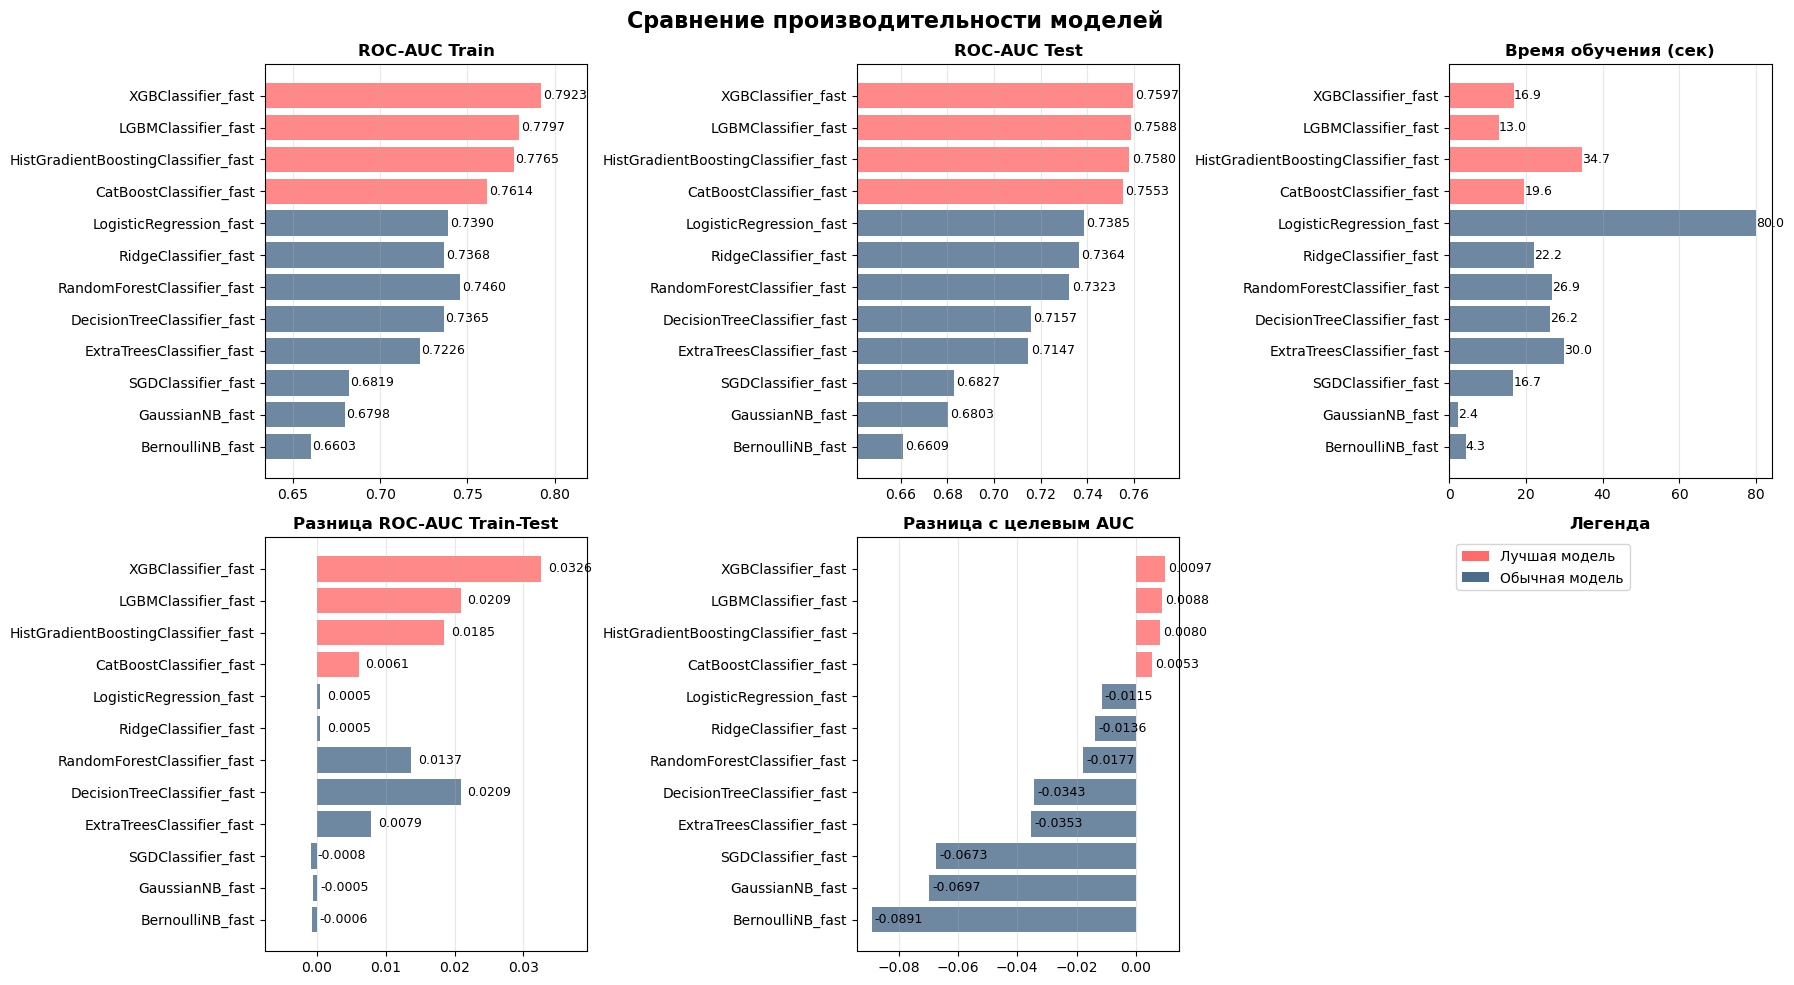

In [59]:
plot_comparison_models(df_results_stage_1)

#### Кривые ROC_AUC - модели 1-го этапа отбора

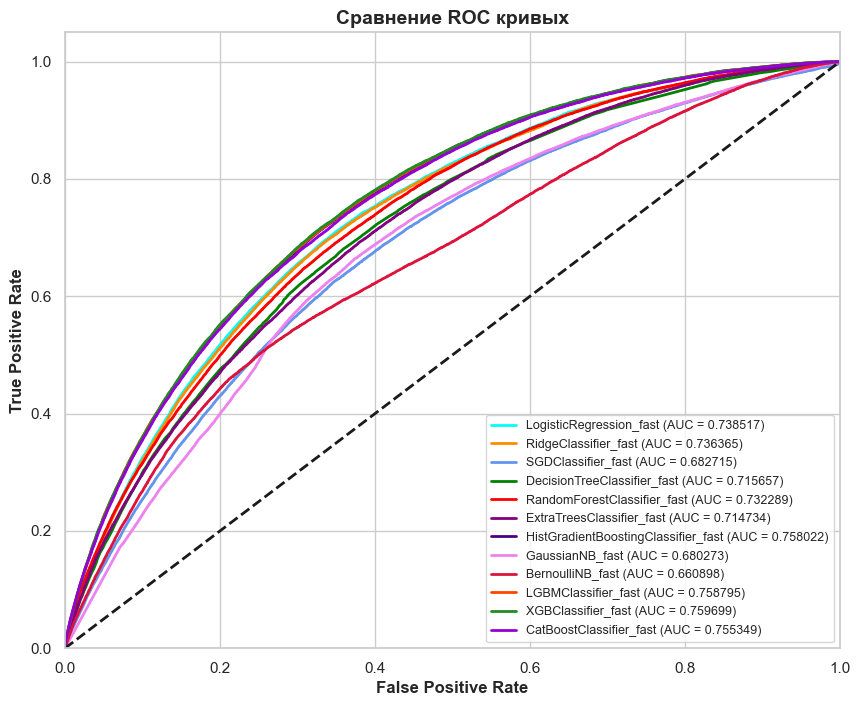

In [60]:
#---------------------------------------------------------------------------------------------------------
# Визуализация кривых roc_auc для всех полученных моделей
    # - pipe_models_list - список словарей с информацией о моделях
    # - pipe_final - лучшая финальная модель (пока пустая)
#---------------------------------------------------------------------------------------------------------
# Подготовка данных для отображения графика
models_for_plot = []

for model in pipe_models_list:
    model_name = model['model_name']
    pipeline   = model['pipeline']
    models_for_plot.append({
                                'model_name': model_name,
                                'pipeline': pipeline
                            })
        
# Вызов функции визуализации
plot_roc_curves(x_test, y_test, models_for_plot, pipe_final=None)

<span style="color:darkred">
    
### __2-й этап отбора моделей__
* сокращенный датасет
* __4 лучших варианта моделей fast__ из первого этапа
* и их ручные модификации:
  * __robust__ (настройки против переобучения)
  * __optional__ (промежуточный вариант, баланс качества и скорости)

</span>

In [61]:
%%time
# 2-й этап - train data
pipe_models_list, df_results = compare_models( x_train, y_train, x_test, y_test,
                                                    preprocessor, is_fit_pipeline=False, 
                                                    a_is_debug=False, n_model_stop=999,
                                                    models_to_test=[
                                                                        'HistGradientBoostingClassifier_fast',
                                                                        'HistGradientBoostingClassifier_robust',
                                                                        'HistGradientBoostingClassifier_optional',
                                                        
                                                                        'LGBMClassifier_fast',
                                                                        'LGBM_robust',
                                                                        'LGBM_optional',
                                                                        
                                                                        'XGBClassifier_fast',
                                                                        'XGB_robust',
                                                                        'XGB_optional',
                                                                        
                                                                        'CatBoostClassifier_fast',
                                                                        'CatBoost_optional'
                                                                    ]
                                             )


1. Training model = HistGradientBoostingClassifier_fast ...
     roc_auc_train = 0.77651;     roc_auc_test = 0.75802;     diff_train_test =  0.01849;     diff_auc_target =  0.00802;     time_fit =  31.2s;     time_pred =   5.7s

2. Training model = LGBMClassifier_fast ...
     roc_auc_train = 0.77968;     roc_auc_test = 0.75880;     diff_train_test =  0.02089;     diff_auc_target =  0.00880;     time_fit =  11.6s;     time_pred =   2.0s

3. Training model = XGBClassifier_fast ...
     roc_auc_train = 0.79225;     roc_auc_test = 0.75970;     diff_train_test =  0.03255;     diff_auc_target =  0.00970;     time_fit =  16.3s;     time_pred =   1.7s

4. Training model = CatBoostClassifier_fast ...
     roc_auc_train = 0.76144;     roc_auc_test = 0.75535;     diff_train_test =  0.00609;     diff_auc_target =  0.00535;     time_fit =  20.5s;     time_pred =   1.3s

5. Training model = HistGradientBoostingClassifier_robust ...
     roc_auc_train = 0.76843;     roc_auc_test = 0.75745;     diff

<span style="color:darkred">
    
#### __Ручной выбор двух лучших моделей (XGB_optional и LGBM_optional) по двум критериям:__
* __Качество__:
    * __1-2-е место__; метрика __roc_auc_test > 0.76__.
* __Скорость обучения__:
    *  __time_fit -> min__

- У __XGB_optional__ метрика __roc_auc_test немного выше__, но __LGBM_optional__ почти __в 2 раза быстрее обучается__
- При обучении и проверке на всем датасете разница в скорости станет еще более значительней. 

</span>

#### Сводная таблица с результатами сравнения моделей (2-й этап)

In [62]:
# Вывод таблицы с результатами (сортировка по roc_auc_test)
    # pd.set_option('display.width', 1000)
#----------------------------------------------------------------------------------------
# выбор лучших моделей - 2-й этап
# Ручной отбор по двум критериям: 
    # Метрика roc_auc - 1-2 места; roc_auc_test > 0.76
    # Время расчета time_fit < 30-40 сек
    # df_results.loc[ (df_results['roc_auc_test'] >= 0.76) & (df_results['time_fit'] < 40), 'is_model_best'] = 1

df_results.loc[ df_results['model_name'].isin( ['XGB_optional', 'LGBM_optional'] ), 'is_model_best'] = 1
df_results[ df_results['is_model_best'] == 1]
#----------------------------------------------------------------------------------------
# Запись в файл
df_results_stage_2 = df_results.copy()
df_results_stage_2.to_csv('results_stage_02_fast_models.csv', index=False)

print('\n' + '-' * 75)
print(' --- СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ 2-го этапа (сортировка по Test AUC) ---')
print('-' * 75)
df_results_stage_2.sort_values(['is_model_final', 'is_model_best', 'roc_auc_test'], ascending=[False, False, False])


---------------------------------------------------------------------------
 --- СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ 2-го этапа (сортировка по Test AUC) ---
---------------------------------------------------------------------------


,N,model_name,is_model_final,is_model_best,roc_auc_train,roc_auc_test,diff_train_test,diff_auc_target,time_fit,time_pred,rank_roc_auc_train,rank_roc_auc_test,rank_time_fit,rank_diff_train_test,total_score,rank_total_score
9,10,XGB_optional,0,1,0.830173,0.763055,0.067118,0.013055,59.1,3.5,1,1,9,11,5.33,4
10,11,LGBM_optional,0,1,0.807102,0.762420,0.044681,0.012420,30.2,5.0,2,2,5,10,4.33,1
8,9,CatBoost_optional,0,0,0.778310,0.760597,0.017712,0.010597,82.5,2.1,6,3,11,5,6.00,5
7,8,HistGradientBoostingClassifier_optional,0,0,0.795723,0.760089,0.035633,0.010089,59.3,11.2,3,4,10,9,6.83,8
2,3,XGBClassifier_fast,0,0,0.792253,0.759699,0.032554,0.009699,16.3,1.7,4,5,2,8,4.50,2
1,2,LGBMClassifier_fast,0,0,0.779684,0.758795,0.020889,0.008795,11.6,2.0,5,6,1,7,4.50,2
5,6,XGB_robust,0,0,0.768485,0.758022,0.010464,0.008022,34.9,1.9,8,7,7,2,6.17,6
0,1,HistGradientBoostingClassifier_fast,0,0,0.776512,0.758022,0.018490,0.008022,31.2,5.7,7,8,6,6,7.00,9
4,5,HistGradientBoostingClassifier_robust,0,0,0.768425,0.757453,0.010973,0.007453,53.0,9.6,9,9,8,3,7.67,11
6,7,LGBM_robust,0,0,0.768310,0.757237,0.011073,0.007237,17.2,3.6,10,10,3,4,6.67,7


### Графики

#### Сравнение показателей моделей 2-го этапа отбора

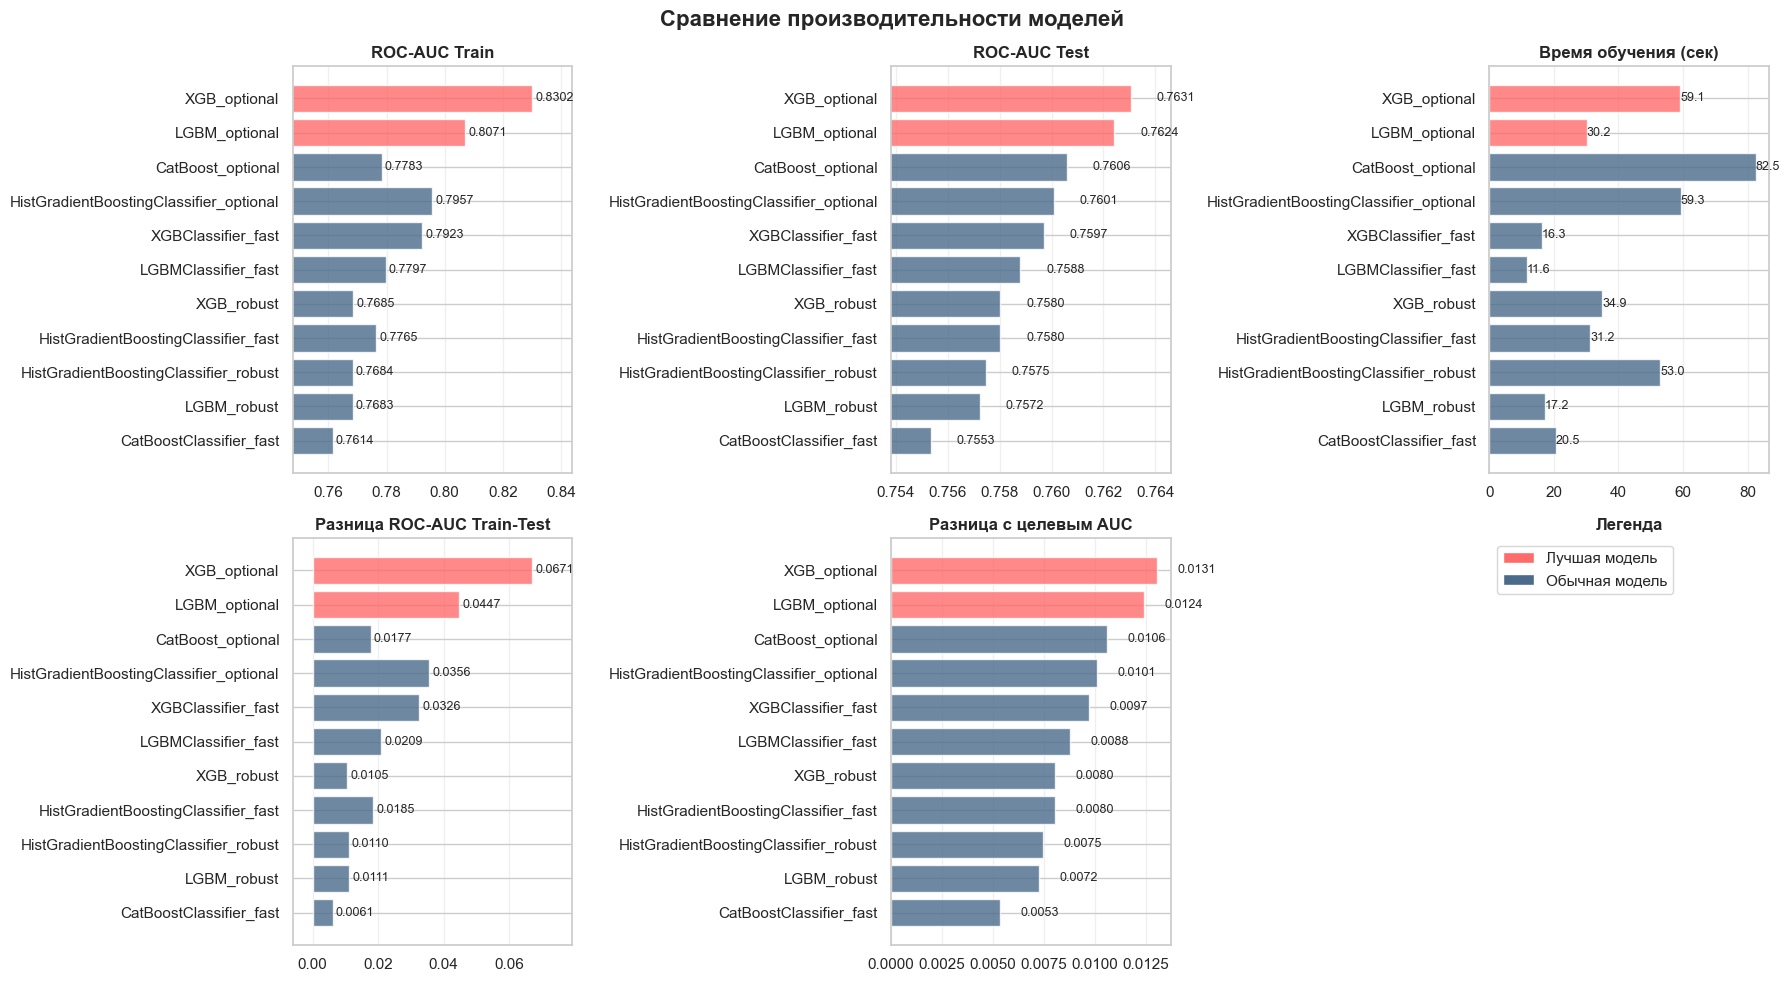

In [63]:
plot_comparison_models(df_results_stage_2)

### Кросс-валидация двух лучших моделей

#### модель XGB_optional

In [64]:
model_best_name = 'XGB_optional'
# model_best_name = df_results.loc[ df_results['is_model_best'] == 1, 'model_name'].iloc[0]
model = (get_pipe_model_by_name(pipe_models_list, model_best_name))['pipeline'].named_steps['classifier']
model_best_name

'XGB_optional'

##### на данных test сокращенного датасета

In [65]:
%%time
# на данных test сокращенного датасета
cv_scores = quick_cross_val_best_model(model, model_best_name, x_test, y_test, cv=5)


Кросс-валидация для XGBClassifier модель: "XGB_optional"...
Результаты кросс-валидации:
	 cv = 5;	 roc_auc mean = 0.753322;	 std = (±0.002838);	 time = 98.8s

cv roc_auc:
	 0.7509311958287079, 0.750010203528487, 0.7524043618753952, 0.7559859236732807, 0.757279223332125
CPU times: total: 953 ms
Wall time: 1min 38s


##### на данных test полного датасета

In [66]:
%%time
# на данных test полного датасета
cv_scores = quick_cross_val_best_model(model, model_best_name, x_test_full, y_test_full, cv=5)


Кросс-валидация для XGBClassifier модель: "XGB_optional"...
Результаты кросс-валидации:
	 cv = 5;	 roc_auc mean = 0.753395;	 std = (±0.003930);	 time = 432.5s

cv roc_auc:
	 0.7523766896971074, 0.7570745062200849, 0.7588350997407188, 0.7489949376048768, 0.7496958463152984
CPU times: total: 3.48 s
Wall time: 7min 12s


#### модель LGBM_optional

In [67]:
model_best_name = 'LGBM_optional'
# model_best_name = df_results.loc[ df_results['is_model_best'] == 1, 'model_name'].iloc[1]
model = (get_pipe_model_by_name(pipe_models_list, model_best_name))['pipeline'].named_steps['classifier']
model_best_name

'LGBM_optional'

##### на данных test сокращенного датасета

In [68]:
%%time
model = (get_pipe_model_by_name(pipe_models_list, model_best_name))['pipeline'].named_steps['classifier']

# на данных test сокращенного датасета
cv_scores = quick_cross_val_best_model(model, model_best_name, x_test, y_test, cv=5)


Кросс-валидация для LGBMClassifier модель: "LGBM_optional"...
Результаты кросс-валидации:
	 cv = 5;	 roc_auc mean = 0.754730;	 std = (±0.002446);	 time = 57.3s

cv roc_auc:
	 0.7535929597451971, 0.7506783042700415, 0.755162957293615, 0.7565107813246486, 0.7577044765910369
CPU times: total: 812 ms
Wall time: 57.3 s


##### на данных test полного датасета

In [69]:
%%time
# на данных test полного датасета
cv_scores = quick_cross_val_best_model(model, model_best_name, x_test_full, y_test_full, cv=5)


Кросс-валидация для LGBMClassifier модель: "LGBM_optional"...
Результаты кросс-валидации:
	 cv = 5;	 roc_auc mean = 0.754442;	 std = (±0.002993);	 time = 173.1s

cv roc_auc:
	 0.7537880475086997, 0.7573776556761478, 0.7584357878240771, 0.7515182018379997, 0.7510879813238718
CPU times: total: 2.27 s
Wall time: 2min 53s


### Важность признаков одной лучшей модели (LGBM_optional), как более быстрой

#### Важность признаков и групп признаков

In [70]:
# model_best_name = 'XGB_optional'
model_best_name = 'LGBM_optional'
#------------------------------------------------------------------------------------------------------------------------------
# Преобразование названия признака
def transform_feature_name(feature_name):
    cleaned = feature_name.replace('ohe_count_', '')
    
    # Если последняя часть после _ является числом - удаляем ее
    parts = cleaned.rsplit('_', 1)
    if len(parts) > 1 and parts[1].isdigit():
        return parts[0]
    else:
        return cleaned

#------------------------------------------------------------------------------------------------------------------------------
model = (get_pipe_model_by_name(pipe_models_list, model_best_name))['pipeline'].named_steps['classifier']

df_importance = get_features_importance_df(model, x_train)
final_table = df_importance.copy()

# Признаки с "высокой" важностью (больше 1%)
final_table['Высокая_важность'] = np.where( final_table['Важность_%'] > 1.0, '1', '')

#------------------------------------------------------------------------------------------------------------------------------
# Выделение обобщенного признака из столбца Признак (без цифр и преобразований)
final_table.insert(0, 'Признак обобщенный', final_table['Признак'].apply(transform_feature_name))
# final_table.insert(0, 'Группа', df_importance['Признак'].str.split('_').str[0])

# Выделение группы признаков по (префиксу)
final_table.insert(0, 'Группа', 
    final_table['Признак обобщенный'].str.split('_', n=2)
                          .str[:2]        # берем первые две части
                          .str.join('_')  # объединяем обратно через '_'
)

final_table['Важность_группы_%'] = final_table.groupby('Группа')['Важность_%'].transform('sum')
# final_table.insert(1, 'Важность_группы_%', 0.0)

final_table['Рейтинг_в_группе'] = (final_table
    .groupby('Группа')['Важность_%']
    .rank(method='dense', ascending=False)
    .astype(int))

group_totals = (final_table
                .groupby('Группа')
                .agg({
                    'Важность_%': 'sum',
                    'Признак':    'count'
                })
                .reset_index()
                .rename(columns={
                    'Важность_%': 'Важность_группы_%',
                    'Признак':    'Количество_признаков'
                }))

final_table = final_table[ ['Группа', 'Важность_группы_%', 'Признак обобщенный', 'Признак', 'Важность', 'Важность_%', 'Высокая_важность', 'Рейтинг_в_группе'] ]
final_table.head(30)

,Группа,Важность_группы_%,Признак обобщенный,Признак,Важность,Важность_%,Высокая_важность,Рейтинг_в_группе
0,ratio_loans,4.586397,ratio_loans_non_zero,ratio_loans_non_zero,406,1.766677,1,1
1,ratio_loans,4.586397,ratio_loans_overdue_total,ratio_loans_overdue_total,360,1.566511,1,2
2,ratio_overdue,4.690832,ratio_overdue_loans530,ratio_overdue_loans530,313,1.361995,1,1
3,ratio_loans,4.586397,ratio_loans_non_maxover2limit,ratio_loans_non_maxover2limit,288,1.253209,1,3
4,ratio_overdue,4.690832,ratio_overdue_loans5,ratio_overdue_loans5,234,1.018232,1,2
5,ratio_overdue,4.690832,ratio_overdue_loans3060,ratio_overdue_loans3060,222,0.966015,,3
6,pre_loans,19.424742,pre_loans_credit_cost_rate,ohe_count_pre_loans_credit_cost_rate_4,208,0.905096,,1
7,pre_loans,19.424742,pre_loans_outstanding,ohe_count_pre_loans_outstanding_1,206,0.896393,,2
8,pre_since,12.727906,pre_since_opened,ohe_count_pre_since_opened_12,202,0.878987,,1
9,pre_since,12.727906,pre_since_confirmed,ohe_count_pre_since_confirmed_9,191,0.831121,,2


#### Суммарная важность групп признаков в %

In [71]:
print(f'\n{s_bold}Суммарная важность групп признаков:\n')
group_totals.sort_values('Важность_группы_%', ascending=False)


Суммарная важность групп признаков:



,Группа,Важность_группы_%,Количество_признаков
3,enc_paym,21.086985,100
7,pre_loans,19.424742,50
11,pre_since,12.727906,38
12,pre_till,9.960402,33
2,enc_loans,6.113746,22
10,pre_pterm,5.691658,18
6,pre_fterm,5.051999,17
13,pre_util,4.886645,20
15,ratio_overdue,4.690832,5
14,ratio_loans,4.586397,3


#### Важность признаков в % внутри групп (Топ-3 признака в каждой группе)

In [72]:
print(f'\n{s_bold}Топ-3 самых важных признака внутри каждой группы:\n')

# if False:
#     top_features_by_group = (final_table
#         .sort_values(['Группа', 'Важность_%'], ascending=[True, False])
#         .groupby('Группа')
#         .head(3)
#         .sort_values(['Важность_группы_%', 'Важность_%'], ascending=[False, False]))
    
#     top_features_by_group[['Группа', 'Признак', 'Важность_%', 'Важность_группы_%']]

final_table.loc[ final_table['Рейтинг_в_группе'] <= 3, ['Группа', 'Признак', 'Важность_%', 'Рейтинг_в_группе', 'Важность_группы_%']]\
    .sort_values(['Важность_группы_%', 'Важность_%'], ascending=[False, False])


Топ-3 самых важных признака внутри каждой группы:



,Группа,Признак,Важность_%,Рейтинг_в_группе,Важность_группы_%
19,enc_paym,ohe_count_enc_paym_0_1,0.670119,1,21.086985
25,enc_paym,ohe_count_enc_paym_1_1,0.587442,2,21.086985
36,enc_paym,ohe_count_enc_paym_3_0,0.496062,3,21.086985
6,pre_loans,ohe_count_pre_loans_credit_cost_rate_4,0.905096,1,19.424742
7,pre_loans,ohe_count_pre_loans_outstanding_1,0.896393,2,19.424742
11,pre_loans,ohe_count_pre_loans_credit_cost_rate_2,0.805013,3,19.424742
8,pre_since,ohe_count_pre_since_opened_12,0.878987,1,12.727906
9,pre_since,ohe_count_pre_since_confirmed_9,0.831121,2,12.727906
27,pre_since,ohe_count_pre_since_opened_19,0.543928,3,12.727906
10,pre_till,ohe_count_pre_till_pclose_10,0.809364,1,9.960402


In [128]:
# final_table.loc[ (final_table['Рейтинг_в_группе'] <= 3) & (final_table['Важность_группы_%'] > 6), ['Группа', 'Признак', 'Важность_%', 'Рейтинг_в_группе', 'Важность_группы_%']]\
#     .sort_values(['Важность_группы_%', 'Важность_%'], ascending=[False, False])

#### Признаки, отмеченные "высокой" важностью (более 1%)

In [73]:
# Признаки, отмеченные "высокой" важностью (более 1%)
final_table.loc[ (final_table['Высокая_важность'] == '1'), ['Группа', 'Признак обобщенный', 'Признак', 'Важность_%', 'Важность_группы_%']].sort_values( ['Важность_группы_%', 'Важность_%'], ascending=[False, False])

,Группа,Признак обобщенный,Признак,Важность_%,Важность_группы_%
2,ratio_overdue,ratio_overdue_loans530,ratio_overdue_loans530,1.361995,4.690832
4,ratio_overdue,ratio_overdue_loans5,ratio_overdue_loans5,1.018232,4.690832
0,ratio_loans,ratio_loans_non_zero,ratio_loans_non_zero,1.766677,4.586397
1,ratio_loans,ratio_loans_overdue_total,ratio_loans_overdue_total,1.566511,4.586397
3,ratio_loans,ratio_loans_non_maxover2limit,ratio_loans_non_maxover2limit,1.253209,4.586397


In [126]:
# final_table[ ['Группа', 'Признак', 'Важность_%', 'Высокая_важность', 'Рейтинг_в_группе']].head(10)

### Графики

#### Визуализация важности признаков одной лучшей модели


Лучшая модель: LGBM_optional
Суммарная важность Топ-50 признаков = 34.42%


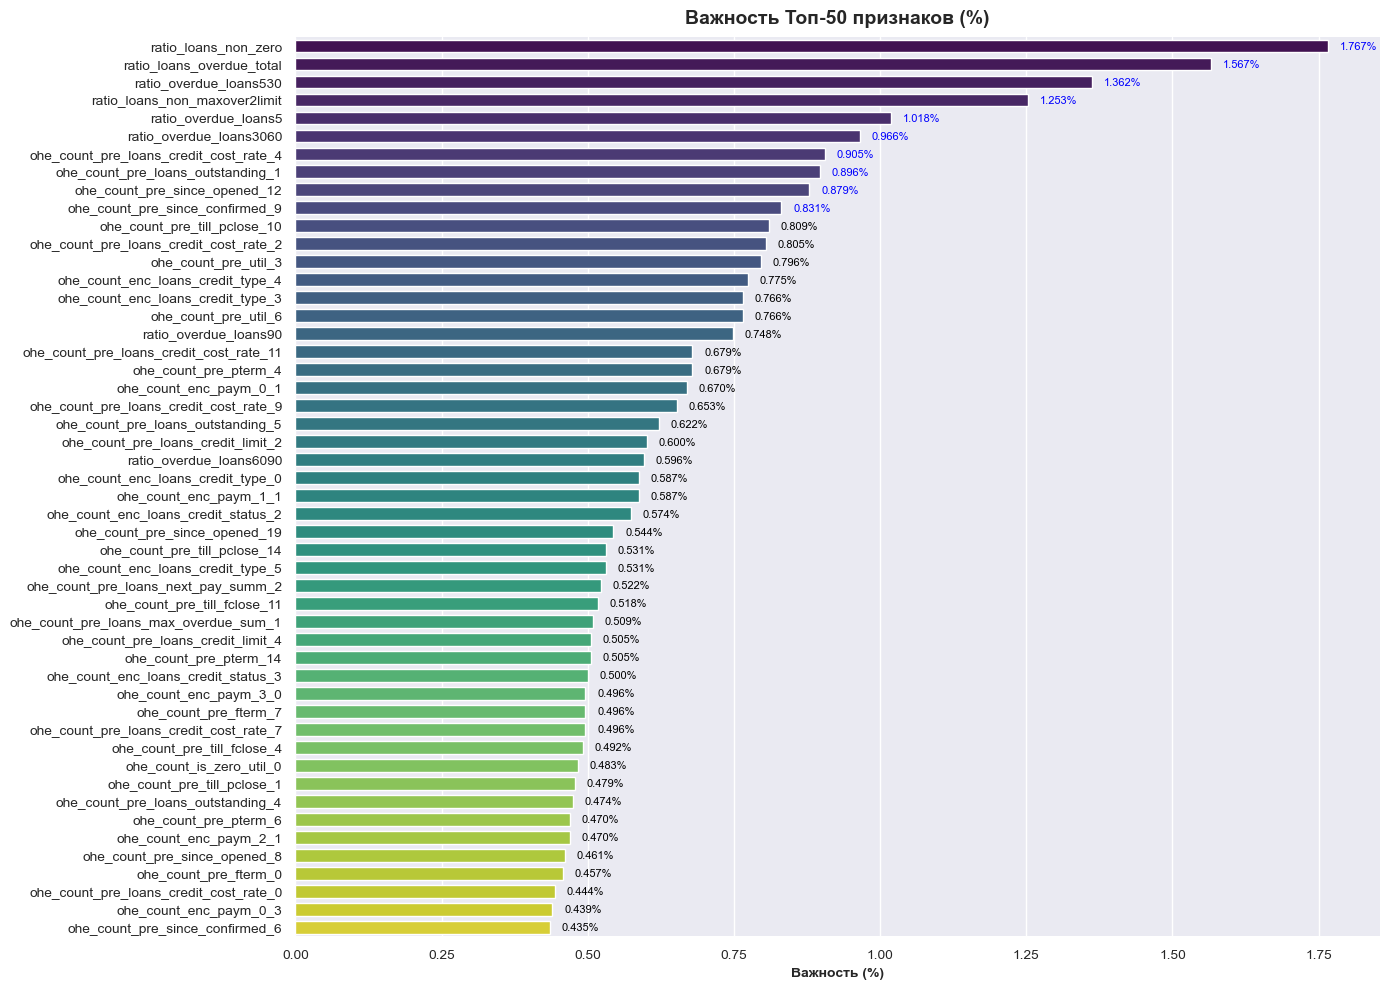

In [74]:
# model_best_name = 'XGB_optional'
model_best_name = 'LGBM_optional'
print(f'\n{s_bold}Лучшая модель: {model_best_name}')
# Визуализация важности признаков лучшей модели
model = (get_pipe_model_by_name(pipe_models_list, model_best_name))['pipeline'].named_steps['classifier']

plot_features_importance(model, x_train, top_n=50, figsize=(14, 10), font_scale=0.9, bar_width=0.7)

#### Визуализация важности групп признаков модели

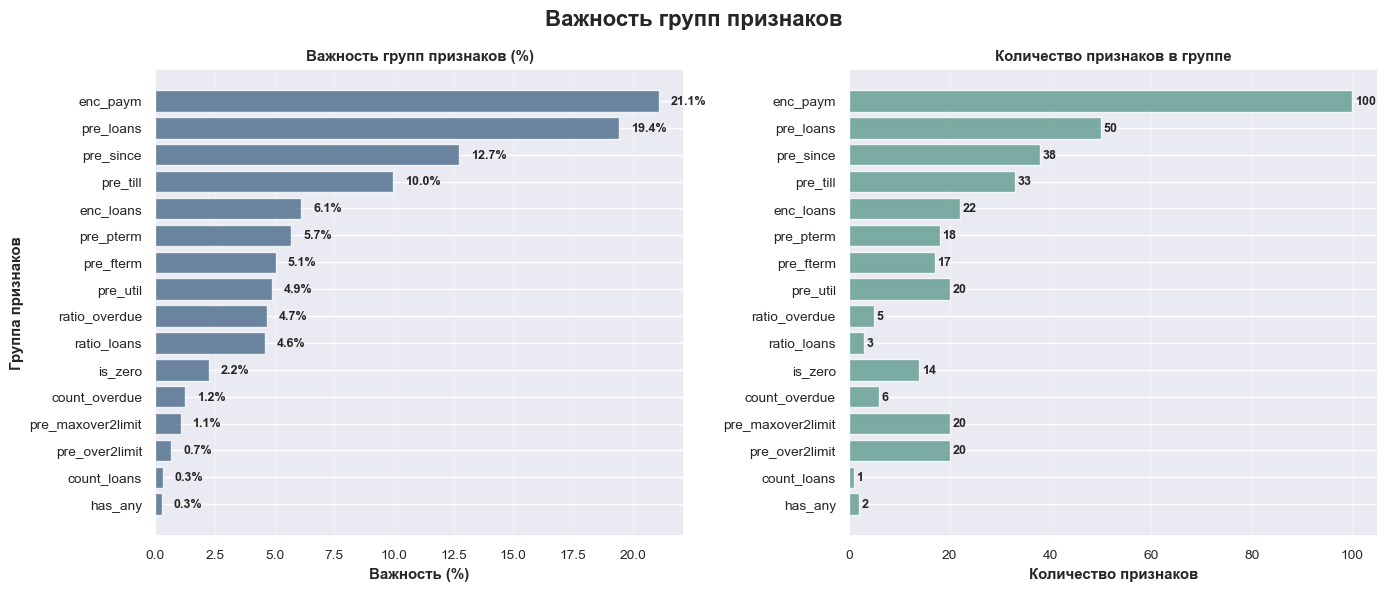

In [75]:
plot_feature_groups_importance(group_totals)

## Подбор гиперпараметров для лучших моделей

### Подбор гиперпараметров для LGBMClassifier - метод RandomizedSearch

In [76]:
model_best_name = 'LGBM_optional'
model = (get_pipe_model_by_name(pipe_models_list, model_best_name))['pipeline'].named_steps['classifier']
type(model).__name__

'LGBMClassifier'

In [92]:
%%time
# Подбор гиперпараметров для лучшей модели
if True:
    # параметры:
        # is_fit_pipeline - True или False:
            # признак, требуется ли обучение для pipeline
        
        # method_search - режим подбора:
            # grid   => GridSearchCV (полный перебор по сетке параметров)
            # random => RandomizedSearchCV (случайный выбор)
    
    search, pipe_model_best = tune_best_model( 
                                                model_best_name=model_best_name, 
                                                x_train=x_train,
                                                y_train=y_train, 
                                                preprocessor=None, is_fit_pipeline=False, 
                                                method_search='random'
                                                # method_search='grid'
    )
    
    df_search_results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score']].sort_values('mean_test_score', ascending=False)

тип модели: LGBMClassifier

Tuning LGBM_optional ...; Method search: RandomizedSearchCV
модель fit...start
модель fit...fisnish
search random...start
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END classifier__colsample_bytree=0.85, classifier__learning_rate=0.07, classifier__max_depth=6, classifier__min_child_samples=50, classifier__n_estimators=800, classifier__reg_alpha=0.3, classifier__reg_lambda=0.7, classifier__subsample=0.8;, score=0.762 total time=  21.9s
[CV 2/3] END classifier__colsample_bytree=0.85, classifier__learning_rate=0.07, classifier__max_depth=6, classifier__min_child_samples=50, classifier__n_estimators=800, classifier__reg_alpha=0.3, classifier__reg_lambda=0.7, classifier__subsample=0.8;, score=0.758 total time=  23.0s
[CV 3/3] END classifier__colsample_bytree=0.85, classifier__learning_rate=0.07, classifier__max_depth=6, classifier__min_child_samples=50, classifier__n_estimators=800, classifier__reg_alpha=0.3, classifier__reg_lambda=0.7

In [93]:
# Результаты кроссвалидации (Топ 10)
print(f"{s_bold}\nРезультаты подбора параметров - Топ-10:")
df_search_results.head(10)


Результаты подбора параметров - Топ-10:


,params,mean_test_score
1,"{'classifier__subsample': 0.85, 'classifier__reg_lambda': 0.5, 'classifier__reg_alpha': 0.7, 'cl...",0.760351
34,"{'classifier__subsample': 0.8, 'classifier__reg_lambda': 0.3, 'classifier__reg_alpha': 0.7, 'cla...",0.760104
32,"{'classifier__subsample': 0.8, 'classifier__reg_lambda': 0.7, 'classifier__reg_alpha': 0.7, 'cla...",0.759852
47,"{'classifier__subsample': 0.8, 'classifier__reg_lambda': 0.3, 'classifier__reg_alpha': 0.7, 'cla...",0.759777
16,"{'classifier__subsample': 0.75, 'classifier__reg_lambda': 0.5, 'classifier__reg_alpha': 0.7, 'cl...",0.759765
41,"{'classifier__subsample': 0.8, 'classifier__reg_lambda': 0.7, 'classifier__reg_alpha': 0.7, 'cla...",0.759698
26,"{'classifier__subsample': 0.75, 'classifier__reg_lambda': 0.3, 'classifier__reg_alpha': 0.3, 'cl...",0.759695
30,"{'classifier__subsample': 0.75, 'classifier__reg_lambda': 0.3, 'classifier__reg_alpha': 0.5, 'cl...",0.759640
19,"{'classifier__subsample': 0.8, 'classifier__reg_lambda': 0.3, 'classifier__reg_alpha': 0.5, 'cla...",0.759634
28,"{'classifier__subsample': 0.85, 'classifier__reg_lambda': 0.7, 'classifier__reg_alpha': 0.3, 'cl...",0.759616


#### Кросс-валидация лучших моделей - LGBMClassifier (подбор параметров RandomizedSearchCV)

##### на данных test сокращенного датасета

In [95]:
%%time
# model = (get_pipe_model_by_name(pipe_models_list, model_best_name))['pipeline'].named_steps['classifier']

#------------------------------------------------------------------------------------------------------------------------------------
# Результаты подбора RandomizedSearchCV
    # n_iter = 50
    # cv = 3
    # Best parameters: {'classifier__subsample': 0.85, 'classifier__reg_lambda': 0.5, 'classifier__reg_alpha': 0.7, 'classifier__n_estimators': 1200, 'classifier__min_child_samples': 50, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.75}
    # Best ROC-AUC:    0.7604
    # Tuning time:     63.3 minutes
    
    # CPU times: total: 12h 42min 2s
    # Wall time: 1h 3min 18s

#------------------------------------------------------------------------------------------------------------------------------------
# grid_rearch_best_params_lgbm = {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 800, 'classifier__num_leaves': 50, 'classifier__reg_alpha': 0.5, 'classifier__reg_lambda': 0.5, 'classifier__subsample': 0.8}
grid_rearch_best_params_lgbm = {'classifier__subsample': 0.85, 'classifier__reg_lambda': 0.5, 'classifier__reg_alpha': 0.7, 'classifier__n_estimators': 1200, 'classifier__min_child_samples': 50, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.75}
model = LGBMClassifier(**grid_rearch_best_params_lgbm, n_jobs=-1, random_state=RANDOM_STATE, verbose=-1)

# на данных test сокращенного датасета
cv_scores = quick_cross_val_best_model(model, 'LGBMClassifier RandomizedSearchCV', x_test, y_test, cv=5)


Кросс-валидация для LGBMClassifier модель: "LGBMClassifier RandomizedSearchCV"...
Результаты кросс-валидации:
	 cv = 5;	 roc_auc mean = 0.753064;	 std = (±0.002296);	 time = 11.1s

cv roc_auc:
	 0.7514238429625512, 0.7495872946364137, 0.7536809104636373, 0.756045161245385, 0.7545834235864288
CPU times: total: 516 ms
Wall time: 11.1 s


##### на данных test полного датасета

In [96]:
%%time
# на данных test полного датасета
cv_scores = quick_cross_val_best_model(model, 'LGBMClassifier RandomizedSearchCV', x_test_full, y_test_full, cv=5)


Кросс-валидация для LGBMClassifier модель: "LGBMClassifier RandomizedSearchCV"...
Результаты кросс-валидации:
	 cv = 5;	 roc_auc mean = 0.752090;	 std = (±0.004272);	 time = 46.4s

cv roc_auc:
	 0.7497075216097153, 0.755927280060946, 0.7584404475385272, 0.7480544201909238, 0.7483193101224489
CPU times: total: 1.81 s
Wall time: 46.4 s


### Подбор гиперпараметров - модель LGBMClassifier - метод Optuna

In [104]:
%%time
# Запуск подбора параметров
study = optuna.create_study(direction='maximize')
study.optimize(
                # objective_fast,
                objective_lgbm_fast,
                n_trials=200, 
                callbacks=[print_trial_info],
                show_progress_bar=False,
                n_jobs=8)

Training until validation scores don't improve for 15 roundsTraining until validation scores don't improve for 15 rounds

Training until validation scores don't improve for 15 rounds
Training until validation scores don't improve for 15 rounds
Training until validation scores don't improve for 15 rounds
Training until validation scores don't improve for 15 rounds
Training until validation scores don't improve for 15 rounds
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[468]	valid_0's auc: 0.755224	valid_0's binary_logloss: 0.367784
 Trial 6; value=0.755224; time=167.5s; (best_value=0.755224; trial 6);  params={'n_estimators': 1500, 'learning_rate': 0.07535479886867856, 'max_depth': 7, 'subsample': 0.8127864614390466, 'colsample_bytree': 0.70331490859325, 'reg_alpha': 0.712371392230684, 'reg_lambda': 0.41751013069830856}
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[475]	valid_0's auc: 0

In [105]:
#------------------------------------------------------------------------------------------------------------------------
# После завершения оптимизации
print('-' * 100)
print('Лучшие параметры:')
print('-' * 100)
print(f'Количество испытаний:   {len(study.trials)}')
print(f'Лучшая метрика roc_auc: {study.best_value:.6f}')
print(f'Лучшие параметры:       {study.best_params}')

#----------------------------------------------------------------------------------------------------------------
# Фильтр - только завершённые и успешные испытания
completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

# Сортировка по значению метрики (по убыванию, т.к. direction='maximize')
best_trials = sorted(completed_trials, key=lambda t: t.value, reverse=True)[:10]

#----------------------------------------------------------------------------------------------------------------
print("\nЛучшие 10 испытаний:\n")

for i, trial in enumerate(best_trials, 1):
    print(f'{i}.  trial  {trial.number}:  roc_auc = {trial.value:.6f};  params={trial.params}')

#----------------------------------------------------------------------------------------------------------------
# Сохранение данных - топ 10 испытаний
top_10_trial_lgbm = [
            {
                "rank":         i,
                "trial_number": trial.number,
                "auc":          trial.value,
                "params":       trial.params
            }
            for i, trial in enumerate(best_trials, 1)
]

----------------------------------------------------------------------------------------------------
Лучшие параметры:
----------------------------------------------------------------------------------------------------
Количество испытаний:   200
Лучшая метрика roc_auc: 0.756974
Лучшие параметры:       {'n_estimators': 1350, 'learning_rate': 0.08530712110301501, 'max_depth': 8, 'subsample': 0.824992281754888, 'colsample_bytree': 0.8180290194001122, 'reg_alpha': 0.224118984130573, 'reg_lambda': 0.5987173376278258}

Лучшие 10 испытаний:

1.  trial  114:  roc_auc = 0.756974;  params={'n_estimators': 1350, 'learning_rate': 0.08530712110301501, 'max_depth': 8, 'subsample': 0.824992281754888, 'colsample_bytree': 0.8180290194001122, 'reg_alpha': 0.224118984130573, 'reg_lambda': 0.5987173376278258}
2.  trial  151:  roc_auc = 0.756919;  params={'n_estimators': 1500, 'learning_rate': 0.0892914467443281, 'max_depth': 8, 'subsample': 0.883369256682461, 'colsample_bytree': 0.8896353040717778, 'reg

#### Кросс-валидация лучших моделей - модель LGBMClassifier (подбор параметров Optuna)

##### на данных test сокращенного датасета

In [108]:
%%time
# model = (get_pipe_model_by_name(pipe_models_list, model_best_name))['pipeline'].named_steps['classifier']

#------------------------------------------------------------------------------------------------------------------------------------
# Результаты подбора
    # Лучший AUC: 0.758391
    # Лучшие параметры: {'n_estimators': 700, 'learning_rate': 0.05525062185787501, 'max_depth': 7, 'num_leaves': 55, 'subsample': 0.766358771274964, 'colsample_bytree': 0.7994636624337572}
    # Количество trials: 60
    # CPU times: total: 2h 4min 57s
    # Wall time: 4min 30s

    # Количество испытаний:   100
    # Лучшая метрика roc_auc: 0.755638
    # Лучшие параметры:       {'n_estimators': 750, 'learning_rate': 0.07200081920866715, 'max_depth': 8, 'subsample': 0.820600670059482, 'colsample_bytree': 0.7833941331643384, 'reg_alpha': 0.5441395191271834, 'reg_lambda': 0.7367045901093237}
    # CPU times: total: 1h 40min 11s
    # Wall time: 8min 8s

    # Количество испытаний:   200
    # Лучшая метрика roc_auc: 0.756974
    # Лучшие параметры:       {'n_estimators': 1350, 'learning_rate': 0.08530712110301501, 'max_depth': 8, 'subsample': 0.824992281754888, 'colsample_bytree': 0.8180290194001122, 'reg_alpha': 0.224118984130573, 'reg_lambda': 0.5987173376278258}
    # CPU times: total: 4h 14min 50s
    # Wall time: 20min 6

optuna_search_best_params_lgbm = {'n_estimators': 700, 'learning_rate': 0.05525062185787501, 'max_depth': 7, 'num_leaves': 55, 'subsample': 0.766358771274964, 'colsample_bytree': 0.7994636624337572}
# optuna_search_best_params_lgbm = {'n_estimators': 750, 'learning_rate': 0.07200081920866715, 'max_depth': 8, 'subsample': 0.820600670059482, 'colsample_bytree': 0.7833941331643384, 'reg_alpha': 0.5441395191271834, 'reg_lambda': 0.7367045901093237}
# optuna_search_best_params_lgbm = {'n_estimators': 1350, 'learning_rate': 0.08530712110301501, 'max_depth': 8, 'subsample': 0.824992281754888, 'colsample_bytree': 0.8180290194001122, 'reg_alpha': 0.224118984130573, 'reg_lambda': 0.5987173376278258}
model = LGBMClassifier(**optuna_search_best_params_lgbm, n_jobs=-1, random_state=RANDOM_STATE, verbose=-1)

# на данных test сокращенного датасета
cv_scores = quick_cross_val_best_model(model, 'LGBMClassifier objective_lgbm_fast', x_test, y_test, cv=5)


Кросс-валидация для LGBMClassifier модель: "LGBMClassifier objective_lgbm_fast"...
Результаты кросс-валидации:
	 cv = 5;	 roc_auc mean = 0.754549;	 std = (±0.001977);	 time = 68.2s

cv roc_auc:
	 0.7534837763484775, 0.7518108461798937, 0.754047746456529, 0.7558665183791354, 0.7575364803516811
CPU times: total: 1.16 s
Wall time: 1min 8s


##### на данных test полного датасета

In [109]:
%%time
# на данных test полного датасета
cv_scores = quick_cross_val_best_model(model, 'LGBMClassifier objective_lgbm_fast', x_test_full, y_test_full, cv=5)


Кросс-валидация для LGBMClassifier модель: "LGBMClassifier objective_lgbm_fast"...
Результаты кросс-валидации:
	 cv = 5;	 roc_auc mean = 0.752891;	 std = (±0.003808);	 time = 202.3s

cv roc_auc:
	 0.7521062971027977, 0.7561152706690806, 0.7583472600131873, 0.7484040417134861, 0.7494840773088707
CPU times: total: 3.56 s
Wall time: 3min 22s


#### Кросс-валидация лучших моделей - модель LGBMClassifier (подбор параметров Optuna) - Долгий подбор - 6 часов (широкие диапазоны значений)

##### на данных test сокращенного датасета

In [112]:
%%time
# model = (get_pipe_model_by_name(pipe_models_list, model_best_name))['pipeline'].named_steps['classifier']

#------------------------------------------------------------------------------------------------------------------------------------
# Результаты подбора
	# {'rank': 1,
	#   'trial_number': 204,
	#   'auc': 0.75759477615239,
	#   'params': {'n_estimators': 1650, 'learning_rate': 0.02424703456435817, 'max_depth': 7, 'num_leaves': 59, 'subsample': 0.729283573622419, 'colsample_bytree': 0.7248044994766626, 'reg_alpha': 0.738924554711979, 'reg_lambda': 0.7647132769869521, 'min_child_samples': 70, 'is_unbalance': False}
    # }
    # Wall time: 6 hours 17 min

optuna_search_best_params_lgbm_long = {'n_estimators': 1650, 'learning_rate': 0.02424703456435817, 'max_depth': 7, 'num_leaves': 59, 'subsample': 0.729283573622419, 'colsample_bytree': 0.7248044994766626, 'reg_alpha': 0.738924554711979, 'reg_lambda': 0.7647132769869521, 'min_child_samples': 70, 'is_unbalance': False}
model = LGBMClassifier(**optuna_search_best_params_lgbm_long, n_jobs=-1, random_state=RANDOM_STATE, verbose=-1)

# на данных test сокращенного датасета
cv_scores = quick_cross_val_best_model(model, 'LGBMClassifier objective_fast', x_test, y_test, cv=5)
cv_scores


Кросс-валидация для LGBMClassifier модель: "LGBMClassifier objective_fast"...
Результаты кросс-валидации:
	 cv = 5;	 roc_auc mean = 0.756917;	 std = (±0.002293);	 time = 124.9s

cv roc_auc:
	 0.7556009191689534, 0.7537759415031733, 0.7560989195854231, 0.759796912360797, 0.7593109607772667
CPU times: total: 1.23 s
Wall time: 2min 4s


array([0.75560092, 0.75377594, 0.75609892, 0.75979691, 0.75931096])

##### на данных test полного датасета

In [113]:
%%time
# на данных test полного датасета
# cv_scores = quick_cross_val_best_model(final_model, x_test_full, y_test_full, cv=3)
cv_scores = quick_cross_val_best_model(model, 'LGBMClassifier objective_fast', x_test_full, y_test_full, cv=5)
cv_scores


Кросс-валидация для LGBMClassifier модель: "LGBMClassifier objective_fast"...
Результаты кросс-валидации:
	 cv = 5;	 roc_auc mean = 0.756771;	 std = (±0.003240);	 time = 454.1s

cv roc_auc:
	 0.7558235183550323, 0.7593794857418308, 0.7616238833771466, 0.7534662938978074, 0.7535613306092284
CPU times: total: 3.83 s
Wall time: 7min 34s


array([0.75582352, 0.75937949, 0.76162388, 0.75346629, 0.75356133])

### Подбор гиперпараметров - модель XGBClassifier - метод Optuna

In [118]:
%%time
# Запуск подбора параметров
study = optuna.create_study(direction='maximize')
study.optimize(
                # objective_fast,
                objective_xgb_fast,
                n_trials=150, 
                callbacks=[print_trial_info],
                show_progress_bar=False,
                n_jobs=8)

 Trial 7; value=0.754656; time=170.6s; (best_value=0.754656; trial 7);  params={'n_estimators': 900, 'learning_rate': 0.08714316064820127, 'max_depth': 7, 'subsample': 0.8646144987397975, 'colsample_bytree': 0.749960726031793, 'reg_alpha': 0.7257708490921917, 'reg_lambda': 0.4764177191189589, 'min_child_weight': 40}
 Trial 5; value=0.754395; time=185.8s; (best_value=0.754656; trial 7);  params={'n_estimators': 1000, 'learning_rate': 0.07012609924635463, 'max_depth': 8, 'subsample': 0.8388635971346916, 'colsample_bytree': 0.7428935340373106, 'reg_alpha': 0.2701569618204426, 'reg_lambda': 0.35695712104735466, 'min_child_weight': 40}
 Trial 2; value=0.755526; time=245.8s; (best_value=0.755526; trial 2);  params={'n_estimators': 800, 'learning_rate': 0.08455782336298129, 'max_depth': 7, 'subsample': 0.8393273688499706, 'colsample_bytree': 0.8719378866137215, 'reg_alpha': 0.22604880300736951, 'reg_lambda': 0.19258072512530994, 'min_child_weight': 50}
 Trial 3; value=0.755405; time=248.7s; (

In [119]:
#------------------------------------------------------------------------------------------------------------------------
# После завершения оптимизации
print('-' * 100)
print('Лучшие параметры:')
print('-' * 100)
print(f'Количество испытаний:   {len(study_prophet.trials)}')
print(f'Лучшая метрика roc_auc: {study_prophet.best_value:.6f}')
print(f'Лучшие параметры:       {study_prophet.best_params}')

#----------------------------------------------------------------------------------------------------------------
# Фильтр - только завершённые и успешные испытания
completed_trials = [t for t in study_prophet.trials if t.state == optuna.trial.TrialState.COMPLETE]

# Сортировка по значению метрики (по убыванию, т.к. direction='maximize')
best_trials = sorted(completed_trials, key=lambda t: t.value, reverse=False)[:10]

#----------------------------------------------------------------------------------------------------------------
print("\nЛучшие 10 испытаний:\n")

for i, trial in enumerate(best_trials, 1):
    print(f'{i}.  trial  {trial.number}:  roc_auc = {trial.value:.6f};  params={trial.params}')

#----------------------------------------------------------------------------------------------------------------
# Сохранение данных - топ 10 испытаний
top_10_trial_prophet = [
            {
                "rank":         i,
                "trial_number": trial.number,
                "auc":          trial.value,
                "params":       trial.params
            }
            for i, trial in enumerate(best_trials, 1)
]

----------------------------------------------------------------------------------------------------
Лучшие параметры:
----------------------------------------------------------------------------------------------------
Количество испытаний:   150
Лучшая метрика roc_auc: 0.758081
Лучшие параметры:       {'n_estimators': 1000, 'learning_rate': 0.033019071561003456, 'max_depth': 9, 'subsample': 0.7665473841441554, 'colsample_bytree': 0.8346382656042973, 'reg_alpha': 0.5181540185095732, 'reg_lambda': 0.6752815102869354, 'min_child_weight': 90}

Лучшие 10 испытаний:

1.  trial  134:  roc_auc = 0.758081;  params={'n_estimators': 1000, 'learning_rate': 0.033019071561003456, 'max_depth': 9, 'subsample': 0.7665473841441554, 'colsample_bytree': 0.8346382656042973, 'reg_alpha': 0.5181540185095732, 'reg_lambda': 0.6752815102869354, 'min_child_weight': 90}
2.  trial  38:  roc_auc = 0.758046;  params={'n_estimators': 550, 'learning_rate': 0.03082810638872834, 'max_depth': 9, 'subsample': 0.70001144

#### Кросс-валидация лучших моделей - модель XGBClassifier - подбор параметров Optuna

##### на данных test сокращенного датасета

In [116]:
# grid_rearch_best_params_xgb = {'n_estimators': 600, 'learning_rate': 0.07325309360792943, 'max_depth': 7, 'subsample': 0.7925253013696111, 'colsample_bytree': 0.7753091203701221, 'reg_alpha': 0.6341420006607617, 'reg_lambda': 0.5007341443587163, 'min_child_weight': 70}
# grid_rearch_best_params_xgb

In [121]:
%%time
# model = (get_pipe_model_by_name(pipe_models_list, model_best_name))['pipeline'].named_steps['classifier']

# Результаты подбора:
    # Количество испытаний:   60
    # Лучшая метрика roc_auc: 0.764125
    # Лучшие параметры:       {'n_estimators': 600, 'learning_rate': 0.07325309360792943, 'max_depth': 7, 'subsample': 0.7925253013696111, 'colsample_bytree': 0.7753091203701221, 'reg_alpha': 0.6341420006607617, 'reg_lambda': 0.5007341443587163, 'min_child_weight': 70}
    # CPU times: total: 3h 35min 8s
    # Wall time: 54min 31s

    # Количество испытаний:   150
    # Лучшая метрика roc_auc: 0.758081
    # Лучшие параметры:       {'n_estimators': 1000, 'learning_rate': 0.033019071561003456, 'max_depth': 9, 'subsample': 0.7665473841441554, 'colsample_bytree': 0.8346382656042973, 'reg_alpha': 0.5181540185095732, 'reg_lambda': 0.6752815102869354, 'min_child_weight': 90}
    # CPU times: total: 1d 3h 23min 48s
    # Wall time: 1h 56min 19s

# grid_rearch_best_params_xgb = {'n_estimators': 600, 'learning_rate': 0.07325309360792943, 'max_depth': 7, 'subsample': 0.7925253013696111, 'colsample_bytree': 0.7753091203701221, 'reg_alpha': 0.6341420006607617, 'reg_lambda': 0.5007341443587163, 'min_child_weight': 70}
grid_rearch_best_params_xgb = {'n_estimators': 1000, 'learning_rate': 0.033019071561003456, 'max_depth': 9, 'subsample': 0.7665473841441554, 'colsample_bytree': 0.8346382656042973, 'reg_alpha': 0.5181540185095732, 'reg_lambda': 0.6752815102869354, 'min_child_weight': 90}
model = XGBClassifier(**grid_rearch_best_params_xgb, n_jobs=-1, random_state=RANDOM_STATE, eval_metric='logloss', verbosity=0)

# на данных test сокращенного датасета
cv_scores = quick_cross_val_best_model(model, 'XGBClassifier objective_xgb_fast', x_test, y_test, cv=5)


Кросс-валидация для XGBClassifier модель: "XGBClassifier objective_xgb_fast"...
Результаты кросс-валидации:
	 cv = 5;	 roc_auc mean = 0.758111;	 std = (±0.002281);	 time = 157.7s

cv roc_auc:
	 0.7567935792478266, 0.754878636415768, 0.7574914232604888, 0.7609010825344534, 0.7604908611655419
CPU times: total: 1.47 s
Wall time: 2min 37s


##### на данных test полного датасета

In [122]:
%%time
# на данных test полного датасета
cv_scores = quick_cross_val_best_model(model, 'XGBClassifier objective_xgb_fast', x_test_full, y_test_full, cv=5)


Кросс-валидация для XGBClassifier модель: "XGBClassifier objective_xgb_fast"...
Результаты кросс-валидации:
	 cv = 5;	 roc_auc mean = 0.759061;	 std = (±0.003435);	 time = 673.1s

cv roc_auc:
	 0.7573409189244658, 0.7618996909462363, 0.7643177159752466, 0.7559939067167787, 0.755753529209963
CPU times: total: 2.5 s
Wall time: 11min 13s


## Ансамбли моделей

### __Ансамбль моделей - VotingClassifier (вариант 1)__
* ##### __`XGB_optional` + `LGBM_optional` + `CatBoost_optional`__
* Две лучших модели - XGB_optional и LGBM_optional + CatBoost_optional - модель с хорошей обобщающей способностью и минимальным переобучением

In [131]:
model_xgb_1  = (get_pipe_model_by_name(pipe_models_list, 'XGB_optional'))['pipeline'].named_steps['classifier']
model_lgbm_1 = (get_pipe_model_by_name(pipe_models_list, 'LGBM_optional'))['pipeline'].named_steps['classifier']
model_cb_1   = (get_pipe_model_by_name(pipe_models_list, 'CatBoost_optional'))['pipeline'].named_steps['classifier']

model_xgb_1, model_lgbm_1, model_cb_1

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.07, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=800,
               n_jobs=-1, num_parallel_tree=None, random_state=42, ...),
 LGBMClassifier(colsample_bytree=0.8, learning_rate=0.07, max_depth=6,
                min_child_samples=50, n_estimators=800, n_jobs=-1,
                random_state=42, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8,
                v

In [134]:
%%time
ensemble_1 = VotingClassifier(
    estimators=[
        ('XGB_optional',      model_xgb_1),
        ('LGBM_optional',     model_lgbm_1), 
        ('CatBoost_optional', model_cb_1), 
    ],
    voting='soft',
    weights=[1, 1, 1],
    n_jobs=-1
)

ensemble_1

CPU times: total: 0 ns
Wall time: 0 ns


,estimators,"[('XGB_optional', ...), ('LGBM_optional', ...), ...]"
,voting,'soft'
,weights,"[1, 1, ...]"
,n_jobs,-1
,flatten_transform,True
,verbose,False
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None


#### Предсказание и оценка

In [135]:
%%time
ensemble_1.fit(x_train, y_train)

y_train_proba = ensemble_1.predict_proba(x_train)[:, 1]
y_test_proba  = ensemble_1.predict_proba(x_test)[:, 1]

roc_auc_train = roc_auc_score(y_train, y_train_proba)
roc_auc_test  = roc_auc_score(y_test,  y_test_proba)

print(f'{type(ensemble_1).__name__} ensemble_1:\n\t roc_auc train = {roc_auc_train:.6f};\t roc_auc test = {roc_auc_test:.6f}\n')

# VotingClassifier ensemble_1:	 
#    roc_auc train = 0.820395;	 roc_auc test = 0.761556
# CPU times: total: 25min 2s
# Wall time: 52.5 s

# VotingClassifier ensemble_1:
# 	 roc_auc train = 0.809855;	 roc_auc test = 0.764166

# CPU times: total: 1min 6s
# Wall time: 5min 3s

VotingClassifier ensemble_1:
	 roc_auc train = 0.809855;	 roc_auc test = 0.764166

CPU times: total: 1min 6s
Wall time: 5min 3s


#### Кросс-валидация ансамбля моделей (вариант 1) - 
* __VotingClassifier (`XGB_optional` + `LGBM_optional` + `CatBoost_optional`)__

##### на данных test сокращенного датасета

In [136]:
%%time
model = ensemble_1
# model
# grid_rearch_best_params_xgb = {'n_estimators': 600, 'learning_rate': 0.07325309360792943, 'max_depth': 7, 'subsample': 0.7925253013696111, 'colsample_bytree': 0.7753091203701221, 'reg_alpha': 0.6341420006607617, 'reg_lambda': 0.5007341443587163, 'min_child_weight': 70}
# model = XGBClassifier(**grid_rearch_best_params_xgb, n_jobs=-1, random_state=RANDOM_STATE, eval_metric='logloss', verbosity=0)

# на данных test сокращенного датасета
cv_scores = quick_cross_val_best_model(model, 'VotingClassifier (XGB_optional + LGBM_optional + CatBoost_optional)', x_test, y_test, cv=5)

# 	 cv = 5;	 roc_auc: 0.755188;	 (±0.001503);	 time = 90.1s
# CPU times: total: 719 ms
# Wall time: 1min 30s

# 	 cv = 5;	 roc_auc mean = 0.758364;	 std = (±0.002548);	 time = 148.2s

# cv roc_auc:
# 	 0.7563934442089847, 0.7549528277704527, 0.7579610278425026, 0.761108992676605, 0.7614037753731632
# CPU times: total: 1.06 s
# Wall time: 2min 28s


Кросс-валидация для VotingClassifier модель: "VotingClassifier (XGB_optional + LGBM_optional)"...
Результаты кросс-валидации:
	 cv = 5;	 roc_auc mean = 0.758364;	 std = (±0.002548);	 time = 148.2s

cv roc_auc:
	 0.7563934442089847, 0.7549528277704527, 0.7579610278425026, 0.761108992676605, 0.7614037753731632
CPU times: total: 1.06 s
Wall time: 2min 28s


##### на данных test полного датасета

In [137]:
%%time
# на данных test полного датасета
# cv_scores = quick_cross_val_best_model(final_model, x_test_full, y_test_full, cv=3)
cv_scores = quick_cross_val_best_model(model, 'VotingClassifier (XGB_optional + LGBM_optional + CatBoost_optional)', x_test_full, y_test_full, cv=5)


Кросс-валидация для VotingClassifier модель: "VotingClassifier (XGB_optional + LGBM_optional)"...
Результаты кросс-валидации:
	 cv = 5;	 roc_auc mean = 0.757963;	 std = (±0.003630);	 time = 680.1s

cv roc_auc:
	 0.7571259318097123, 0.7608987745604577, 0.7633138067850493, 0.754522217928377, 0.7539530600062074
CPU times: total: 3.28 s
Wall time: 11min 20s


### __Ансамбль моделей - VotingClassifier (вариант 2)__
* ##### __`LGBMCLassifier objective_fast` + `XGBClassifier objective_xgb_fast` + `CatBoost_optional`__
* LGBM и XGB - варианты подбора параметров методом Optuna
* LGBM - долгий подбор - 6 часов (широкие диапазоны значений)
* CatBoost_optional - модель с хорошей обобщающей способностью и минимальным переобучением

In [138]:
optuna_search_best_params_lgbm_long = {'n_estimators': 1650, 'learning_rate': 0.02424703456435817, 'max_depth': 7, 'num_leaves': 59, 'subsample': 0.729283573622419, 'colsample_bytree': 0.7248044994766626, 'reg_alpha': 0.738924554711979, 'reg_lambda': 0.7647132769869521, 'min_child_samples': 70, 'is_unbalance': False}
model_lgbm_2 = LGBMClassifier(**optuna_search_best_params_lgbm_long, n_jobs=-1, random_state=RANDOM_STATE, verbose=-1)	

# grid_rearch_best_params_xgb = {'n_estimators': 600, 'learning_rate': 0.07325309360792943, 'max_depth': 7, 'subsample': 0.7925253013696111, 'colsample_bytree': 0.7753091203701221, 'reg_alpha': 0.6341420006607617, 'reg_lambda': 0.5007341443587163, 'min_child_weight': 70}
grid_rearch_best_params_xgb = {'n_estimators': 1000, 'learning_rate': 0.033019071561003456, 'max_depth': 9, 'subsample': 0.7665473841441554, 'colsample_bytree': 0.8346382656042973, 'reg_alpha': 0.5181540185095732, 'reg_lambda': 0.6752815102869354, 'min_child_weight': 90}
model_xgb_2 = XGBClassifier(**grid_rearch_best_params_xgb, n_jobs=-1, random_state=RANDOM_STATE, eval_metric='logloss', verbosity=0)

model_cb_2   = (get_pipe_model_by_name(pipe_models_list, 'CatBoost_optional'))['pipeline'].named_steps['classifier']

model_lgbm_2, model_xgb_2, model_cb_2

(LGBMClassifier(colsample_bytree=0.7248044994766626, is_unbalance=False,
                learning_rate=0.02424703456435817, max_depth=7,
                min_child_samples=70, n_estimators=1650, n_jobs=-1,
                num_leaves=59, random_state=42, reg_alpha=0.738924554711979,
                reg_lambda=0.7647132769869521, subsample=0.729283573622419,
                verbose=-1),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8346382656042973, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='logloss', feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.033019071561003456,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=9, max_leaves=None,
      

In [139]:
%%time
# все веса = 1
ensemble_2 = VotingClassifier(
    estimators=[
        ('LGBMCLassifier objective_fast',    model_lgbm_2),
        ('XGBClassifier objective_xgb_fast', model_xgb_2), 
        ('CatBoost_optional',                model_cb_2),
    ],
    voting='soft',
    weights=[1, 1, 1],
    n_jobs=-1
)

ensemble_2

CPU times: total: 0 ns
Wall time: 0 ns


,estimators,"[('LGBMCLassifier objective_fast', ...), ('XGBClassifier objective_xgb_fast', ...), ...]"
,voting,'soft'
,weights,"[1, 1, ...]"
,n_jobs,-1
,flatten_transform,True
,verbose,False
,boosting_type,'gbdt'
,num_leaves,59
,max_depth,7
,learning_rate,0.02424703456435817
,n_estimators,1650


#### Предсказание и оценка

In [140]:
%%time
ensemble_2.fit(x_train, y_train)

y_train_proba = ensemble_2.predict_proba(x_train)[:, 1]
y_test_proba  = ensemble_2.predict_proba(x_test)[:, 1]

roc_auc_train = roc_auc_score(y_train, y_train_proba)
roc_auc_test  = roc_auc_score(y_test,  y_test_proba)

print(f'{type(ensemble_2).__name__} ensemble_2:\n\t roc_auc train = {roc_auc_train:.6f};\t roc_auc test = {roc_auc_test:.6f}')

# VotingClassifier ensemble_2:	 roc_auc train = 0.818123;	 roc_auc test = 0.762631
# CPU times: total: 37min 24s
# Wall time: 1min 17s

# VotingClassifier ensemble_2:	 roc_auc train = 0.812156;	 roc_auc test = 0.765238
# CPU times: total: 2min 45s
# Wall time: 4min 40s

VotingClassifier ensemble_2:	 roc_auc train = 0.812156;	 roc_auc test = 0.765238
CPU times: total: 2min 45s
Wall time: 4min 40s


#### Кросс-валидация ансамбля моделей (вариант 2) - (`LGBMCLassifier objective_fast` + `XGBClassifier objective_xgb_fast` + `CatBoost_optional`)

##### на данных test сокращенного датасета

In [141]:
%%time
model = ensemble_2
# model
# grid_rearch_best_params_xgb = {'n_estimators': 600, 'learning_rate': 0.07325309360792943, 'max_depth': 7, 'subsample': 0.7925253013696111, 'colsample_bytree': 0.7753091203701221, 'reg_alpha': 0.6341420006607617, 'reg_lambda': 0.5007341443587163, 'min_child_weight': 70}
# model = XGBClassifier(**grid_rearch_best_params_xgb, n_jobs=-1, random_state=RANDOM_STATE, eval_metric='logloss', verbosity=0)

# на данных test сокращенного датасета
cv_scores = quick_cross_val_best_model(model, "VotingClassifier (LGBMCLassifier_objective_fast + XGBClassifier_objective_xgb_fast + CatBoost_optional)", x_test, y_test, cv=5)


Кросс-валидация для VotingClassifier модель: "VotingClassifier (LGBMCLassifier_objective_fast + XGBClassifier_objective_xgb_fast + CatBoost_optional)"...
Результаты кросс-валидации:
	 cv = 5;	 roc_auc mean = 0.759644;	 std = (±0.002368);	 time = 237.0s

cv roc_auc:
	 0.7579360307138945, 0.7565922667853451, 0.7589218467690031, 0.7627608048487894, 0.7620066891281849
CPU times: total: 1.5 s
Wall time: 3min 56s


##### на данных test полного датасета

In [142]:
%%time
# на данных test полного датасета
cv_scores = quick_cross_val_best_model(model, "VotingClassifier (LGBMCLassifier_objective_fast + XGBClassifier_objective_xgb_fast + CatBoost_optional)", x_test_full, y_test_full, cv=5)


Кросс-валидация для VotingClassifier модель: "VotingClassifier (LGBMCLassifier_objective_fast + XGBClassifier_objective_xgb_fast + CatBoost_optional)"...
Результаты кросс-валидации:
	 cv = 5;	 roc_auc mean = 0.759686;	 std = (±0.003552);	 time = 1067.8s

cv roc_auc:
	 0.7585288292547253, 0.7622258831757731, 0.7652528404934356, 0.7564819606270434, 0.7559383138974858
CPU times: total: 5.28 s
Wall time: 17min 47s


## Финальная модель

### Создание и обучение препроцессора обработки данных

In [143]:
%%time
# Создание и обучение финального пайплайна одном из файлов с данными
if True:
    df_test_data, time_read = read_dataset_one_file( 
                                                        PATH_TO_DATA_TRAIN + 'train_data_10.pq', 
                                                        is_debug=True, 
                                                        is_memory_optimize=True
    )

if df_test_data is not None:
    
    file_name = PATH_TO_DATA_TRAIN + FILE_TRAIN_TARGET
    if os.path.exists(file_name):
        
        print(f'Чтение файла {file_name}...')
        df_target = pd.read_csv( file_name )
        optimize_numeric(df_target, is_debug=False)
    
    df_test_data = df_test_data.merge( df_target, on='id', how='left')
    df_test_data = df_test_data.rename(columns={'flag': 'target'})
    
    cols_selected = [col for col in df_test_data.columns if col not in ['target']]
    x_temp = df_test_data[ cols_selected ]
    y_temp = df_test_data['target']
    
    # Создание и обучение пайплайна предобработки данных
    if True:
        all_top_features = get_top_important_features_selected()
        all_possible_scaled_columns = [col for col in df_data.columns if (col.startswith('count_')) or (col.startswith('ohe_count_'))]
        
        preprocessor = create_preprocessor(all_top_features=all_top_features, 
                                            all_possible_scaled_columns=all_possible_scaled_columns,
                                            verbose=True)
        # preprocessor
    
        print(f'\n*** fit_transform ***')
        preprocessor.fit_transform(x_temp, y_temp)

# Освобождение памяти
df_test_data, x_temp, y_temp = None, None, None

Чтение одного файла ... train_data/train_data_10.pq
	Оптимизация типов данных завершена; время оптимизации = 1.9 сек
	Объем памяти (ДО оптимизации типов данных и ПОСЛЕ):	 1.121 Гб >> 0.147 Гб
Чтение завершено:
	Общее время чтения и обработки = 3.2 сек;   Размер = (2296372, 61)
Чтение файла train_data/train_target.csv...

*** fit_transform ***
----------------------------------------------------------------------------------------------------
Выполняется data_preprocessing ...
	Группировка данных по столбцу "rn"...
	Создание новых признаков ...
	Выполняется ohe_source_columns ...
		ohe - 1 - source df_ids shape = (2296372, 1)
		ohe - 2 - fit
		ohe - 3 - transform; df_ids shape = (2296372, 1)
		ohe - 4 - df_ids: group & sum; df_ids shape = (250000, 412)
		ohe - 5 - df_total - merge; df_total.shape = (250000, 432)
	ohe_source_columns завершен:	   Время выполнения = 15.4s;	   shape = (250000, 432)
[Pipeline]  (step 1 of 4) Processing data_preprocessing, total=  15.9s
----------------------

#### Обучение финальной модели на всех данных

In [135]:
model_best_name = 'LGBMClassifier_fast'
# model_best_name = 'LGBM_optional'
pipe_model_best = (get_pipe_model_by_name(pipe_models_list, model_best_name))['pipeline']
model_best = (get_pipe_model_by_name(pipe_models_list, model_best_name))['pipeline'].named_steps['classifier']

print(type(model_best).__name__)
print(pipe_model_best)

LGBMClassifier
Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_preprocessing',
                                  FunctionTransformer(func=<function data_preprocessing at 0x0000022FD3775C60>)),
                                 ('selector_features',
                                  FeatureSelectorTransformer(all_top_features=['ratio_overdue_loans3060',
                                                                               'ratio_overdue_loans90',
                                                                               'ratio_overdue_loans6090',
                                                                               'ratio_loans_overdue_total',
                                                                               'ratio_overdue_loans530',
                                                                               'count_ov...
                                                                                     'ohe_count_enc_loans_

In [145]:
model_best_name = 'VotingClassifier (LGBMCLassifier_objective_fast + XGBClassifier_objective_xgb_fast + CatBoost_optional)'
# pipe_model_best = (get_pipe_model_by_name(pipe_models_list, model_best_name))['pipeline']
model_best = ensemble_2

print(type(model_best).__name__)
# print(pipe_model_best)

VotingClassifier


In [162]:
%%time
# Обучение финальной модели на всех данных
# x_full = pd.concat([x_train_full, x_test_full], axis=0)
# y_full = pd.concat([y_train_full, y_test_full], axis=0)

if True:
    pipe_final, df_result_final = train_final_model(
                                                        model_best_name,
                                                        model_best.get_params(),
                                                        # pipe_model_best.named_steps['classifier'].get_params(),
                                                        # x_train, y_train,  # x_temp, y_temp,
                                                        pd.concat([x_train_full, x_test_full], axis=0),
                                                        pd.concat([y_train_full, y_test_full], axis=0),
                                                        preprocessor,
                                                        is_fit_pipeline=False,
                                                        model_external=model_best
                                                    )
    
df_result_final

CPU times: total: 48min 56s
Wall time: 29min 39s


,N,model_name,is_model_final,is_model_best,roc_auc_train,roc_auc_test,diff_train_test,diff_auc_target,time_fit,time_pred,rank_roc_auc_train,rank_roc_auc_test,rank_time_fit,rank_diff_train_test,total_score,rank_total_score
0,-1,VotingClassifier (LGBMCLassifier_objective_fast + XGBClassifier_objective_xgb_fast + CatBoost_op...,1,1,0.798823,0.798823,0.0,0.048823,1672.4,106.5,0,0,0,0,0.0,0


#### Объединение результатов сравнения всех моделей с финальной моделью

In [163]:
# Объединение результатов отбора моделей и финальной модели
df_resuls_all = pd.concat( [df_results, df_result_final])

# Вывод таблицы результатов всех моделей; в самом вверху списка - финальная и лучшая модели
# Сортировка: 
    # финальная модель, лучшая модель, остальные модели по убыванию метрики roc_auc_test
df_resuls_all.sort_values(['is_model_final', 'is_model_best', 'roc_auc_test'], ascending=[False, False, False])

,N,model_name,is_model_final,is_model_best,roc_auc_train,roc_auc_test,diff_train_test,diff_auc_target,time_fit,time_pred,rank_roc_auc_train,rank_roc_auc_test,rank_time_fit,rank_diff_train_test,total_score,rank_total_score
0,-1,VotingClassifier (LGBMCLassifier_objective_fast + XGBClassifier_objective_xgb_fast + CatBoost_op...,1,1,0.798823,0.798823,0.000000,0.048823,1672.4,106.5,0,0,0,0,0.00,0
9,10,XGB_optional,0,1,0.830173,0.763055,0.067118,0.013055,59.1,3.5,1,1,9,11,5.33,4
10,11,LGBM_optional,0,1,0.807102,0.762420,0.044681,0.012420,30.2,5.0,2,2,5,10,4.33,1
8,9,CatBoost_optional,0,0,0.778310,0.760597,0.017712,0.010597,82.5,2.1,6,3,11,5,6.00,5
7,8,HistGradientBoostingClassifier_optional,0,0,0.795723,0.760089,0.035633,0.010089,59.3,11.2,3,4,10,9,6.83,8
2,3,XGBClassifier_fast,0,0,0.792253,0.759699,0.032554,0.009699,16.3,1.7,4,5,2,8,4.50,2
1,2,LGBMClassifier_fast,0,0,0.779684,0.758795,0.020889,0.008795,11.6,2.0,5,6,1,7,4.50,2
5,6,XGB_robust,0,0,0.768485,0.758022,0.010464,0.008022,34.9,1.9,8,7,7,2,6.17,6
0,1,HistGradientBoostingClassifier_fast,0,0,0.776512,0.758022,0.018490,0.008022,31.2,5.7,7,8,6,6,7.00,9
4,5,HistGradientBoostingClassifier_robust,0,0,0.768425,0.757453,0.010973,0.007453,53.0,9.6,9,9,8,3,7.67,11


#### Графики кривых ROC_AUC (с финальной моделью)

In [181]:
#---------------------------------------------------------------------------------------------------------
# Визуализация кривых roc_auc для всех полученных моделей
    # - pipe_models_list - список словарей с информацией о моделях
    # - pipe_final - лучшая финальная модель
#---------------------------------------------------------------------------------------------------------
# Подготовка данных для отображения графика
if False:
    models_for_plot = []
    list_models_best = df_results.loc[ df_results['is_model_best'] == 1, 'model_name'].values

    for model in pipe_models_list:
        if model['model_name'] in list_models_best:
            model_name = model['model_name']
            pipeline   = model['pipeline']
            # print(model_name)
            models_for_plot.append({
                                        'model_name': model_name,
                                        'pipeline': pipeline
                                    })
        # Вызов функции визуализации
        plot_roc_curves(x_test, y_test, models_for_plot, pipe_final=None)

### Запись модели в файл

In [174]:
# Запись модели в файл
if True:
    roc_auc_test = df_resuls_all.loc[df_resuls_all['is_model_final'] == 1, 'roc_auc_test'].mean()
    print(f'Метрика roc_auc_test = {roc_auc_test}')
    save_model(pipe_final, 'credit_risk_management_prediction_model.pkl', round(roc_auc_test, 6))

Метрика roc_auc_test = 0.79882262
Модель успешно записана в файл: models/credit_risk_management_prediction_model.pkl


### Проверка. Загрузка модели из файла

In [175]:
# Проверка - Загрузка модели из файла
pipe_model_loaded = load_model('credit_risk_management_prediction_model.pkl')
pipe_model_loaded

{'model': Pipeline(steps=[('preprocessor',
                  Pipeline(steps=[('data_preprocessing',
                                   FunctionTransformer(func=<function data_preprocessing at 0x000002BC50AF7060>)),
                                  ('selector_features',
                                   FeatureSelectorTransformer(all_top_features=['ratio_overdue_loans3060',
                                                                                'ratio_overdue_loans90',
                                                                                'ratio_overdue_loans6090',
                                                                                'ratio_loans_overdue_total',
                                                                                'ratio_overdue_loans530',
                                                                                'count_ov...
                                                              max_cat_threshold=None,
                

In [176]:
pipe_model_loaded['model']

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('data_preprocessing', ...), ('selector_features', ...), ...]"
,transform_input,None
,memory,None
,verbose,True
,func,<function dat...002BC50AF7060>
,inverse_func,None
,validate,False


In [177]:
pipe_model_loaded['model'].named_steps['classifier']

,estimators,"[('LGBMCLassifier objective_fast', ...), ('XGBClassifier objective_xgb_fast', ...), ...]"
,voting,'soft'
,weights,"[1, 1, ...]"
,n_jobs,-1
,flatten_transform,True
,verbose,False
,boosting_type,'gbdt'
,num_leaves,59
,max_depth,7
,learning_rate,0.02424703456435817
,n_estimators,1650


#### Проверка атрибутов пайплайна и модели

In [179]:
# Проверка, что модель загружена корректно
if False:
    print(f'Тип модели: {type(pipe_model_loaded['model'])}')
    print(f'Тип классификатора: {type(pipe_model_loaded['model'].named_steps['classifier']).__name__}')
    
    attr = [attr for attr in dir(pipe_model_loaded['model']) if 'fit' in attr or 'class' in attr]
    print(f"\nАтрибуты обученности: {attr}")
    
    # Проверка атрибутов, указывающих на обучение
    print("Проверка атрибутов:")
    for item in attr:
        print(f"\thasattr(model, '{item:<22}'): {hasattr(pipe_model_loaded['model'], item)}")

#### Получение параметров загруженной модели

In [180]:
model_params = pipe_model_loaded['model'].named_steps['classifier'].get_params()
print('Параметры - список:')
print(f'model_params = {model_params}\n')

# Получение параметров загруженной модели
model_params = pipe_model_loaded['model'].named_steps['classifier'].get_params()

df_params = pd.DataFrame({
    'Параметр': model_params.keys(),
    'Значение': model_params.values()
})

print('Параметры - таблица:')
print(df_params)

Параметры - список:
model_params = {'estimators': [('LGBMCLassifier objective_fast', LGBMClassifier(colsample_bytree=0.7248044994766626, is_unbalance=False,
               learning_rate=0.02424703456435817, max_depth=7,
               min_child_samples=70, n_estimators=1650, n_jobs=-1,
               num_leaves=59, random_state=42, reg_alpha=0.738924554711979,
               reg_lambda=0.7647132769869521, subsample=0.729283573622419,
               verbose=-1)), ('XGBClassifier objective_xgb_fast', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8346382656042973, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.033019071561003456,
              max_bin=None, max_cat_thr